## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

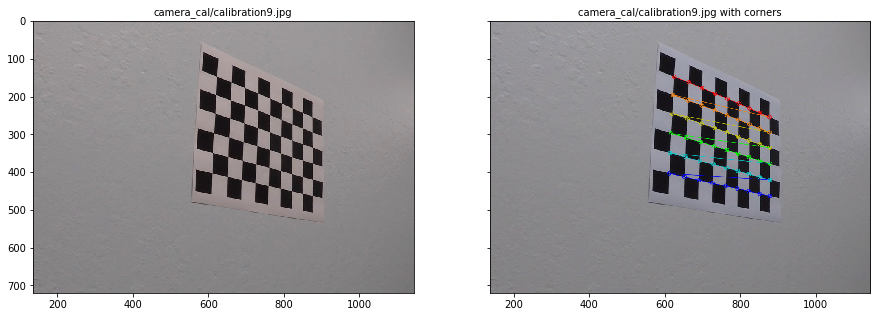

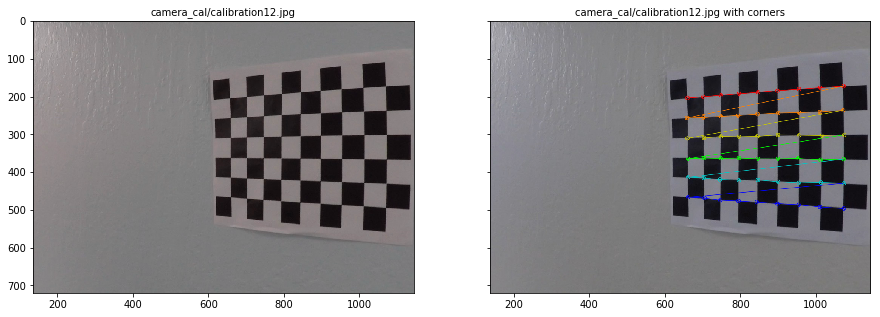

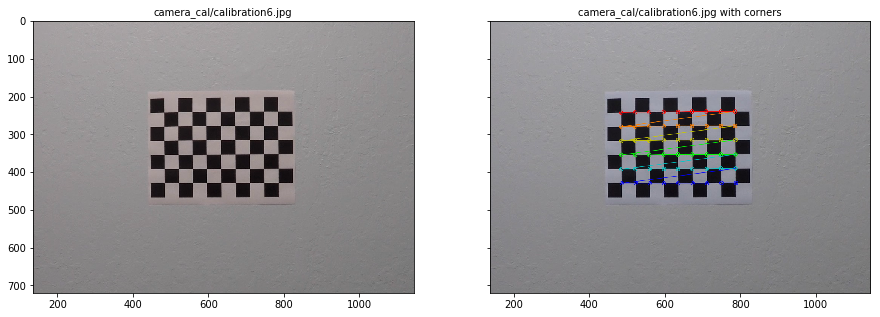

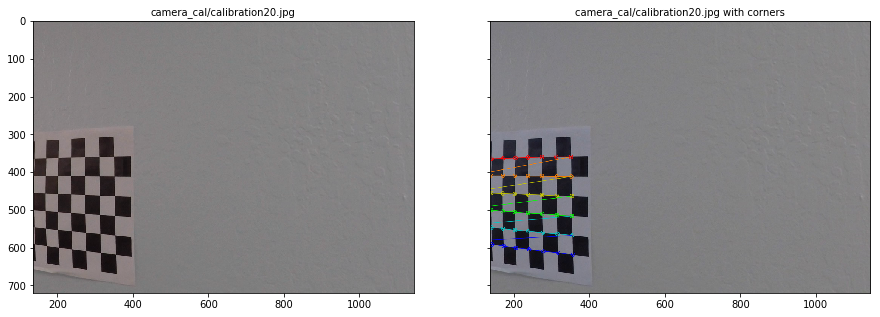

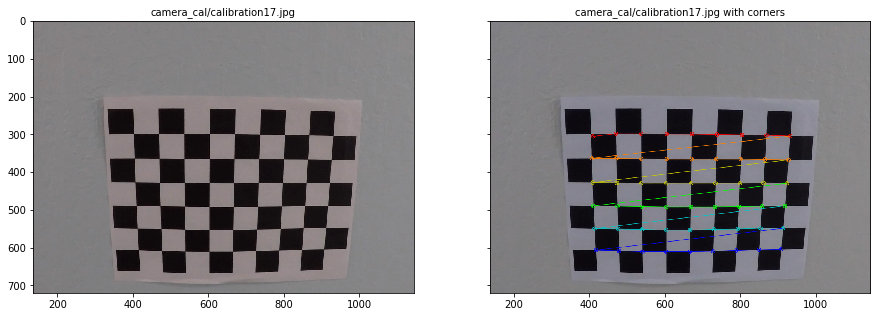

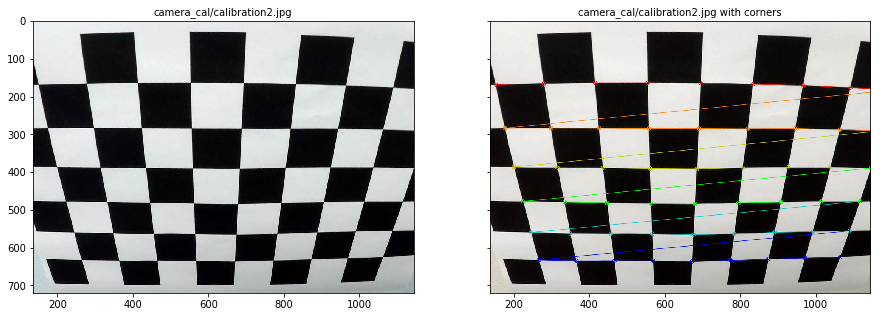

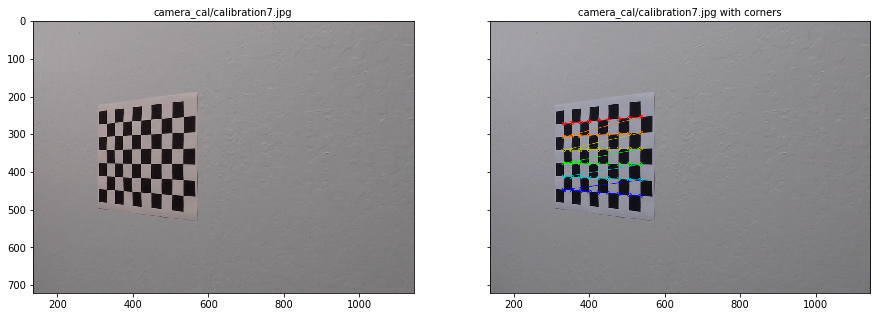

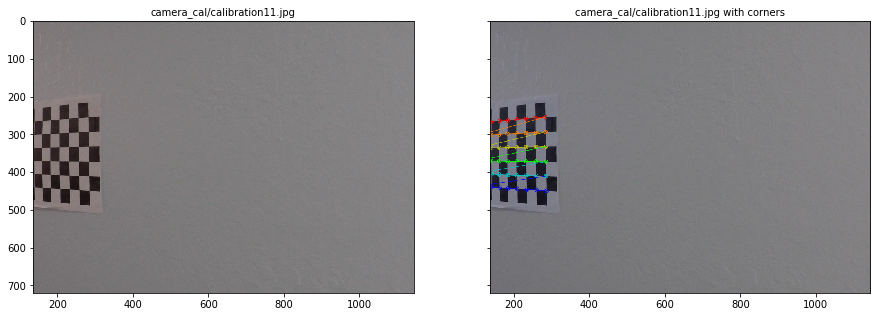

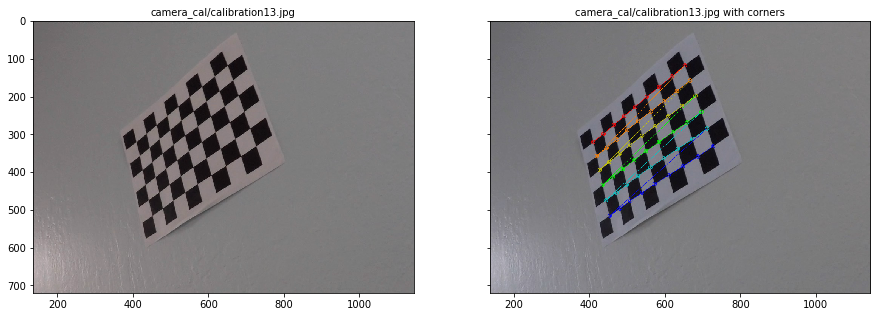

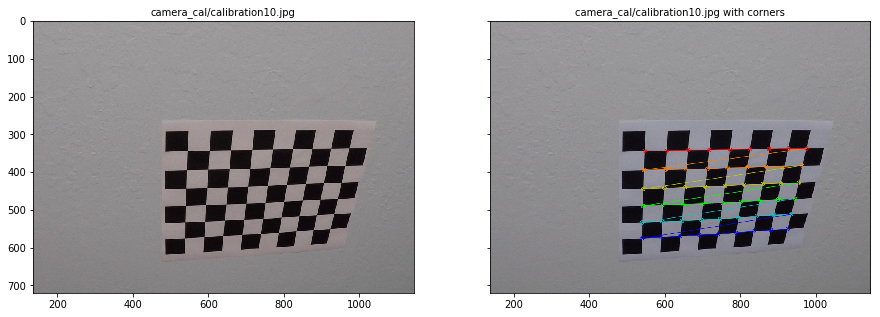

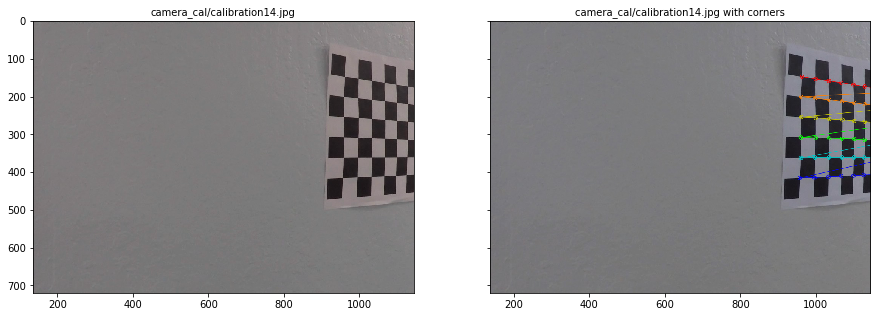

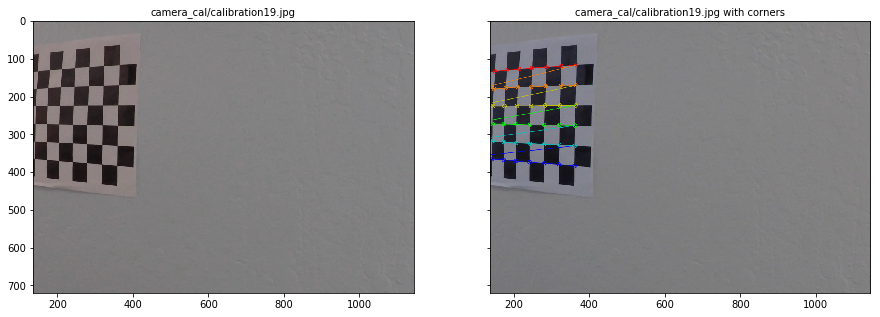

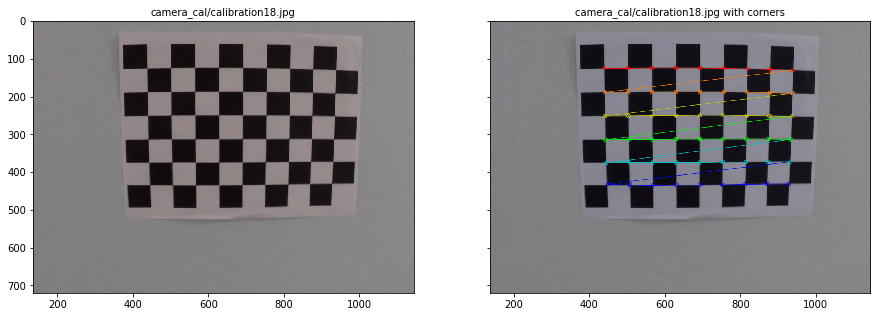

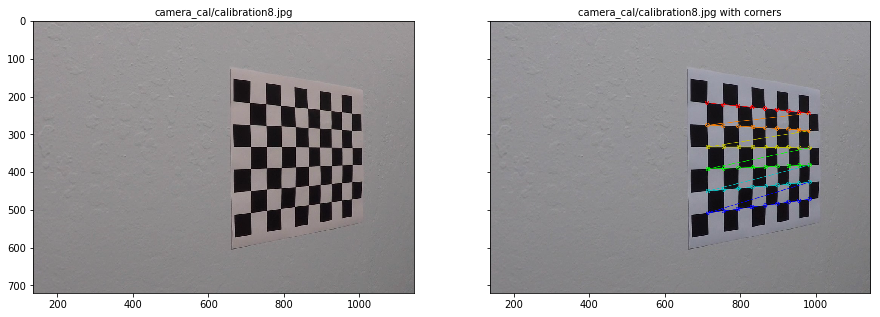

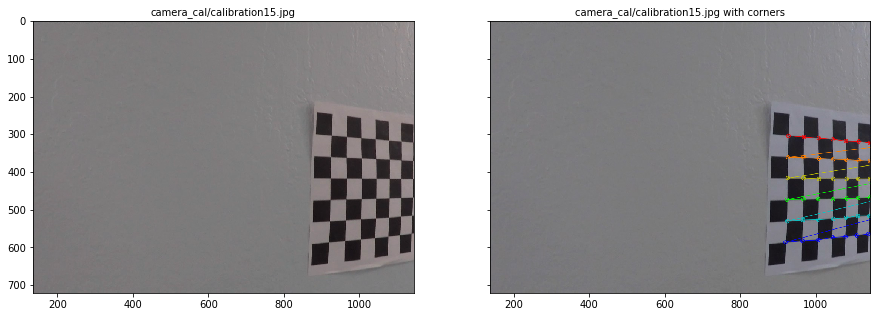

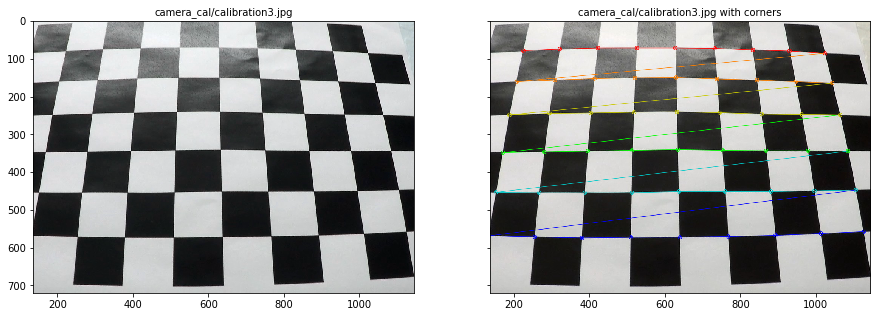

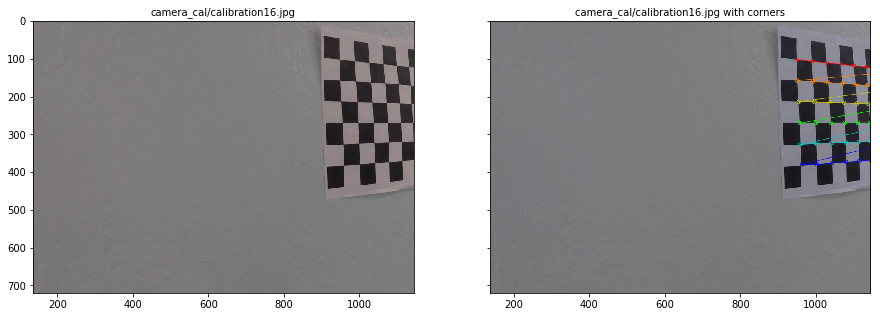

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:

    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        #print (fname)        
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5), sharey = True)
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title(fname, fontsize=10)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title(fname+' with corners', fontsize=10)
        
#cv2.destroyAllWindows()


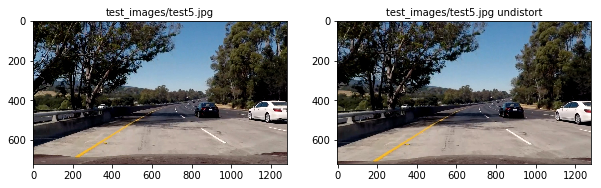

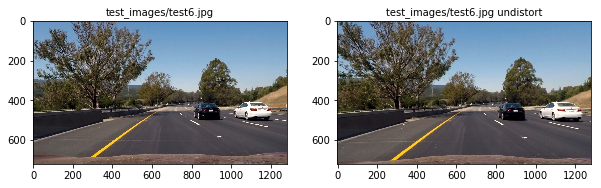

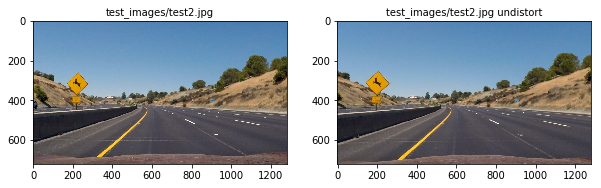

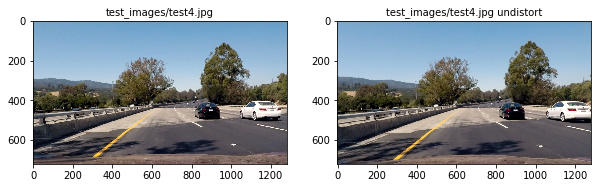

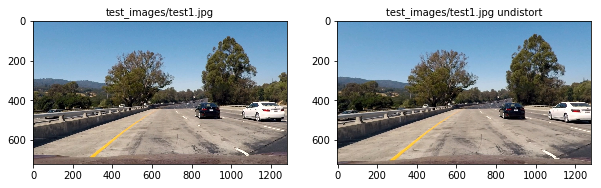

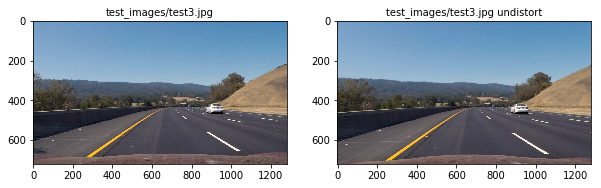

In [2]:
def calculate_undistort(img):
    imagesize = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imagesize,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst
    
testImages = glob.glob('test_images/test*.jpg')
for fname in testImages:
    tImg = cv2.imread(fname)    
    newImg = calculate_undistort(tImg)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1.imshow(cv2.cvtColor(tImg, cv2.COLOR_BGR2RGB))
    ax1.set_title(fname, fontsize=10)
    ax2.imshow(cv2.cvtColor(newImg, cv2.COLOR_BGR2RGB))
    ax2.set_title(fname+' undistort', fontsize=10)

## Perspective Transform

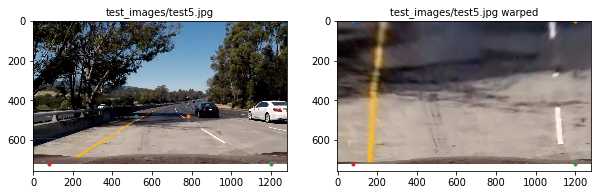

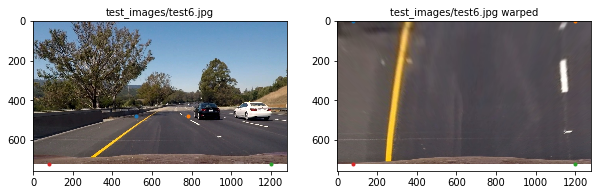

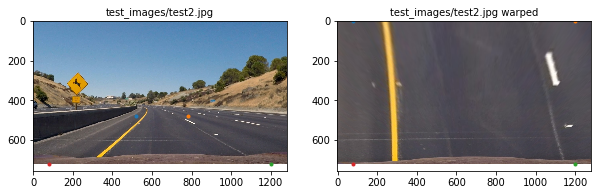

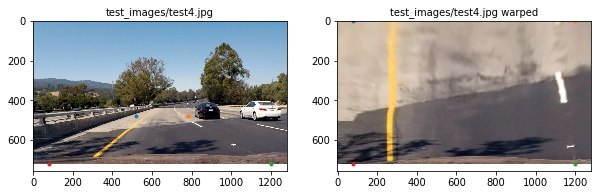

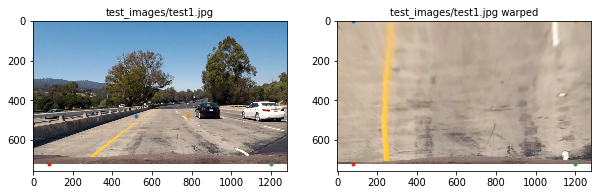

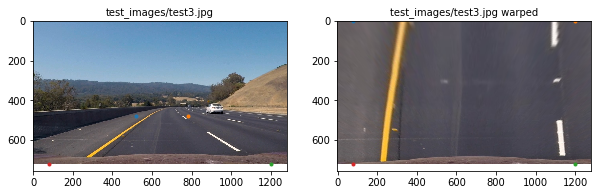

In [3]:
#plt.imshow(mpimg.imread('test_images/test1.jpg'))
src = np.float32([[595, 460],[720, 460],[1090, 680],[300, 680]])
dst = np.float32([[150, 40], [1180, 40], [1180, 680],[150, 680]])
#dst = np.float32([[300, 40], [1090, 40], [1090, 680],[300, 680]])

src = np.float32([[520, 480],[780, 480],[1200, 720],[80, 720]])
dst = np.float32([[80, 0], [1200, 0], [1200, 720],[80, 720]])

#plt.plot(src[0][0], src[0][1], '.')
#plt.plot(src[1][0], src[1][1], '.')
#plt.plot(src[2][0], src[2][1], '.')
#plt.plot(src[3][0], src[3][1], '.')

def perspective_transform(image):
    undistort = calculate_undistort(image)
    imagesize = (undistort.shape[1], undistort.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undistort, M, imagesize)
    return warped

testImages = glob.glob('test_images/test*.jpg')
for fname in testImages:
    tImg = cv2.imread(fname)    
    newImg = perspective_transform(tImg)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1.imshow(cv2.cvtColor(tImg, cv2.COLOR_BGR2RGB))
    ax1.plot(src[0][0], src[0][1], '.')
    ax1.plot(src[1][0], src[1][1], '.')
    ax1.plot(src[2][0], src[2][1], '.')
    ax1.plot(src[3][0], src[3][1], '.')
    ax1.set_title(fname, fontsize=10)
    ax2.imshow(cv2.cvtColor(newImg, cv2.COLOR_BGR2RGB))
    ax2.plot(dst[0][0], dst[0][1], '.')
    ax2.plot(dst[1][0], dst[1][1], '.')
    ax2.plot(dst[2][0], dst[2][1], '.')
    ax2.plot(dst[3][0], dst[3][1], '.')
    ax2.set_title(fname+' warped', fontsize=10)

### Color Thresholds

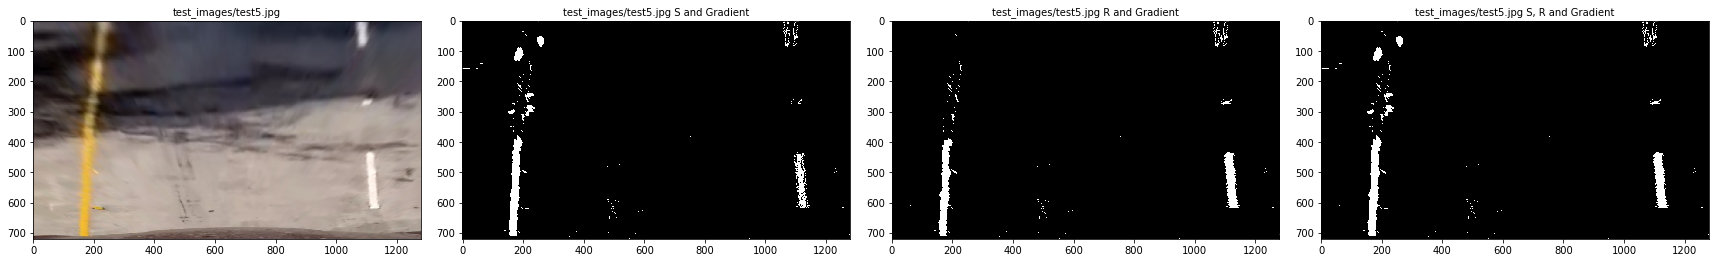

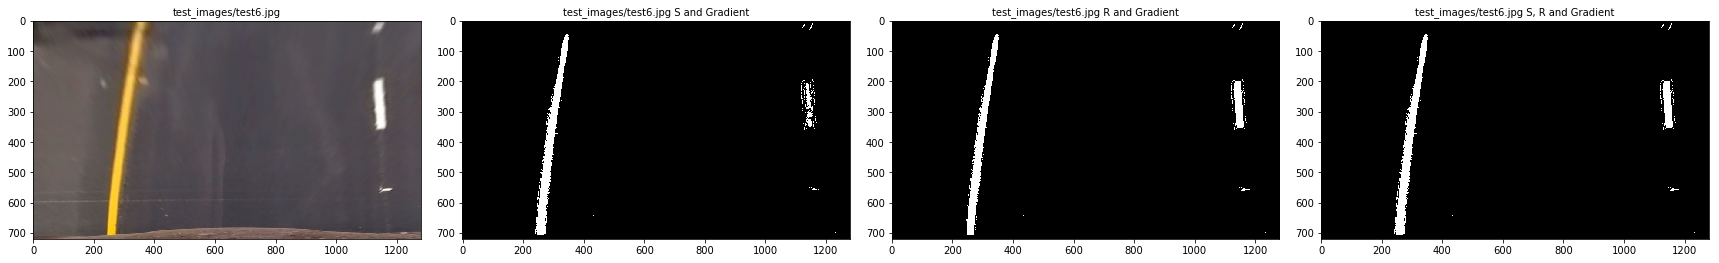

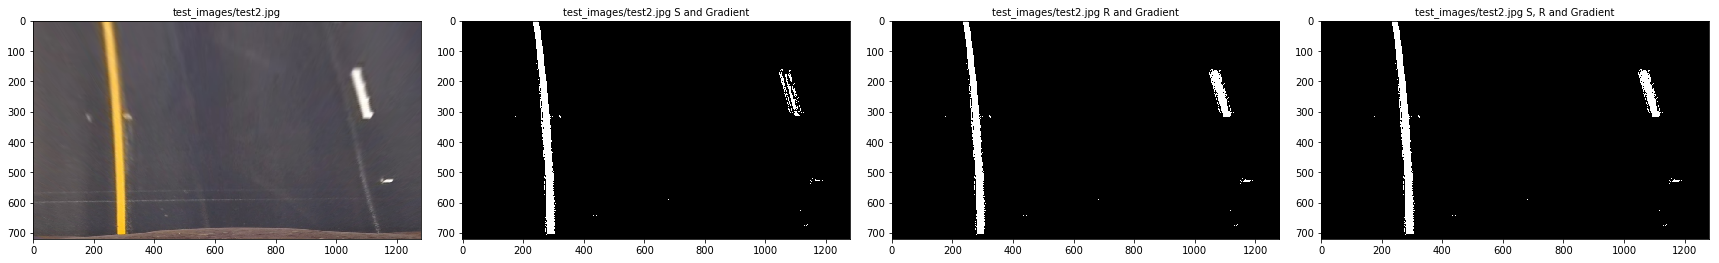

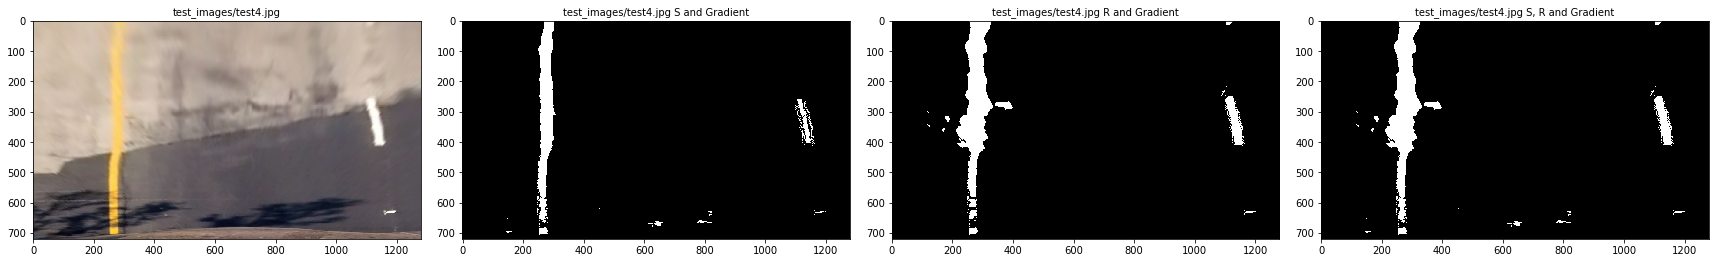

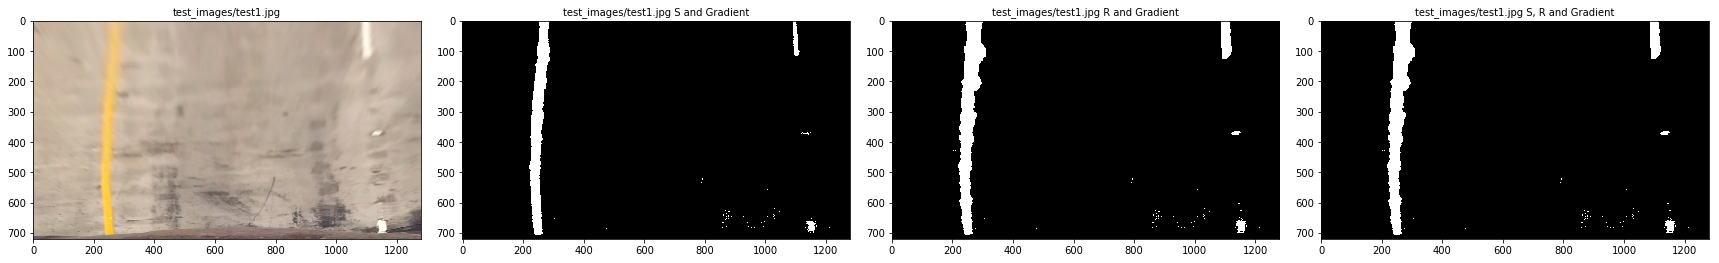

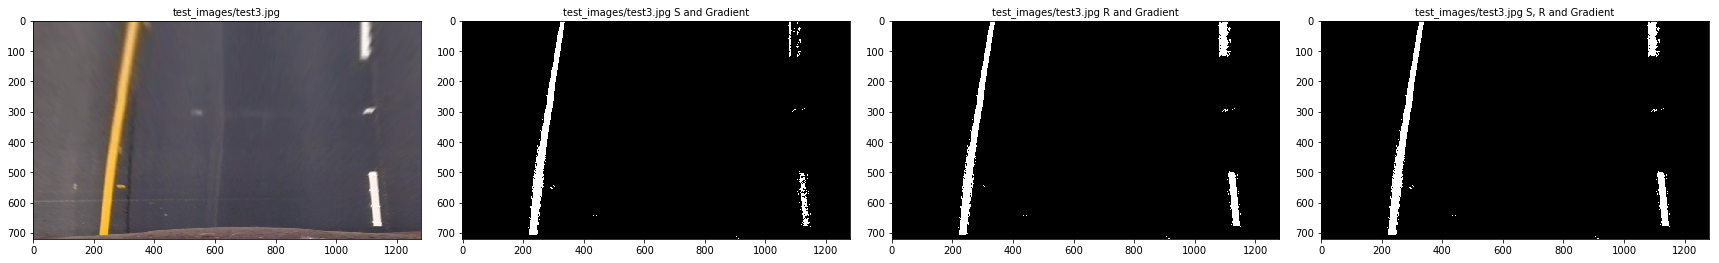

In [4]:
def Color_Thresholds(image, s_thresh=(160, 255), r_thresh = (220, 255), sx_thresh=(60, 80)):
    warped = perspective_transform(image)
    img = np.copy(warped)
    
    #R channel
    r_channel = img[:, :, 0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0])&(r_channel <= r_thresh[1])] = 1
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1    
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    
    # Combine the S and SX thresholds
    combined_binary_S_SX = np.zeros_like(sxbinary)
    combined_binary_S_SX[(s_binary == 1) | (sxbinary == 1)] = 1 
    
    # Combine the R and SX thresholds
    combined_binary_R_SX = np.zeros_like(sxbinary)
    combined_binary_R_SX[(r_binary == 1) | (sxbinary == 1) ] = 1     

    # Combine the S, R and SX thresholds
    combined_binary_S_R_SX = np.zeros_like(sxbinary)
    combined_binary_S_R_SX[(s_binary == 1) | (r_binary == 1) | (sxbinary == 1) ] = 1 
    return warped, combined_binary_S_SX, combined_binary_R_SX, combined_binary_S_R_SX

testImages = glob.glob('test_images/test*.jpg')
for fname in testImages:
    tImg = mpimg.imread(fname)    
    warped, combined_binary_S_SX, combined_binary_R_SX, combined_binary_S_R_SX = Color_Thresholds(tImg)
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (24, 9))
    f.tight_layout()
    
    ax1.imshow(warped)
    ax1.set_title(fname, fontsize=10)
    ax2.imshow(combined_binary_S_SX, cmap='gray')
    ax2.set_title(fname+' S and Gradient', fontsize=10) 
    ax3.imshow(combined_binary_R_SX, cmap='gray')
    ax3.set_title(fname+' R and Gradient', fontsize=10) 
    ax4.imshow(combined_binary_S_R_SX, cmap='gray')
    ax4.set_title(fname+' S, R and Gradient', fontsize=10)     

### Find lane lines

/home/lins/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


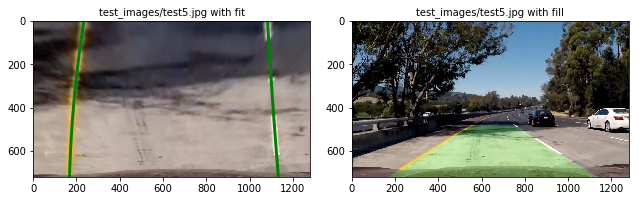

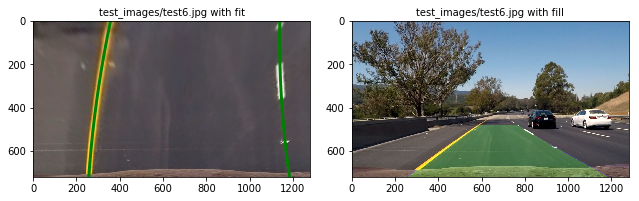

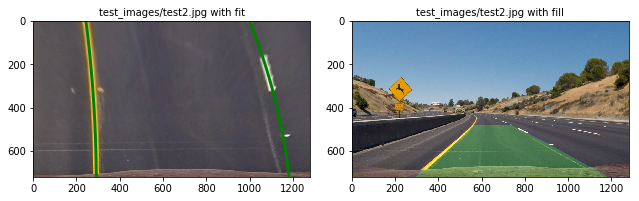

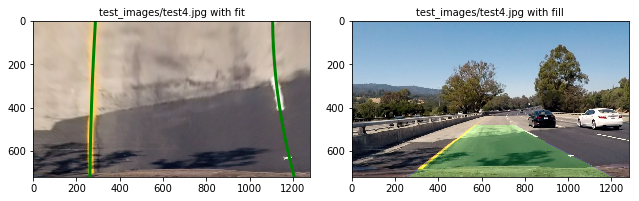

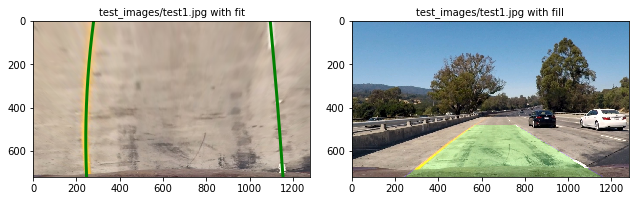

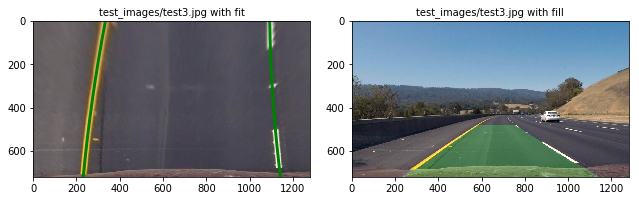

In [5]:

invM = cv2.getPerspectiveTransform(dst, src)

testImages = glob.glob('test_images/test*.jpg')

for fname in testImages:
    tImg = mpimg.imread(fname)    
    warped, combined_binary_S_SX, combined_binary_R_SX, binary_warped = Color_Thresholds(tImg)
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255    
    #plt.plot(histogram) 
    #plt.figure()
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    #print (binary_warped.shape)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #print ('current leftx, rightx')
        #print (leftx_current)
        #print (rightx_current)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices

    left_lane_inds = np.concatenate(left_lane_inds)

    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)

    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)    
    #plt.figure()
  

    # Create an image to draw on and an image to show the selection window
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))    
  
    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    leftx = left_fitx
    rightx = right_fitx
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
       
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 20)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, invM, (binary_warped.shape[1], binary_warped.shape[0]))
    result = cv2.addWeighted(tImg, 1, newwarp, 0.2, 0)
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 6))
    f.tight_layout()
    ax1.imshow(warped)
    ax1.plot(left_fitx, ploty, color='green', linewidth=3)
    ax1.plot(right_fitx, ploty, color='green', linewidth=3)
    ax1.set_title(fname+' with fit', fontsize=10)
    ax2.imshow(result)
    ax2.set_title(fname+' with fill', fontsize=10) 
      

### Video Pipeline

In [51]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  

        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0.0 
 
        self.fitx = []
        
        self.diffs = np.array([0,0,0], dtype='float')
        #average of last five frames
        self.avg_diffs = np.array([0,0,0], dtype='float')

        #failed times
        self.counter_failed = 0
        
        self.bFirst5GoodFrames = False
        self.iCounterGood = 0 #consecutive good frame count 
    


def video_advanced_lane_finding(image):
    tImg = image    
    warped, combined_binary_S_SX, combined_binary_R_SX, binary_warped = Color_Thresholds(tImg)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])  
        
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
        
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50    
    
    left_sum = []
    right_sum = []
    
    
    if Left.bFirst5GoodFrames == True and Left.detected == True and Left.counter_failed < 4:
        #print ('in left')        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            yval = (win_y_low + win_y_high) / 2.0

            leftx_current = Left.current_fit[0]*yval**2 + Left.current_fit[1]*yval + Left.current_fit[2]

            win_xleft_low = leftx_current - margin/10
            win_xleft_high = leftx_current + margin/10

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
        left_sum = np.concatenate(left_lane_inds)
        #print (good_left_inds)
            
    if Left.bFirst5GoodFrames == True and Right.detected == True and Left.counter_failed < 3:
        # Step through the windows one by one
        #print ('in right')
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            yval = (win_y_low + win_y_high) / 2.0
            rightx_current = Right.current_fit[0]*yval**2 + Right.current_fit[1]*yval + Right.current_fit[2]

            win_xright_low = rightx_current - margin/10
            win_xright_high = rightx_current + margin/10
            
            # Identify the nonzero pixels in x and y within the window
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

          
            # Append these indices to the lists
            right_lane_inds.append(good_right_inds)
        right_sum = np.concatenate(right_lane_inds)
        #print (right_sum)                      
    if np.sum(left_sum) == 0 or np.sum(right_sum) == 0:
        
        print ('window search')
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines    
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height

            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    plotTesty = np.array([0., binary_warped.shape[0] / 2, binary_warped.shape[0]])
    #print (plotTesty)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    left_testx = left_fit[0]*plotTesty**2 + left_fit[1]*plotTesty + left_fit[2]
    right_testx = right_fit[0]*plotTesty**2 + right_fit[1]*plotTesty + right_fit[2]
    diffs = right_testx - left_testx
    #print (diffs)


    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    leftx = left_fitx
    rightx = right_fitx
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    iRetFlag = 0 
    #0 Good curves
    #1 Curvature changes too much
    print (Left.counter_failed)
    if Left.radius_of_curvature > 0 and Right.radius_of_curvature > 0:

        #check curvature
        ratioL = math.fabs(left_curverad - Left.radius_of_curvature) / Left.radius_of_curvature
        ratioR = math.fabs(right_curverad - Right.radius_of_curvature) / Right.radius_of_curvature
        #print (ratioL)
        #print (ratioR)
        if(ratioL > 2 or ratioR > 2):
            iRetFlag = 0
        #check lane parallel by check 3 differences
        if np.count_nonzero(Left.diffs) == 3 and iRetFlag == 0:
            ratioDiff0 = math.fabs(Left.diffs[0] - diffs[0]) / Left.diffs[0]
            ratioDiff1 = math.fabs(Left.diffs[1] - diffs[1]) / Left.diffs[1]
            ratioDiff2 = math.fabs(Left.diffs[2] - diffs[2]) / Left.diffs[2]
            print ('ratio to last: {} {} {}'.format(ratioDiff0, ratioDiff1, ratioDiff2))
            #print (ratioDiff0)
            #print (ratioDiff1)
            #print (ratioDiff2)
            if(ratioDiff0 > 0.08 or ratioDiff1 > 0.08 or ratioDiff2 > 0.08):
                iRetFlag = 2 #bad frame
            elif (ratioDiff0 > 0.04 or ratioDiff1 > 0.04 or ratioDiff2 > 0.04):
                iRetFlag = 1 #ok frame
           
            if(Left.counter_failed > 2):#allow loss of 3 frames only, otherwise rego window search
                #print ('ratio to last: {} {} {}'.format(ratioDiff0, ratioDiff1, ratioDiff2))
                ratioDiff0 = math.fabs(Left.avg_diffs[0] - diffs[0]) / Left.avg_diffs[0]
                ratioDiff1 = math.fabs(Left.avg_diffs[1] - diffs[1]) / Left.avg_diffs[1]
                ratioDiff2 = math.fabs(Left.avg_diffs[2] - diffs[2]) / Left.avg_diffs[2]  
                print ('ratio to avg: {} {} {}'.format(ratioDiff0, ratioDiff1, ratioDiff2))                
                if (ratioDiff0 < 0.2 and ratioDiff1 < 0.2 and ratioDiff2 < 0.2):
                    iRetFlag = -1
        if (iRetFlag < 2): #good curves
            Left.radius_of_curvature = left_curverad
            Right.radius_of_curvature = right_curverad
            Left.current_fit = left_fit
            Right.current_fit = right_fit

            Left.detected = True
            Right.detected = True
            Left.counter_failed = 0
            Left.avg_diffs = (Left.avg_diffs * 4 + diffs) / 5.0            
            if(iRetFlag == 0):
                Left.diffs = diffs                
                Left.fitx = left_fitx
                Right.fitx = right_fitx
                Left.iCounterGood = Left.iCounterGood + 1;
                print ('good frame')
            elif (iRetFlag == 1):
                Left.diffs = Left.avg_diffs 
                Left.fitx = (Left.fitx * 4 + left_fitx) / 5.0 
                Right.fitx = (Right.fitx * 4 + right_fitx) / 5.0 
                Left.iCounterGood = 0; #start again to find best first 5
                print ('ok frame')
            else:
                Left.diffs = Left.avg_diffs 
                Left.fitx = (Left.fitx * 9 + left_fitx) / 10.0 
                Right.fitx = (Right.fitx * 9 + right_fitx) / 10.0     
                Left.iCounterGood = 0; #start again to find best first 5
                print ('new frame')                
        else:
            #unsuccessful
            Left.detected = False
            Right.detected = False
            Left.counter_failed = Left.counter_failed + 1
            #use last successful ones
            left_fitx = Left.fitx
            right_fitx = Right.fitx
            Left.iCounterGood = 0; #start again to find best first 5
            print ('failed frame {}'.format(iRetFlag))
           
                
    else:
        Left.radius_of_curvature = left_curverad
        Right.radius_of_curvature = right_curverad
        Left.current_fit = left_fit
        Right.current_fit = right_fit
        Left.fitx = left_fitx
        Right.fitx = right_fitx
        Left.diffs = diffs
        Left.avg_diffs = diffs
        Left.detected = True
        Right.detected = True  
        Left.iCounterGood = Left.iCounterGood + 1
    
    if(Left.bFirst5GoodFrames == False and Left.iCounterGood > 5):
        print ('Found first 5 good frames!')
        Left.bFirst5GoodFrames = True
    
    left_fitx = Left.fitx
    right_fitx = Right.fitx

    
    center = abs(640 - (left_fitx[-1] + right_fitx[-1]) / 2.0 ) * xm_per_pix
    #print((left_fitx[-1] + right_fitx[-1]) / 2.0)
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #print (left_fitx)
    #print (ploty)
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 20)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, invM, (binary_warped.shape[1], binary_warped.shape[0]))
    result = cv2.addWeighted(tImg, 1, newwarp, 0.2, 0)
    # Debug code:
    #if iRetFlag == 2:
    #    cv2.putText(result, 'Unsuccessful lane detection!', (120,80), fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 5)    
    #elif iRetFlag == 1:
    #    cv2.putText(result, 'Lane detection OK!', (120,80), fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 5)  
    #elif iRetFlag == -1:
    #    cv2.putText(result, 'Lane detection New Search!', (120,80), fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 5)         

    cv2.putText(result, 'Car is {:.3f}m off the lane center'.format(center), (80,80), fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 4)         

    cv2.putText(result, 'Lane radius of curvature {}m'.format(int((Left.radius_of_curvature+Right.radius_of_curvature)/2)), 
                (80,140),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 4)     
    return result

### Test pipeline

window search
0


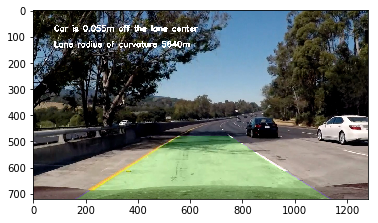

In [54]:
testImages = glob.glob('test_images/test*.jpg')
Left = Line()
Right = Line()
fname = testImages[0]
tImg = mpimg.imread(fname) 
result = video_advanced_lane_finding(tImg)
plt.imshow(result)


### Call video processing pipeline

In [48]:
from moviepy.editor import VideoFileClip
import math
Left = Line()
Right = Line()

video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_advanced_lane_finding) 
white_clip.write_videofile(video_output, audio=False)

window search
0
[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4



  0%|          | 1/1261 [00:04<1:33:43,  4.46s/it]

window search
0
ratio to last: 0.0 0.0 0.0
good frame



  0%|          | 2/1261 [00:07<1:26:11,  4.11s/it]

window search
0
ratio to last: 0.026638357582590012 0.00466542153225624 0.010960710701921296
good frame



  0%|          | 3/1261 [00:11<1:24:33,  4.03s/it]

window search
0
ratio to last: 0.006647182613489513 0.0038020456245310133 0.001317500806663436
good frame



  0%|          | 4/1261 [00:15<1:24:53,  4.05s/it]

window search
0
ratio to last: 0.005633977119241661 0.0038788235542662696 0.0017597723084009573
good frame



  0%|          | 5/1261 [00:19<1:24:13,  4.02s/it]

window search
0
ratio to last: 7.086076914769272e-05 0.001328691252844554 0.0001253215094855402
good frame
Found first 5 good frames!



  0%|          | 6/1261 [00:23<1:25:53,  4.11s/it]

0
ratio to last: 0.004553200694252201 0.0015493620570179209 4.0771516419702804e-05
good frame



  1%|          | 7/1261 [00:28<1:26:06,  4.12s/it]

0
ratio to last: 7.904286470089382e-06 0.0010777297521418004 0.001916209228516133
good frame



  1%|          | 8/1261 [00:31<1:23:57,  4.02s/it]

0
ratio to last: 0.00816510617739591 0.0026107799942905784 0.009003428151028201
good frame



  1%|          | 9/1261 [00:35<1:23:08,  3.98s/it]

0
ratio to last: 0.03564784814908247 0.004013645963083851 0.02606688162418725
good frame



  1%|          | 10/1261 [00:39<1:20:30,  3.86s/it]

0
ratio to last: 0.0015604354596541069 0.0027066006122246538 0.01312345426748263
good frame



  1%|          | 11/1261 [00:43<1:19:49,  3.83s/it]

0
ratio to last: 0.00836558526501314 0.0017080496148796128 0.010201993379596652
good frame



  1%|          | 12/1261 [00:46<1:19:51,  3.84s/it]

0
ratio to last: 0.019541387061257527 0.005174561002489875 0.0034021583039703603
good frame



  1%|          | 13/1261 [00:51<1:21:05,  3.90s/it]

0
ratio to last: 0.00830984040630723 0.0022160914108531257 0.0030156411982405697
good frame



  1%|          | 14/1261 [00:54<1:21:29,  3.92s/it]

0
ratio to last: 0.0025069154036045137 0.002356384416058717 0.014167188030520748
good frame



  1%|          | 15/1261 [00:59<1:23:06,  4.00s/it]

0
ratio to last: 0.0014961068029611003 0.005495016743567641 0.0021337849048037563
good frame



  1%|▏         | 16/1261 [01:03<1:25:38,  4.13s/it]

0
ratio to last: 0.023717921853842052 0.0009478765717812492 0.01606759926247556
good frame



  1%|▏         | 17/1261 [01:08<1:27:41,  4.23s/it]

0
ratio to last: 0.03416327646606184 0.010707442114710218 0.0030653972012920135
good frame



  1%|▏         | 18/1261 [01:12<1:29:07,  4.30s/it]

0
ratio to last: 0.02085594265536284 0.004482891207831285 0.0039164531305291034
good frame



  2%|▏         | 19/1261 [01:16<1:29:46,  4.34s/it]

0
ratio to last: 0.007620745632809472 0.00020503697397503763 4.396721494183701e-05
good frame



  2%|▏         | 20/1261 [01:21<1:30:45,  4.39s/it]

0
ratio to last: 0.004877145862670131 0.00042818559931076793 0.0016336389336298093
good frame



  2%|▏         | 21/1261 [01:25<1:30:38,  4.39s/it]

0
ratio to last: 0.033644522895726336 0.003866198589912158 0.038129556569480326
good frame



  2%|▏         | 22/1261 [01:30<1:30:09,  4.37s/it]

0
ratio to last: 0.0035696056797939464 0.007049512713785395 0.025098893333042
good frame



  2%|▏         | 23/1261 [01:34<1:29:04,  4.32s/it]

0
ratio to last: 0.005438953104566277 0.009241885914170462 0.002327788350548242
good frame



  2%|▏         | 24/1261 [01:38<1:30:15,  4.38s/it]

0
ratio to last: 0.003990218353918263 0.0036242889411412615 0.012221512757973856
good frame



  2%|▏         | 25/1261 [01:43<1:31:18,  4.43s/it]

0
ratio to last: 0.025223101611203436 0.002244126077290358 0.0024069014616985274
good frame



  2%|▏         | 26/1261 [01:47<1:31:12,  4.43s/it]

0
ratio to last: 0.021684271435953688 0.00440165549884349 0.0018939791853488392
good frame



  2%|▏         | 27/1261 [01:52<1:31:12,  4.44s/it]

0
ratio to last: 0.00731850631911648 0.006639632329290217 0.0012958042095526751
good frame



  2%|▏         | 28/1261 [01:56<1:29:37,  4.36s/it]

0
ratio to last: 0.014001636158811604 0.006388175655973756 0.008197820360401576
good frame



  2%|▏         | 29/1261 [02:00<1:27:01,  4.24s/it]

0
ratio to last: 0.0034262057491485313 0.002302325930276029 0.0050346255525647995
good frame



  2%|▏         | 30/1261 [02:04<1:24:55,  4.14s/it]

0
ratio to last: 0.010025683602794433 0.002136362539291498 0.002152992111823018
good frame



  2%|▏         | 31/1261 [02:08<1:25:59,  4.19s/it]

0
ratio to last: 0.012083457895344128 0.004058863231422057 0.0021485504621444424
good frame



  3%|▎         | 32/1261 [02:12<1:24:30,  4.13s/it]

0
ratio to last: 0.022180629639395613 0.001378167944816485 0.001521820136681381
good frame



  3%|▎         | 33/1261 [02:16<1:22:32,  4.03s/it]

0
ratio to last: 0.0005969623339416459 0.0026824264604300018 0.002560847973720779
good frame



  3%|▎         | 34/1261 [02:20<1:25:27,  4.18s/it]

0
ratio to last: 0.024591074505584957 0.005163562997059008 0.03176706559876734
good frame



  3%|▎         | 35/1261 [02:25<1:26:50,  4.25s/it]

0
ratio to last: 0.013071291014327626 0.002137751585042434 0.01366654295929362
good frame



  3%|▎         | 36/1261 [02:28<1:22:16,  4.03s/it]

0
ratio to last: 0.026590050539975544 0.006302522969175891 0.003716016151838434
good frame



  3%|▎         | 37/1261 [02:32<1:19:05,  3.88s/it]

0
ratio to last: 0.02747445349885035 0.0035867266083914923 0.0057211638205802474
good frame



  3%|▎         | 38/1261 [02:36<1:23:06,  4.08s/it]

0
ratio to last: 0.028272228337875946 0.0020515433544469742 0.03042990073660027
good frame



  3%|▎         | 39/1261 [02:41<1:24:57,  4.17s/it]

0
ratio to last: 0.005076302201946573 0.005420675715536807 0.003511904983101435
good frame



  3%|▎         | 40/1261 [02:45<1:25:12,  4.19s/it]

0
ratio to last: 0.00447409534883201 0.0040971259120554625 0.005286583766735423
good frame



  3%|▎         | 41/1261 [02:48<1:19:46,  3.92s/it]

0
ratio to last: 0.01227735063414923 0.0003376780566496669 0.007821449797624655
good frame



  3%|▎         | 42/1261 [02:51<1:14:25,  3.66s/it]

0
ratio to last: 0.00019750143416945033 0.004191282925025261 0.0034805475708921583
good frame



  3%|▎         | 43/1261 [02:55<1:16:00,  3.74s/it]

0
ratio to last: 0.004798345394411909 0.004142558495796368 0.00029455053906582077
good frame



  3%|▎         | 44/1261 [02:59<1:16:25,  3.77s/it]

0
ratio to last: 0.01263396149548885 0.001363895138863042 0.0011446702487335491
good frame



  4%|▎         | 45/1261 [03:03<1:14:07,  3.66s/it]

0
ratio to last: 0.01628303278400914 0.0010162602791775053 0.0025556031485230446
good frame



  4%|▎         | 46/1261 [03:06<1:10:15,  3.47s/it]

0
ratio to last: 0.0039000131141347623 0.00650358896375382 0.014617176950621803
good frame



  4%|▎         | 47/1261 [03:09<1:09:19,  3.43s/it]

0
ratio to last: 0.02674167285709465 0.0020853567751696325 0.005914859089381705
good frame



  4%|▍         | 48/1261 [03:13<1:13:28,  3.63s/it]

0
ratio to last: 0.0043881154503697265 0.0012473867998325572 0.009517631756890651
good frame



  4%|▍         | 49/1261 [03:17<1:15:32,  3.74s/it]

0
ratio to last: 0.0025903554378099622 0.0037127004895557278 0.018630229929787665
good frame



  4%|▍         | 50/1261 [03:22<1:19:51,  3.96s/it]

0
ratio to last: 0.00014749113249214478 0.0018861594288093033 0.004036725419015049
good frame



  4%|▍         | 51/1261 [03:26<1:20:33,  3.99s/it]

0
ratio to last: 0.021596871406241468 0.0003265725941311333 0.005290555079096736
good frame



  4%|▍         | 52/1261 [03:29<1:15:45,  3.76s/it]

0
ratio to last: 0.015986426845534064 0.001487312615310045 0.009568486753770278
good frame



  4%|▍         | 53/1261 [03:33<1:17:49,  3.87s/it]

0
ratio to last: 0.0024316140752093703 0.004670861251898298 0.003179699402908478
good frame



  4%|▍         | 54/1261 [03:37<1:21:23,  4.05s/it]

0
ratio to last: 0.007828222965832146 0.0013939924001047524 0.0017138593827929973
good frame



  4%|▍         | 55/1261 [03:42<1:22:19,  4.10s/it]

0
ratio to last: 0.0012035125310853351 0.0003976388683108174 0.0010037401666856676
good frame



  4%|▍         | 56/1261 [03:46<1:23:22,  4.15s/it]

0
ratio to last: 0.0015025012474367727 0.004322152577415297 0.002757560765380046
good frame



  5%|▍         | 57/1261 [03:50<1:21:57,  4.08s/it]

0
ratio to last: 0.006074825107798352 0.004498322236868444 0.0007921193814615513
good frame



  5%|▍         | 58/1261 [03:53<1:16:51,  3.83s/it]

0
ratio to last: 0.002066892663793965 0.002025381571764825 0.003569321649401113
good frame



  5%|▍         | 59/1261 [03:57<1:17:52,  3.89s/it]

0
ratio to last: 0.027298676836099565 0.00727595723198678 0.039558032453243595
good frame



  5%|▍         | 60/1261 [04:00<1:14:06,  3.70s/it]

0
ratio to last: 0.03845418833022103 0.004026525090132108 0.03184832065566446
good frame



  5%|▍         | 61/1261 [04:04<1:11:07,  3.56s/it]

0
ratio to last: 0.018227583799538677 0.004751184835472881 0.010992354636047457
good frame



  5%|▍         | 62/1261 [04:07<1:09:26,  3.47s/it]

0
ratio to last: 0.009800470919908112 0.005427979321864745 0.008058810841740857
good frame



  5%|▍         | 63/1261 [04:11<1:12:50,  3.65s/it]

0
ratio to last: 0.03414612791432796 0.0006838204186810778 0.014812241750307346
good frame



  5%|▌         | 64/1261 [04:15<1:13:52,  3.70s/it]

0
ratio to last: 0.0008083673990882693 0.00033359987122630086 0.007325316931012356
good frame



  5%|▌         | 65/1261 [04:19<1:16:35,  3.84s/it]

0
ratio to last: 0.0033167480441015575 0.003512493689366198 0.012284334855896964
good frame



  5%|▌         | 66/1261 [04:23<1:17:41,  3.90s/it]

0
ratio to last: 0.005384260144407424 0.0012084355494737563 0.0042828629130439375
good frame



  5%|▌         | 67/1261 [04:27<1:19:30,  4.00s/it]

0
ratio to last: 0.0004280131175386791 0.003372472622700947 0.001900727607591944
good frame



  5%|▌         | 68/1261 [04:31<1:16:01,  3.82s/it]

0
ratio to last: 0.0026713946344808443 0.004675682124845259 0.0006528941539137602
good frame



  5%|▌         | 69/1261 [04:34<1:13:43,  3.71s/it]

0
ratio to last: 0.002200020832610898 0.003188179575760134 0.0016274829874566444
good frame



  6%|▌         | 70/1261 [04:38<1:15:50,  3.82s/it]

0
ratio to last: 0.0066228056163781315 0.000812665860828105 0.00044111097165897066
good frame



  6%|▌         | 71/1261 [04:42<1:14:47,  3.77s/it]

0
ratio to last: 0.03690044235955869 0.0022901786400583335 0.05641861008890137
ok frame



  6%|▌         | 72/1261 [04:46<1:18:52,  3.98s/it]

0
ratio to last: 0.029701782383085764 0.00541437998459063 0.03115328688163395
good frame



  6%|▌         | 73/1261 [04:50<1:17:11,  3.90s/it]

0
ratio to last: 0.019985247056200826 0.0008418445589867734 0.005162437325997171
good frame



  6%|▌         | 74/1261 [04:54<1:15:08,  3.80s/it]

0
ratio to last: 0.00027180705016265083 0.00020127973003229466 0.01989724159037236
good frame



  6%|▌         | 75/1261 [04:57<1:15:28,  3.82s/it]

0
ratio to last: 0.028010066944805435 0.005013569732395436 0.00595293275437401
good frame



  6%|▌         | 76/1261 [05:01<1:14:48,  3.79s/it]

0
ratio to last: 0.01350520494077283 0.0005265458861679109 0.01081124173153877
good frame



  6%|▌         | 77/1261 [05:05<1:14:40,  3.78s/it]

0
ratio to last: 0.11814177248522612 0.006763758426930671 0.05321755622349461
failed frame 2



  6%|▌         | 78/1261 [05:09<1:16:10,  3.86s/it]

window search
1
ratio to last: 0.027283267968774217 0.030567098335916167 0.03309944903115192
good frame



  6%|▋         | 79/1261 [05:12<1:11:56,  3.65s/it]

0
ratio to last: 0.0033019592452494446 0.0012183579890044291 0.002269148218281336
good frame



  6%|▋         | 80/1261 [05:16<1:13:43,  3.75s/it]

0
ratio to last: 0.0013728717367296967 0.0006382749689259773 0.00041767011198719646
good frame



  6%|▋         | 81/1261 [05:20<1:17:31,  3.94s/it]

0
ratio to last: 0.006931702429675142 0.00068694625977242 0.0011216518975066005
good frame



  7%|▋         | 82/1261 [05:25<1:18:16,  3.98s/it]

0
ratio to last: 0.005370189040271397 0.007481786733260321 0.00015663350521077335
good frame



  7%|▋         | 83/1261 [05:28<1:15:49,  3.86s/it]

0
ratio to last: 0.008266037769394326 0.003675551774917455 0.000696962201856235
good frame



  7%|▋         | 84/1261 [05:32<1:17:19,  3.94s/it]

0
ratio to last: 0.000489537592352314 0.009637714460806988 0.0071077248642893226
good frame



  7%|▋         | 85/1261 [05:35<1:13:02,  3.73s/it]

0
ratio to last: 0.013529759795727103 0.0013533523200137333 0.0012132710830381876
good frame



  7%|▋         | 86/1261 [05:39<1:13:27,  3.75s/it]

0
ratio to last: 0.002238238210770838 0.003000769892199492 0.004593601333787224
good frame



  7%|▋         | 87/1261 [05:43<1:14:21,  3.80s/it]

0
ratio to last: 0.012699954522433735 0.0031047740243003844 0.00755246514773614
good frame



  7%|▋         | 88/1261 [05:47<1:14:20,  3.80s/it]

0
ratio to last: 0.00012416098723544105 0.003667977798130983 0.013414502701221949
good frame



  7%|▋         | 89/1261 [05:51<1:12:45,  3.73s/it]

0
ratio to last: 0.007708881574099747 0.006176380910204724 0.016344052455060733
good frame



  7%|▋         | 90/1261 [05:54<1:10:12,  3.60s/it]

0
ratio to last: 0.01179028199971321 0.007249058209513499 0.0021438269791119375
good frame



  7%|▋         | 91/1261 [05:57<1:10:11,  3.60s/it]

0
ratio to last: 0.0187201198115718 0.003062166802028072 0.0032983366499503113
good frame



  7%|▋         | 92/1261 [06:01<1:12:41,  3.73s/it]

0
ratio to last: 0.01754310919253964 0.0053825803868483525 0.0027568125210670185
good frame



  7%|▋         | 93/1261 [06:05<1:13:38,  3.78s/it]

0
ratio to last: 0.021722831071860092 0.003433505044244744 0.0005153023641000548
good frame



  7%|▋         | 94/1261 [06:09<1:10:57,  3.65s/it]

0
ratio to last: 0.009452638669730555 0.0065748304786764165 0.0005767415766652404
good frame



  8%|▊         | 95/1261 [06:13<1:13:12,  3.77s/it]

0
ratio to last: 0.0030096419723628894 0.004997136362402296 0.0024173298528605393
good frame



  8%|▊         | 96/1261 [06:17<1:16:59,  3.97s/it]

0
ratio to last: 0.02082241658779601 0.0012016503785417848 0.02673006190749036
good frame



  8%|▊         | 97/1261 [06:21<1:15:28,  3.89s/it]

0
ratio to last: 0.0050059055979795875 0.0029827416323260714 0.002115781594464921
good frame



  8%|▊         | 98/1261 [06:24<1:11:43,  3.70s/it]

0
ratio to last: 0.01656044381599935 0.0015229073504942883 0.01122781009589139
good frame



  8%|▊         | 99/1261 [06:29<1:16:12,  3.93s/it]

0
ratio to last: 0.005007499073227886 0.0014019161580424305 0.01674700025090704
good frame



  8%|▊         | 100/1261 [06:32<1:13:23,  3.79s/it]

0
ratio to last: 0.03176598634761024 0.00189229200214556 0.0041785098906072906
good frame



  8%|▊         | 101/1261 [06:36<1:16:31,  3.96s/it]

0
ratio to last: 0.013998644842407202 0.00024414776434642833 0.003553159128735282
good frame



  8%|▊         | 102/1261 [06:40<1:12:27,  3.75s/it]

0
ratio to last: 0.003441558214787968 0.003205259345365661 0.02460146870603143
good frame



  8%|▊         | 103/1261 [06:43<1:09:11,  3.58s/it]

0
ratio to last: 0.03386236499629796 0.0017073438978887176 0.0077232903428739175
good frame



  8%|▊         | 104/1261 [06:46<1:07:53,  3.52s/it]

0
ratio to last: 0.017504257785696593 0.0006894490624590331 0.004140657390260335
good frame



  8%|▊         | 105/1261 [06:50<1:07:16,  3.49s/it]

0
ratio to last: 0.0028859461683632135 0.004440066180177032 0.0007829000042683001
good frame



  8%|▊         | 106/1261 [06:53<1:06:50,  3.47s/it]

0
ratio to last: 0.005793850426348393 0.005644149628178402 0.0013087568053363617
good frame



  8%|▊         | 107/1261 [06:57<1:06:31,  3.46s/it]

0
ratio to last: 0.00486710229835627 0.010552003833720071 0.0012864076608297506
good frame



  9%|▊         | 108/1261 [07:00<1:04:53,  3.38s/it]

0
ratio to last: 1.4903300324250706e-05 0.00421257077925092 0.0018932876806566693
good frame



  9%|▊         | 109/1261 [07:03<1:05:52,  3.43s/it]

0
ratio to last: 0.008825669116422307 0.002851455837396948 0.013616418033167488
good frame



  9%|▊         | 110/1261 [07:06<1:03:54,  3.33s/it]

0
ratio to last: 0.0034354620386479787 0.0015317658662044793 0.005602669408925604
good frame



  9%|▉         | 111/1261 [07:10<1:05:19,  3.41s/it]

0
ratio to last: 0.005979841061824143 0.00029744688948872387 0.0031392021937169078
good frame



  9%|▉         | 112/1261 [07:14<1:06:14,  3.46s/it]

0
ratio to last: 0.0025854510738216514 0.0030457672207734273 0.0020336750536834804
good frame



  9%|▉         | 113/1261 [07:17<1:07:01,  3.50s/it]

0
ratio to last: 0.002550017734586185 0.001785394618063102 0.0024356151650025484
good frame



  9%|▉         | 114/1261 [07:21<1:08:34,  3.59s/it]

0
ratio to last: 0.004888753071146435 0.0016109264536075234 0.0053436020816802765
good frame



  9%|▉         | 115/1261 [07:24<1:08:05,  3.56s/it]

0
ratio to last: 0.008781374439511975 0.000998895986599931 0.004449576230856785
good frame



  9%|▉         | 116/1261 [07:28<1:10:20,  3.69s/it]

0
ratio to last: 0.0027495257423870833 0.006555424002754517 0.00263286097571673
good frame



  9%|▉         | 117/1261 [07:32<1:10:32,  3.70s/it]

0
ratio to last: 0.00021496370620995367 0.002823733863585614 0.0007046994738666657
good frame



  9%|▉         | 118/1261 [07:36<1:11:18,  3.74s/it]

0
ratio to last: 0.004400083831356355 0.0010928651678113676 0.003038428110694822
good frame



  9%|▉         | 119/1261 [07:40<1:10:30,  3.70s/it]

0
ratio to last: 0.0005900781378727946 0.0011566420149410857 0.0013863438718709064
good frame



 10%|▉         | 120/1261 [07:43<1:09:51,  3.67s/it]

0
ratio to last: 0.015448320554383024 8.721747643185302e-06 0.0023625490763755303
good frame



 10%|▉         | 121/1261 [07:47<1:08:40,  3.61s/it]

0
ratio to last: 0.005470973351202134 0.0030681227987569937 0.004998183809680168
good frame



 10%|▉         | 122/1261 [07:51<1:09:42,  3.67s/it]

0
ratio to last: 0.023485289785935563 0.004049752036077749 0.021230283502807697
good frame



 10%|▉         | 123/1261 [07:54<1:09:51,  3.68s/it]

0
ratio to last: 0.016308688829287973 9.281249661434904e-05 0.007589226342180754
good frame



 10%|▉         | 124/1261 [07:58<1:09:48,  3.68s/it]

0
ratio to last: 0.010657949946332925 0.003421015104913842 0.008952767119436243
good frame



 10%|▉         | 125/1261 [08:02<1:10:00,  3.70s/it]

0
ratio to last: 0.016369505395579163 0.002590722180620824 0.0028347177164756814
good frame



 10%|▉         | 126/1261 [08:06<1:11:25,  3.78s/it]

0
ratio to last: 0.027496758926659787 0.004309477600043961 0.037665854579770494
good frame



 10%|█         | 127/1261 [08:09<1:07:15,  3.56s/it]

0
ratio to last: 0.01628460014924395 0.000715395995323822 0.0114837405599536
good frame



 10%|█         | 128/1261 [08:12<1:07:35,  3.58s/it]

0
ratio to last: 0.00781961922101405 0.0015887409995553297 0.00337207749448122
good frame



 10%|█         | 129/1261 [08:16<1:06:08,  3.51s/it]

0
ratio to last: 0.015276050020937751 0.0019181154179470242 0.00577529649576885
good frame



 10%|█         | 130/1261 [08:19<1:07:27,  3.58s/it]

0
ratio to last: 0.0005825654983907362 0.004046249215293513 0.002584267537426437
good frame



 10%|█         | 131/1261 [08:23<1:09:45,  3.70s/it]

0
ratio to last: 0.004364740129712351 0.0008364784026060896 0.0010485362694278952
good frame



 10%|█         | 132/1261 [08:28<1:12:27,  3.85s/it]

0
ratio to last: 0.0014143026696852587 0.006414988075025711 0.0011234141124449163
good frame



 11%|█         | 133/1261 [08:31<1:08:48,  3.66s/it]

0
ratio to last: 0.008814667293992256 0.004864483926897971 0.0005634559782347596
good frame



 11%|█         | 134/1261 [08:34<1:07:48,  3.61s/it]

0
ratio to last: 0.03542435997173965 0.0019950854314641593 0.04826019972087491
ok frame



 11%|█         | 135/1261 [08:38<1:07:19,  3.59s/it]

0
ratio to last: 0.017097020130368182 0.004687125305717217 0.026888179298650686
good frame



 11%|█         | 136/1261 [08:41<1:04:20,  3.43s/it]

0
ratio to last: 0.012986122078459755 0.003618646802010472 0.012638425867928476
good frame



 11%|█         | 137/1261 [08:44<1:01:46,  3.30s/it]

0
ratio to last: 0.0310716362256929 0.0032668788702614744 0.020471566027915687
good frame



 11%|█         | 138/1261 [08:47<1:01:04,  3.26s/it]

0
ratio to last: 0.05190534987067198 0.0059180525235080555 0.0008595066218234325
ok frame



 11%|█         | 139/1261 [08:50<1:01:36,  3.29s/it]

0
ratio to last: 0.023532695609202934 0.008778971783990728 0.0024222262208063398
good frame



 11%|█         | 140/1261 [08:53<59:51,  3.20s/it]  

0
ratio to last: 0.0163048274035007 0.008656187134411505 0.008216945542012067
good frame



 11%|█         | 141/1261 [08:58<1:06:53,  3.58s/it]

0
ratio to last: 0.004624643362628638 0.0004011907190042276 0.006666088195451893
good frame



 11%|█▏        | 142/1261 [09:02<1:08:24,  3.67s/it]

0
ratio to last: 0.004490542333918933 0.002159299732628893 0.0022439467140332524
good frame



 11%|█▏        | 143/1261 [09:06<1:09:15,  3.72s/it]

0
ratio to last: 0.009113577808623586 0.003312802059515155 0.0020439619778119854
good frame



 11%|█▏        | 144/1261 [09:09<1:09:06,  3.71s/it]

0
ratio to last: 0.009457407579938 0.001012263582931408 0.003035344672770971
good frame



 11%|█▏        | 145/1261 [09:13<1:09:34,  3.74s/it]

0
ratio to last: 6.432147091302045e-06 0.0005184552452823242 0.002315055743404286
good frame



 12%|█▏        | 146/1261 [09:17<1:11:00,  3.82s/it]

0
ratio to last: 0.010663521798105171 0.0016778383576873752 0.0035522396653148796
good frame



 12%|█▏        | 147/1261 [09:21<1:09:52,  3.76s/it]

0
ratio to last: 0.029460851292552374 0.003421177785033031 0.033889635165737786
good frame



 12%|█▏        | 148/1261 [09:24<1:08:28,  3.69s/it]

0
ratio to last: 0.0191064041605695 0.004705013654555385 0.012723265143624131
good frame



 12%|█▏        | 149/1261 [09:28<1:06:31,  3.59s/it]

0
ratio to last: 0.031665370093878105 0.005121893411281342 0.004183945195261426
good frame



 12%|█▏        | 150/1261 [09:31<1:04:51,  3.50s/it]

0
ratio to last: 0.03561938508447884 0.0008917798820727966 0.002938027677296038
good frame



 12%|█▏        | 151/1261 [09:34<1:01:40,  3.33s/it]

0
ratio to last: 0.021062610910541128 0.003548355212850784 0.03522397034347106
good frame



 12%|█▏        | 152/1261 [09:38<1:04:13,  3.48s/it]

0
ratio to last: 0.025533457598985985 0.00046474365701649047 0.015186275233375943
good frame



 12%|█▏        | 153/1261 [09:41<1:06:22,  3.59s/it]

0
ratio to last: 7.050537720738042e-05 0.002661101981783996 0.0029850025131834493
good frame



 12%|█▏        | 154/1261 [09:45<1:06:47,  3.62s/it]

0
ratio to last: 0.008359761370409868 0.0038823877835010108 0.004158248153805874
good frame



 12%|█▏        | 155/1261 [09:49<1:05:51,  3.57s/it]

0
ratio to last: 0.010395291981866608 0.003366775760407123 0.0007728762501273698
good frame



 12%|█▏        | 156/1261 [09:52<1:06:20,  3.60s/it]

0
ratio to last: 0.0018923561371582014 0.00431933947973849 0.002912901915613902
good frame



 12%|█▏        | 157/1261 [09:56<1:06:17,  3.60s/it]

0
ratio to last: 0.0005423238355423742 0.0023888586090390906 0.002936729743506766
good frame



 13%|█▎        | 158/1261 [10:00<1:06:20,  3.61s/it]

0
ratio to last: 0.020041899597965228 7.599935403181893e-05 0.003938757805171569
good frame



 13%|█▎        | 159/1261 [10:03<1:06:41,  3.63s/it]

0
ratio to last: 0.013851342338231713 0.000631244031699947 0.019654973445864355
good frame



 13%|█▎        | 160/1261 [10:07<1:06:39,  3.63s/it]

0
ratio to last: 0.007108169023124222 0.001889486320160913 0.010405726925764533
good frame



 13%|█▎        | 161/1261 [10:11<1:06:51,  3.65s/it]

0
ratio to last: 0.015290229417027292 0.0018349313723502547 0.010653693563966962
good frame



 13%|█▎        | 162/1261 [10:14<1:05:30,  3.58s/it]

0
ratio to last: 0.036881795784448154 0.0031780893551125876 0.016185629693189266
good frame



 13%|█▎        | 163/1261 [10:17<1:03:55,  3.49s/it]

0
ratio to last: 0.03295849219773025 0.004327300294142423 0.0023443787974397503
good frame



 13%|█▎        | 164/1261 [10:21<1:04:47,  3.54s/it]

0
ratio to last: 0.018098331881733792 0.002266458533426037 0.019376339365497444
good frame



 13%|█▎        | 165/1261 [10:25<1:06:14,  3.63s/it]

0
ratio to last: 0.006256775774526902 0.0012741129410443806 0.014703604695405584
good frame



 13%|█▎        | 166/1261 [10:28<1:06:56,  3.67s/it]

0
ratio to last: 0.007947980092365792 0.0045401614274142585 0.0016050151108046944
good frame



 13%|█▎        | 167/1261 [10:32<1:07:14,  3.69s/it]

0
ratio to last: 0.01192187089427336 0.005544896343926562 0.0017293998029267572
good frame



 13%|█▎        | 168/1261 [10:36<1:06:42,  3.66s/it]

0
ratio to last: 0.005620873811744864 0.0011605451064147173 0.000977282564598238
good frame



 13%|█▎        | 169/1261 [10:40<1:07:44,  3.72s/it]

0
ratio to last: 0.008547457572304771 0.0038478614907205473 3.730448327228344e-05
good frame



 13%|█▎        | 170/1261 [10:43<1:03:27,  3.49s/it]

0
ratio to last: 0.016998269847766923 0.0040689171033915445 0.004446960190003854
good frame



 14%|█▎        | 171/1261 [10:46<1:04:13,  3.54s/it]

0
ratio to last: 0.0017789638021975408 0.0028246683026732174 0.0034301162704374337
good frame



 14%|█▎        | 172/1261 [10:50<1:03:28,  3.50s/it]

0
ratio to last: 0.030536037351516776 0.0018717715823311522 0.02261053150746829
good frame



 14%|█▎        | 173/1261 [10:53<1:03:38,  3.51s/it]

0
ratio to last: 0.003202109654492556 0.0026813567096277357 0.012513410384033844
good frame



 14%|█▍        | 174/1261 [10:57<1:03:34,  3.51s/it]

0
ratio to last: 0.0038848636423168405 0.004743109551188943 0.018585189200360366
good frame



 14%|█▍        | 175/1261 [11:01<1:05:27,  3.62s/it]

0
ratio to last: 0.015476037354131821 0.001800359117984725 0.005432407963021313
good frame



 14%|█▍        | 176/1261 [11:04<1:06:49,  3.70s/it]

0
ratio to last: 0.028085843578324304 0.0009532562801299177 0.010164877075332824
good frame



 14%|█▍        | 177/1261 [11:08<1:07:56,  3.76s/it]

0
ratio to last: 0.0023301512577732185 0.008323718968240426 0.02251899702678651
good frame



 14%|█▍        | 178/1261 [11:12<1:05:54,  3.65s/it]

0
ratio to last: 0.010150655384151748 0.0032521118167360627 0.0016100058201660606
good frame



 14%|█▍        | 179/1261 [11:16<1:07:17,  3.73s/it]

0
ratio to last: 0.01747856197337475 0.00789607323113508 0.006349064805907707
good frame



 14%|█▍        | 180/1261 [11:19<1:03:45,  3.54s/it]

0
ratio to last: 0.003200915643377487 0.006653236971366256 0.0006882177583698103
good frame



 14%|█▍        | 181/1261 [11:22<1:03:49,  3.55s/it]

0
ratio to last: 0.01740366008109655 0.005553667290933005 0.0018162007544394385
good frame



 14%|█▍        | 182/1261 [11:26<1:03:09,  3.51s/it]

0
ratio to last: 0.003058041488266022 0.004931597960601328 0.0034566671687717553
good frame



 15%|█▍        | 183/1261 [11:29<1:03:20,  3.53s/it]

0
ratio to last: 0.020123034430145785 0.0013137905105893564 0.00017289176224979719
good frame



 15%|█▍        | 184/1261 [11:33<1:03:05,  3.52s/it]

0
ratio to last: 0.0200410612586193 0.005426959129182263 0.03646928183146805
good frame



 15%|█▍        | 185/1261 [11:36<1:02:26,  3.48s/it]

0
ratio to last: 0.0360325006695873 0.002849104030360814 0.025547914735811566
good frame



 15%|█▍        | 186/1261 [11:40<1:05:50,  3.67s/it]

0
ratio to last: 0.010609455697938914 0.011878058165552112 0.008886196285497328
good frame



 15%|█▍        | 187/1261 [11:44<1:05:54,  3.68s/it]

0
ratio to last: 0.029851363435161156 0.007905356221379596 0.009317684114357112
good frame



 15%|█▍        | 188/1261 [11:47<1:03:50,  3.57s/it]

0
ratio to last: 0.02933713505126582 0.00877415354468059 0.01688172502378784
good frame



 15%|█▍        | 189/1261 [11:50<1:01:01,  3.42s/it]

0
ratio to last: 0.008608059350451534 0.0032985809270755606 0.013045861033551102
good frame



 15%|█▌        | 190/1261 [11:54<1:02:01,  3.47s/it]

0
ratio to last: 0.0020365593526918526 0.00569182667409127 0.0028535940624773255
good frame



 15%|█▌        | 191/1261 [11:57<1:00:58,  3.42s/it]

0
ratio to last: 0.03043593992571275 0.002814263275118676 0.014565928174200733
good frame



 15%|█▌        | 192/1261 [12:01<1:00:32,  3.40s/it]

0
ratio to last: 0.02595192633530012 0.0071596087397036365 0.0021216374733209436
good frame



 15%|█▌        | 193/1261 [12:04<1:02:07,  3.49s/it]

0
ratio to last: 0.011130763791000982 0.006331004646741699 0.0028418556285764924
good frame



 15%|█▌        | 194/1261 [12:08<1:00:29,  3.40s/it]

0
ratio to last: 0.005160394010261728 0.0008534001445862841 0.004744318259750146
good frame



 15%|█▌        | 195/1261 [12:11<1:00:48,  3.42s/it]

0
ratio to last: 0.007699818085356064 0.002365278266546516 0.004104316008199786
good frame



 16%|█▌        | 196/1261 [12:15<1:01:40,  3.47s/it]

0
ratio to last: 0.05227629981364531 0.004895887582707711 0.030050553866058906
ok frame



 16%|█▌        | 197/1261 [12:18<59:47,  3.37s/it]  

0
ratio to last: 0.018110554176353356 0.003950268943736138 0.016708115429780027
good frame



 16%|█▌        | 198/1261 [12:21<58:18,  3.29s/it]

0
ratio to last: 0.04726288137766552 0.013548813980384043 0.008163363457116957
ok frame



 16%|█▌        | 199/1261 [12:24<57:30,  3.25s/it]

0
ratio to last: 0.05814778032573049 0.02908735889454051 0.01040518041262417
ok frame



 16%|█▌        | 200/1261 [12:28<59:51,  3.39s/it]

0
ratio to last: 0.06524847925737035 0.030351650360718303 0.006676501468001241
ok frame



 16%|█▌        | 201/1261 [12:31<59:03,  3.34s/it]

0
ratio to last: 0.056058618173040274 0.028980426285533895 0.003942198305478258
ok frame



 16%|█▌        | 202/1261 [12:34<57:50,  3.28s/it]

0
ratio to last: 0.06756633159525713 0.024994106779261286 0.006773684885686452
ok frame



 16%|█▌        | 203/1261 [12:37<57:00,  3.23s/it]

0
ratio to last: 0.04961072435334199 0.016299562745378242 0.006730791554141679
ok frame



 16%|█▌        | 204/1261 [12:41<59:37,  3.38s/it]

0
ratio to last: 0.025186453025336935 0.009981135029882618 0.006868572677261781
good frame



 16%|█▋        | 205/1261 [12:45<1:00:57,  3.46s/it]

0
ratio to last: 0.018183370540989573 9.030235589081345e-05 0.005368829547451674
good frame



 16%|█▋        | 206/1261 [12:48<1:01:19,  3.49s/it]

0
ratio to last: 0.012105788042062604 0.0030837531303255852 0.0024975552757090084
good frame



 16%|█▋        | 207/1261 [12:52<1:04:59,  3.70s/it]

0
ratio to last: 0.030411233422248066 0.0060917979622943565 0.0010330992606627425
good frame



 16%|█▋        | 208/1261 [12:56<1:02:19,  3.55s/it]

0
ratio to last: 0.024165672696982506 0.004336836288429541 0.0217142312560708
good frame



 17%|█▋        | 209/1261 [12:59<1:02:07,  3.54s/it]

0
ratio to last: 0.02670089720731726 0.004742710659041171 0.02057993212360407
good frame



 17%|█▋        | 210/1261 [13:02<1:00:23,  3.45s/it]

0
ratio to last: 0.006342858727702919 0.004396779576960509 0.010538850940196045
good frame



 17%|█▋        | 211/1261 [13:06<1:01:17,  3.50s/it]

0
ratio to last: 0.032240434237764716 0.0034085590086156813 0.006150306722310095
good frame



 17%|█▋        | 212/1261 [13:10<1:02:46,  3.59s/it]

0
ratio to last: 0.009234927007068168 0.0018425861963064542 0.004525485956315975
good frame



 17%|█▋        | 213/1261 [13:13<1:00:11,  3.45s/it]

0
ratio to last: 0.012467891309328885 0.000597722183383571 0.0005975944583519737
good frame



 17%|█▋        | 214/1261 [13:16<59:46,  3.43s/it]  

0
ratio to last: 0.009239881811205202 0.0004499954983147659 0.0038776291757221756
good frame



 17%|█▋        | 215/1261 [13:20<1:00:35,  3.48s/it]

0
ratio to last: 0.0015875143433210271 0.00593333879540777 0.0051073170060947914
good frame



 17%|█▋        | 216/1261 [13:24<1:02:00,  3.56s/it]

0
ratio to last: 0.01503583628182646 0.0010770212157500667 0.010707034689948077
good frame



 17%|█▋        | 217/1261 [13:27<1:03:33,  3.65s/it]

0
ratio to last: 0.008350215476305942 0.008024917378113854 0.00047258084187469496
good frame



 17%|█▋        | 218/1261 [13:31<1:03:38,  3.66s/it]

0
ratio to last: 0.0034464230326640773 0.0026633072630251474 0.0025016060890926837
good frame



 17%|█▋        | 219/1261 [13:35<1:05:06,  3.75s/it]

0
ratio to last: 0.017073394025264806 0.0012237912142884222 0.0026470974741490145
good frame



 17%|█▋        | 220/1261 [13:39<1:06:22,  3.83s/it]

0
ratio to last: 0.0002646147246400974 0.002306846103853173 0.003963265901719501
good frame



 18%|█▊        | 221/1261 [13:43<1:04:53,  3.74s/it]

0
ratio to last: 0.03214564112333248 0.002717221511859253 0.030836449339800603
good frame



 18%|█▊        | 222/1261 [13:46<1:01:44,  3.57s/it]

0
ratio to last: 0.0020016314129635907 0.0020931826845191517 0.01500686890937641
good frame



 18%|█▊        | 223/1261 [13:50<1:03:53,  3.69s/it]

0
ratio to last: 0.0348461971540503 0.0006161963239595795 0.0031339528000626296
good frame



 18%|█▊        | 224/1261 [13:53<1:02:34,  3.62s/it]

0
ratio to last: 0.049914345340385136 0.0020793650675464317 0.001817009350566858
ok frame



 18%|█▊        | 225/1261 [13:57<1:03:14,  3.66s/it]

0
ratio to last: 0.039557766218861555 0.0067243280773194684 0.022420332102379304
good frame



 18%|█▊        | 226/1261 [14:01<1:03:08,  3.66s/it]

0
ratio to last: 0.017776223045278827 0.005853612814927477 0.00980510664164449
good frame



 18%|█▊        | 227/1261 [14:04<1:02:58,  3.65s/it]

0
ratio to last: 0.008425455226624894 0.006809267043200218 0.0104351203695525
good frame



 18%|█▊        | 228/1261 [14:08<1:02:40,  3.64s/it]

0
ratio to last: 0.00843774878899176 0.0007290082734363443 0.0067987757600706505
good frame



 18%|█▊        | 229/1261 [14:12<1:04:45,  3.77s/it]

0
ratio to last: 0.0065458459586846904 0.0011603223262386623 0.004698148239427603
good frame



 18%|█▊        | 230/1261 [14:16<1:06:31,  3.87s/it]

0
ratio to last: 0.007617763694084575 0.004206583766337851 0.0020482029961255855
good frame



 18%|█▊        | 231/1261 [14:20<1:06:21,  3.87s/it]

0
ratio to last: 0.006053066522762031 0.008061608795316283 0.007920254704352234
good frame



 18%|█▊        | 232/1261 [14:24<1:05:19,  3.81s/it]

0
ratio to last: 0.012786274923834702 0.0005593384623999676 0.0010707324535529715
good frame



 18%|█▊        | 233/1261 [14:27<1:05:06,  3.80s/it]

0
ratio to last: 0.006218763799270152 0.004163715226289701 0.018636215130809004
good frame



 19%|█▊        | 234/1261 [14:31<1:02:29,  3.65s/it]

0
ratio to last: 0.003517353207929874 0.0004385547740543128 0.012728069931680729
good frame



 19%|█▊        | 235/1261 [14:34<59:23,  3.47s/it]  

0
ratio to last: 0.009539144129685187 0.0019431439733157052 0.003320119415050107
good frame



 19%|█▊        | 236/1261 [14:37<59:52,  3.51s/it]

0
ratio to last: 0.018166512413859703 0.0016107419464464377 0.00767528979499419
good frame



 19%|█▉        | 237/1261 [14:41<1:00:18,  3.53s/it]

0
ratio to last: 0.038178282292473706 0.0007745957200061444 0.0454189503658947
ok frame



 19%|█▉        | 238/1261 [14:45<1:01:13,  3.59s/it]

0
ratio to last: 0.007650127747746281 0.000629440689554646 0.014998220637446345
good frame



 19%|█▉        | 239/1261 [14:48<1:01:30,  3.61s/it]

0
ratio to last: 0.002498568239142681 0.0025727545768042233 0.008411686392282937
good frame



 19%|█▉        | 240/1261 [14:52<59:38,  3.50s/it]  

0
ratio to last: 0.007096331861576587 0.0010897446903967857 0.000832314163798908
good frame



 19%|█▉        | 241/1261 [14:55<59:18,  3.49s/it]

0
ratio to last: 0.003129927155299582 0.00139537533124849 0.0026245279374614776
good frame



 19%|█▉        | 242/1261 [14:59<1:00:35,  3.57s/it]

0
ratio to last: 0.007235471919165366 0.006777411721252283 0.00425386985190661
good frame



 19%|█▉        | 243/1261 [15:03<1:02:06,  3.66s/it]

0
ratio to last: 0.009837325676914472 0.00021212685453525723 0.0009468982960445393
good frame



 19%|█▉        | 244/1261 [15:06<1:02:35,  3.69s/it]

0
ratio to last: 0.0017751166414128863 7.08055708448519e-05 0.0012304833428283923
good frame



 19%|█▉        | 245/1261 [15:10<1:03:29,  3.75s/it]

0
ratio to last: 0.007184698365797667 0.00025037134040232963 0.03091868315285569
good frame



 20%|█▉        | 246/1261 [15:14<1:01:55,  3.66s/it]

0
ratio to last: 0.007027743041723952 0.003978957447498804 0.01198240772019794
good frame



 20%|█▉        | 247/1261 [15:17<1:01:22,  3.63s/it]

0
ratio to last: 0.035586575646368274 0.002053143724187978 0.009683076658472154
good frame



 20%|█▉        | 248/1261 [15:21<1:01:56,  3.67s/it]

0
ratio to last: 0.018622983474480256 0.002757709424145351 0.009164387040109733
good frame



 20%|█▉        | 249/1261 [15:25<1:05:17,  3.87s/it]

0
ratio to last: 0.04931076602288619 0.003474617822094853 0.05992930703347102
ok frame



 20%|█▉        | 250/1261 [15:29<1:03:20,  3.76s/it]

0
ratio to last: 0.015530192122404904 0.0032636807185784755 0.00883229183438596
good frame



 20%|█▉        | 251/1261 [15:33<1:03:26,  3.77s/it]

0
ratio to last: 0.011863348436198842 0.002068291945532748 0.007334641150953864
good frame



 20%|█▉        | 252/1261 [15:37<1:04:17,  3.82s/it]

0
ratio to last: 0.0010076431651578725 0.0012857717143994112 0.0010694900757209653
good frame



 20%|██        | 253/1261 [15:40<1:03:29,  3.78s/it]

0
ratio to last: 0.0008765987640064744 0.0006508772354860198 0.0022159122144215014
good frame



 20%|██        | 254/1261 [15:44<1:04:03,  3.82s/it]

0
ratio to last: 0.00647317273943703 0.005464796939498944 0.0002586353653734667
good frame



 20%|██        | 255/1261 [15:48<1:01:51,  3.69s/it]

0
ratio to last: 0.009040682408812442 0.0009584800006760281 0.0015514872450205874
good frame



 20%|██        | 256/1261 [15:51<1:01:09,  3.65s/it]

0
ratio to last: 0.0015940272969753586 0.0016979178556464556 4.094569414118084e-05
good frame



 20%|██        | 257/1261 [15:55<1:01:02,  3.65s/it]

0
ratio to last: 0.015461649692603689 0.0037827757845209525 0.010433233038524422
good frame



 20%|██        | 258/1261 [15:58<59:31,  3.56s/it]  

0
ratio to last: 0.0023367037483358367 0.004729789253288388 0.01074036635304052
good frame



 21%|██        | 259/1261 [16:02<1:00:43,  3.64s/it]

0
ratio to last: 0.011748422118491642 0.0007305479517197653 0.0012094039866223283
good frame



 21%|██        | 260/1261 [16:05<58:26,  3.50s/it]  

0
ratio to last: 0.031040799290482066 0.005274589545320966 0.015887592974084427
good frame



 21%|██        | 261/1261 [16:09<59:24,  3.56s/it]

0
ratio to last: 0.016289119064417067 0.003919383989523558 0.007093418083053163
good frame



 21%|██        | 262/1261 [16:13<59:43,  3.59s/it]

0
ratio to last: 0.016456981390224765 0.0023024015016237767 0.0009989050448334644
good frame



 21%|██        | 263/1261 [16:16<57:59,  3.49s/it]

0
ratio to last: 0.005660801519449029 0.00039652360085171834 0.008658569694147555
good frame



 21%|██        | 264/1261 [16:19<56:02,  3.37s/it]

0
ratio to last: 0.003172207919338431 0.0013238826749429424 0.0009023757539603063
good frame



 21%|██        | 265/1261 [16:22<54:56,  3.31s/it]

0
ratio to last: 0.0030830240260814484 0.003484629847122467 0.005471175847816612
good frame



 21%|██        | 266/1261 [16:25<55:29,  3.35s/it]

0
ratio to last: 0.014286353617783867 0.004333153626158167 0.0011592066977906353
good frame



 21%|██        | 267/1261 [16:29<56:28,  3.41s/it]

0
ratio to last: 0.005790787715563713 0.005278837420450757 0.0017198565341104775
good frame



 21%|██▏       | 268/1261 [16:33<56:38,  3.42s/it]

0
ratio to last: 0.008592582896550918 0.0014991695048188747 0.0017187884120779262
good frame



 21%|██▏       | 269/1261 [16:36<56:35,  3.42s/it]

0
ratio to last: 0.001373300186116998 0.007901395209700061 0.0018597358928944612
good frame



 21%|██▏       | 270/1261 [16:40<58:13,  3.52s/it]

0
ratio to last: 0.014308375859250648 0.0014313279899557862 0.0013504870774291545
good frame



 21%|██▏       | 271/1261 [16:44<1:02:12,  3.77s/it]

0
ratio to last: 0.002615369435815519 0.0007280885411080597 0.006649164305076055
good frame



 22%|██▏       | 272/1261 [16:48<1:03:40,  3.86s/it]

0
ratio to last: 0.031558990559473754 0.003828480517788619 0.0006107734698195479
good frame



 22%|██▏       | 273/1261 [16:52<1:02:34,  3.80s/it]

0
ratio to last: 0.003911487184197098 0.003044128614720713 0.002787047208812505
good frame



 22%|██▏       | 274/1261 [16:55<1:01:16,  3.72s/it]

0
ratio to last: 0.0026582507567614747 0.0065117077680379555 0.01023770500484881
good frame



 22%|██▏       | 275/1261 [16:59<59:40,  3.63s/it]  

0
ratio to last: 0.0031726293137928326 0.0018496007995953934 0.0016199934951359458
good frame



 22%|██▏       | 276/1261 [17:02<1:00:07,  3.66s/it]

0
ratio to last: 0.0003035106191832615 0.0007228584310715393 0.002251995760570298
good frame



 22%|██▏       | 277/1261 [17:06<59:35,  3.63s/it]  

0
ratio to last: 0.0030637707306308474 0.0002165261234272874 0.00014461777938001277
good frame



 22%|██▏       | 278/1261 [17:09<58:28,  3.57s/it]

0
ratio to last: 0.008543895941767255 0.003275315294210482 0.0003570999979000792
good frame



 22%|██▏       | 279/1261 [17:13<58:41,  3.59s/it]

0
ratio to last: 0.0058877807163927555 0.0023885575409146867 0.0032553799891097673
good frame



 22%|██▏       | 280/1261 [17:16<57:04,  3.49s/it]

0
ratio to last: 0.009178580592174582 0.0010087605778877503 0.0019256230762154192
good frame



 22%|██▏       | 281/1261 [17:20<57:26,  3.52s/it]

0
ratio to last: 0.012693459071743499 0.00034763126711066626 0.026985741104838843
good frame



 22%|██▏       | 282/1261 [17:24<57:59,  3.55s/it]

0
ratio to last: 0.00016465061700346684 0.002418145577710231 0.005771786648457886
good frame



 22%|██▏       | 283/1261 [17:27<57:27,  3.52s/it]

0
ratio to last: 0.014400643571937011 0.0009036725559482909 0.004134574452650365
good frame



 23%|██▎       | 284/1261 [17:31<57:33,  3.54s/it]

0
ratio to last: 0.016853869590810405 4.322120993420531e-05 0.01768680748268442
good frame



 23%|██▎       | 285/1261 [17:35<59:58,  3.69s/it]

0
ratio to last: 0.032932982868157504 0.00152942126991474 0.002465371591315175
good frame



 23%|██▎       | 286/1261 [17:38<59:35,  3.67s/it]

0
ratio to last: 0.010314599067003598 0.003894134510840087 0.0009365263559186818
good frame



 23%|██▎       | 287/1261 [17:42<58:58,  3.63s/it]

0
ratio to last: 0.0030895057979998934 0.003970336307688018 0.00448774996808932
good frame



 23%|██▎       | 288/1261 [17:46<1:00:17,  3.72s/it]

0
ratio to last: 0.0024778182296649074 0.0016751611409084593 0.002870112118211549
good frame



 23%|██▎       | 289/1261 [17:50<1:01:02,  3.77s/it]

0
ratio to last: 0.011479788046904001 0.0040098562152365395 0.0007155448863482273
good frame



 23%|██▎       | 290/1261 [17:53<58:55,  3.64s/it]  

0
ratio to last: 0.0021130666193290588 0.0002325305028253913 0.001110635589103843
good frame



 23%|██▎       | 291/1261 [17:57<59:40,  3.69s/it]

0
ratio to last: 0.01164518857429073 0.0038925311626457366 0.0026189528374843205
good frame



 23%|██▎       | 292/1261 [18:01<59:58,  3.71s/it]

0
ratio to last: 0.011424740155098385 0.0037016119486737832 0.001998221718926148
good frame



 23%|██▎       | 293/1261 [18:04<58:48,  3.65s/it]

0
ratio to last: 0.006495221169393039 0.0002604926609251426 0.008488310840833293
good frame



 23%|██▎       | 294/1261 [18:07<57:11,  3.55s/it]

0
ratio to last: 0.005742147935183204 0.0021579539871769706 0.00864895870107011
good frame



 23%|██▎       | 295/1261 [18:11<57:32,  3.57s/it]

0
ratio to last: 0.009840034115903607 0.0014513754817673144 0.001487675373143425
good frame



 23%|██▎       | 296/1261 [18:15<57:30,  3.58s/it]

0
ratio to last: 0.006784965717605167 0.001597692640773877 0.007389702363313402
good frame



 24%|██▎       | 297/1261 [18:18<59:14,  3.69s/it]

0
ratio to last: 0.01745210489809333 0.00017070762630480655 0.003825156369864342
good frame



 24%|██▎       | 298/1261 [18:23<1:01:59,  3.86s/it]

0
ratio to last: 0.014093827557510846 0.00017212593582035214 0.01015456927557122
good frame



 24%|██▎       | 299/1261 [18:26<1:00:38,  3.78s/it]

0
ratio to last: 0.00512723749875717 0.0021693271166008535 0.003160646949022228
good frame



 24%|██▍       | 300/1261 [18:30<1:01:05,  3.81s/it]

0
ratio to last: 4.726805609268828e-06 0.0020373141660530907 0.00019289246036237624
good frame



 24%|██▍       | 301/1261 [18:34<59:58,  3.75s/it]  

0
ratio to last: 0.0013785595881591224 0.0006006932721192553 0.0016721075188229
good frame



 24%|██▍       | 302/1261 [18:37<59:21,  3.71s/it]

0
ratio to last: 0.007350796203635821 0.006121054747083187 0.0003454521070141163
good frame



 24%|██▍       | 303/1261 [18:41<56:23,  3.53s/it]

0
ratio to last: 0.0003584877558633323 0.0026431060735973328 0.0011682837474242598
good frame



 24%|██▍       | 304/1261 [18:44<55:27,  3.48s/it]

0
ratio to last: 3.807141108307696e-05 0.0008757377986210915 0.0015010930811801982
good frame



 24%|██▍       | 305/1261 [18:48<57:19,  3.60s/it]

0
ratio to last: 0.005262324458977097 0.003218987284613986 0.018422049721055007
good frame



 24%|██▍       | 306/1261 [18:52<59:09,  3.72s/it]

0
ratio to last: 0.011758569966464743 0.005471586193092951 0.016520566366012925
good frame



 24%|██▍       | 307/1261 [18:55<58:03,  3.65s/it]

0
ratio to last: 0.014619435685407588 0.0036638150793556748 0.004656060673202251
good frame



 24%|██▍       | 308/1261 [19:00<1:01:14,  3.86s/it]

0
ratio to last: 0.021804927895004725 0.003432387511185235 0.007799466513684242
good frame



 25%|██▍       | 309/1261 [19:03<59:41,  3.76s/it]  

0
ratio to last: 0.0035849481205704127 0.0018444347517835354 0.0011611299671744739
good frame



 25%|██▍       | 310/1261 [19:07<58:57,  3.72s/it]

0
ratio to last: 0.0050731399265317055 0.002669256040567582 0.01210122842012386
good frame



 25%|██▍       | 311/1261 [19:10<58:37,  3.70s/it]

0
ratio to last: 0.009925146438138334 0.0038191262239340115 0.009167956306656838
good frame



 25%|██▍       | 312/1261 [19:14<58:02,  3.67s/it]

0
ratio to last: 0.006924281809705304 0.005259257837057921 0.0001257909288411669
good frame



 25%|██▍       | 313/1261 [19:18<58:38,  3.71s/it]

0
ratio to last: 0.020004279432163714 0.011403846618601166 0.0030090342898110513
good frame



 25%|██▍       | 314/1261 [19:21<56:55,  3.61s/it]

0
ratio to last: 0.006036674300811 0.0002704211949221855 0.0035196703418398615
good frame



 25%|██▍       | 315/1261 [19:25<57:20,  3.64s/it]

0
ratio to last: 0.011644229526462595 0.00627549920949113 0.0005068239462268606
good frame



 25%|██▌       | 316/1261 [19:29<1:00:21,  3.83s/it]

0
ratio to last: 0.0019009366581677475 0.0036009310760994383 0.0009181803035786485
good frame



 25%|██▌       | 317/1261 [19:33<57:50,  3.68s/it]  

0
ratio to last: 0.014898190154346598 0.001160739301543884 0.001521752246655312
good frame



 25%|██▌       | 318/1261 [19:36<57:44,  3.67s/it]

0
ratio to last: 0.007647077904805991 0.0023966303941578434 0.001385189389955341
good frame



 25%|██▌       | 319/1261 [19:40<59:32,  3.79s/it]

0
ratio to last: 0.023013626134078643 0.0007544894851624791 0.013818524788661697
good frame



 25%|██▌       | 320/1261 [19:43<55:53,  3.56s/it]

0
ratio to last: 0.042018883223651354 0.0025229929962880225 0.018788616851697904
ok frame



 25%|██▌       | 321/1261 [19:47<56:42,  3.62s/it]

0
ratio to last: 0.008292594170935213 0.0059203452560258945 0.01153550853816721
good frame



 26%|██▌       | 322/1261 [19:51<56:21,  3.60s/it]

0
ratio to last: 0.004251843260064898 0.00024693606597921554 0.0025070830297317308
good frame



 26%|██▌       | 323/1261 [19:54<56:41,  3.63s/it]

0
ratio to last: 0.0026322026631174587 0.00024537691530124225 0.0026028568379588197
good frame



 26%|██▌       | 324/1261 [19:58<59:10,  3.79s/it]

0
ratio to last: 0.005956330304986986 0.002943714729038893 0.0012404238103215074
good frame



 26%|██▌       | 325/1261 [20:03<1:01:11,  3.92s/it]

0
ratio to last: 0.0005762583191997042 0.0006216896148637276 0.000919759421447943
good frame



 26%|██▌       | 326/1261 [20:07<1:01:27,  3.94s/it]

0
ratio to last: 0.0009060265883576689 0.0020108963451303816 0.001989386750924247
good frame



 26%|██▌       | 327/1261 [20:11<1:01:42,  3.96s/it]

0
ratio to last: 0.007750169469402679 0.0041283322578356514 0.0006296920176436474
good frame



 26%|██▌       | 328/1261 [20:15<1:01:49,  3.98s/it]

0
ratio to last: 0.006176939712731722 0.0007850150252903482 0.0013516944050782243
good frame



 26%|██▌       | 329/1261 [20:18<1:00:30,  3.90s/it]

0
ratio to last: 0.0032956048741836904 0.006148411598534041 0.037849976412746636
good frame



 26%|██▌       | 330/1261 [20:22<57:09,  3.68s/it]  

0
ratio to last: 0.004088751574520411 0.001577161437975049 0.003175096418971364
good frame



 26%|██▌       | 331/1261 [20:25<57:26,  3.71s/it]

0
ratio to last: 0.010131574431122404 0.00214214613607188 0.010087315326785569
good frame



 26%|██▋       | 332/1261 [20:29<56:34,  3.65s/it]

0
ratio to last: 0.008616020162891539 0.004655987662703136 0.00786475906048063
good frame



 26%|██▋       | 333/1261 [20:32<53:32,  3.46s/it]

0
ratio to last: 0.006675832033484547 0.003493949986980824 0.003718720087938981
good frame



 26%|██▋       | 334/1261 [20:35<53:54,  3.49s/it]

0
ratio to last: 0.0020353228102528986 0.002527271517806091 0.010785965300053758
good frame



 27%|██▋       | 335/1261 [20:39<55:52,  3.62s/it]

0
ratio to last: 0.012122220327753919 0.0012724503677818886 0.006220742163940301
good frame



 27%|██▋       | 336/1261 [20:43<57:11,  3.71s/it]

0
ratio to last: 0.006165337490940223 0.0014671568008304675 0.010772597208083264
good frame



 27%|██▋       | 337/1261 [20:46<53:41,  3.49s/it]

0
ratio to last: 0.002774620203236945 0.0023852506658673294 0.0038618034747751767
good frame



 27%|██▋       | 338/1261 [20:50<55:16,  3.59s/it]

0
ratio to last: 0.0027483580866953707 0.001292541564236067 0.0016816683839292969
good frame



 27%|██▋       | 339/1261 [20:54<54:31,  3.55s/it]

0
ratio to last: 0.001594720975938146 0.0013664859923770345 0.0007644693545409211
good frame



 27%|██▋       | 340/1261 [20:57<53:35,  3.49s/it]

0
ratio to last: 0.009496422604815712 0.003141906398837156 0.0014925069037723783
good frame



 27%|██▋       | 341/1261 [21:01<54:08,  3.53s/it]

0
ratio to last: 0.00910632469827899 2.2678837780396752e-05 0.00458617941629931
good frame



 27%|██▋       | 342/1261 [21:04<53:55,  3.52s/it]

0
ratio to last: 0.007803511324438237 0.00663687273351202 0.004257959943803024
good frame



 27%|██▋       | 343/1261 [21:08<54:07,  3.54s/it]

0
ratio to last: 0.013461294373385856 0.0015737929647869583 0.013004383342595141
good frame



 27%|██▋       | 344/1261 [21:11<55:22,  3.62s/it]

0
ratio to last: 0.009629810224437133 0.0005723513793012949 0.010844420337922694
good frame



 27%|██▋       | 345/1261 [21:15<53:31,  3.51s/it]

0
ratio to last: 0.019363428938441837 0.0008481990370094828 0.00087413506216191
good frame



 27%|██▋       | 346/1261 [21:18<53:36,  3.52s/it]

0
ratio to last: 0.02451729757115379 0.0029517470307816695 0.009161096555070247
good frame



 28%|██▊       | 347/1261 [21:22<53:25,  3.51s/it]

0
ratio to last: 0.005455976628948262 0.004026185278637151 0.016433346806572102
good frame



 28%|██▊       | 348/1261 [21:26<55:01,  3.62s/it]

0
ratio to last: 0.003496591803446835 0.0004892559813781872 0.005211314172619557
good frame



 28%|██▊       | 349/1261 [21:29<54:07,  3.56s/it]

0
ratio to last: 0.006753490359072442 0.0015558004333949716 0.001891110940172628
good frame



 28%|██▊       | 350/1261 [21:33<54:45,  3.61s/it]

0
ratio to last: 0.0021036828500889198 0.0014803502153985133 2.1553941642973944e-05
good frame



 28%|██▊       | 351/1261 [21:36<53:27,  3.52s/it]

0
ratio to last: 0.004599146842464886 0.0033951974477284055 0.0020288866691772905
good frame



 28%|██▊       | 352/1261 [21:40<55:04,  3.64s/it]

0
ratio to last: 0.0021549999669700673 0.000500937240927177 0.0012775618848952924
good frame



 28%|██▊       | 353/1261 [21:44<58:29,  3.86s/it]

0
ratio to last: 0.001769051714364893 0.002249165598002339 0.0031741653026021092
good frame



 28%|██▊       | 354/1261 [21:48<55:26,  3.67s/it]

0
ratio to last: 0.01765397865462129 0.0013464503731174628 0.015461372206022313
good frame



 28%|██▊       | 355/1261 [21:51<55:37,  3.68s/it]

0
ratio to last: 0.002180474992763225 0.003395639695235568 0.014809374708436886
good frame



 28%|██▊       | 356/1261 [21:55<53:42,  3.56s/it]

0
ratio to last: 0.0020283544927295056 0.0002470855506376689 0.010867298749728013
good frame



 28%|██▊       | 357/1261 [21:58<53:58,  3.58s/it]

0
ratio to last: 0.009884682017049257 0.0027232270329763148 0.002310369433227017
good frame



 28%|██▊       | 358/1261 [22:02<54:12,  3.60s/it]

0
ratio to last: 0.031338188304437 0.00048601955532630244 0.015415624543053173
good frame



 28%|██▊       | 359/1261 [22:05<53:41,  3.57s/it]

0
ratio to last: 0.004350520890974273 0.0016788004503820208 0.01992088508706125
good frame



 29%|██▊       | 360/1261 [22:09<54:16,  3.61s/it]

0
ratio to last: 0.015304102621122202 0.0018047111476287945 0.003851785854084816
good frame



 29%|██▊       | 361/1261 [22:13<54:29,  3.63s/it]

0
ratio to last: 0.04128352601565629 0.006976181878546044 0.0022128469244329556
ok frame



 29%|██▊       | 362/1261 [22:16<53:13,  3.55s/it]

0
ratio to last: 0.04904335454861195 0.0037362355544534875 0.006032266599254455
ok frame



 29%|██▉       | 363/1261 [22:20<53:18,  3.56s/it]

0
ratio to last: 0.07296866510586403 0.006013741679620518 0.006742828460153519
ok frame



 29%|██▉       | 364/1261 [22:23<53:46,  3.60s/it]

0
ratio to last: 0.20487792729260038 0.01615037919533128 0.018618645531612354
failed frame 2



 29%|██▉       | 365/1261 [22:27<53:20,  3.57s/it]

window search
1
ratio to last: 0.06982315086536499 0.0220855818399411 0.01938986811632277
ok frame



 29%|██▉       | 366/1261 [22:30<53:34,  3.59s/it]

0
ratio to last: 0.04756064306058095 0.01938112256093604 0.008026726736263222
ok frame



 29%|██▉       | 367/1261 [22:34<51:30,  3.46s/it]

0
ratio to last: 0.03711044639708861 0.012472238866579598 0.003967154896968449
good frame



 29%|██▉       | 368/1261 [22:37<52:22,  3.52s/it]

0
ratio to last: 0.015559564710842308 0.004488056033963751 0.015779382107410485
good frame



 29%|██▉       | 369/1261 [22:41<52:55,  3.56s/it]

0
ratio to last: 0.015864782776619724 0.0014406128205738961 0.001357527952904487
good frame



 29%|██▉       | 370/1261 [22:44<50:45,  3.42s/it]

0
ratio to last: 1.0697062038114193e-05 0.0022524639463731336 0.005916054563622494
good frame



 29%|██▉       | 371/1261 [22:48<51:56,  3.50s/it]

0
ratio to last: 0.0049843466367666695 0.006351400799076204 0.0184980471246149
good frame



 30%|██▉       | 372/1261 [22:51<50:05,  3.38s/it]

0
ratio to last: 0.00011296664393294226 0.0009597136314828243 0.005041733694551106
good frame



 30%|██▉       | 373/1261 [22:54<50:11,  3.39s/it]

0
ratio to last: 0.001144714104766585 0.0032669153217639918 0.0029158680337841763
good frame



 30%|██▉       | 374/1261 [22:58<51:51,  3.51s/it]

0
ratio to last: 0.007679452723595235 0.0012882260002194876 0.0011870212893203811
good frame



 30%|██▉       | 375/1261 [23:02<53:24,  3.62s/it]

0
ratio to last: 0.006584206636780239 0.0008540781739921517 8.164140576112469e-05
good frame



 30%|██▉       | 376/1261 [23:06<54:29,  3.69s/it]

0
ratio to last: 0.020128026212992697 0.0030576511259132054 0.0004270785039669034
good frame



 30%|██▉       | 377/1261 [23:10<55:11,  3.75s/it]

0
ratio to last: 0.003160593501359264 0.002439336376023746 0.013850259839460267
good frame



 30%|██▉       | 378/1261 [23:14<57:04,  3.88s/it]

0
ratio to last: 0.00012715300107880352 0.003952513096996681 0.006771039772020345
good frame



 30%|███       | 379/1261 [23:17<55:00,  3.74s/it]

0
ratio to last: 0.0006119115998338895 0.0006878718468671533 0.010278516251284937
good frame



 30%|███       | 380/1261 [23:21<54:48,  3.73s/it]

0
ratio to last: 0.011863710889740146 0.0006695301661838853 0.011805726057412641
good frame



 30%|███       | 381/1261 [23:25<56:40,  3.86s/it]

0
ratio to last: 0.01262957509019108 0.0019260542891204667 8.431576315249512e-05
good frame



 30%|███       | 382/1261 [23:29<56:03,  3.83s/it]

0
ratio to last: 0.014985357362421079 0.0003704002061430082 0.00952534722436564
good frame



 30%|███       | 383/1261 [23:33<56:08,  3.84s/it]

0
ratio to last: 0.00213053569632204 0.001139822640740505 0.013871313734255115
good frame



 30%|███       | 384/1261 [23:36<55:26,  3.79s/it]

0
ratio to last: 0.0017987349765283473 0.004194461425794615 0.004333042506690473
good frame



 31%|███       | 385/1261 [23:40<54:15,  3.72s/it]

0
ratio to last: 0.0009573064824261048 0.00011348098874050905 0.0020308583252624805
good frame



 31%|███       | 386/1261 [23:44<53:55,  3.70s/it]

0
ratio to last: 0.00565597870567527 0.001630655319635762 0.001547928543385166
good frame



 31%|███       | 387/1261 [23:48<54:48,  3.76s/it]

0
ratio to last: 0.006692879366678791 0.005383716178486198 0.00042416827679726615
good frame



 31%|███       | 388/1261 [23:51<54:20,  3.74s/it]

0
ratio to last: 0.008913841294438249 0.002254724747698385 0.0027697354732138836
good frame



 31%|███       | 389/1261 [23:55<53:45,  3.70s/it]

0
ratio to last: 0.0027163293263695568 0.00185247469744291 0.003486403161962499
good frame



 31%|███       | 390/1261 [23:58<52:09,  3.59s/it]

0
ratio to last: 0.01754719218170527 0.00038937691788410567 0.00433743994603557
good frame



 31%|███       | 391/1261 [24:02<53:21,  3.68s/it]

0
ratio to last: 0.003261703400872159 0.003170472485597878 0.011074723543599433
good frame



 31%|███       | 392/1261 [24:06<54:10,  3.74s/it]

0
ratio to last: 0.012997595162152632 0.0014798329606026113 0.00937067786132695
good frame



 31%|███       | 393/1261 [24:10<54:31,  3.77s/it]

0
ratio to last: 0.002651374224586096 0.0003173339295959657 0.0009318067313948219
good frame



 31%|███       | 394/1261 [24:14<54:32,  3.77s/it]

0
ratio to last: 0.012395012492618304 0.0006798638177720279 0.005480452689660955
good frame



 31%|███▏      | 395/1261 [24:17<54:07,  3.75s/it]

0
ratio to last: 0.00294490180318945 0.0015459730675537967 0.0071806251804454845
good frame



 31%|███▏      | 396/1261 [24:21<53:50,  3.73s/it]

0
ratio to last: 0.0011407723338852439 0.0007288347218784887 0.00042674844526949533
good frame



 31%|███▏      | 397/1261 [24:25<53:34,  3.72s/it]

0
ratio to last: 0.001624486424727821 0.004686390364435993 0.0031623511475190316
good frame



 32%|███▏      | 398/1261 [24:28<50:33,  3.52s/it]

0
ratio to last: 0.0009757858567257725 0.00038023594358821893 0.0003392036116406842
good frame



 32%|███▏      | 399/1261 [24:31<48:39,  3.39s/it]

0
ratio to last: 5.599633708735646e-05 0.0033322645832113327 0.0011515615117135595
good frame



 32%|███▏      | 400/1261 [24:35<50:42,  3.53s/it]

0
ratio to last: 0.0013362372803043115 0.0002749305008899084 0.0024869724339581217
good frame



 32%|███▏      | 401/1261 [24:39<52:33,  3.67s/it]

0
ratio to last: 0.001148940235108112 0.0007804982645213766 0.0008501456243424746
good frame



 32%|███▏      | 402/1261 [24:42<52:21,  3.66s/it]

0
ratio to last: 0.018211379509984946 0.0021846150396364035 0.013092306106987724
good frame



 32%|███▏      | 403/1261 [24:46<54:22,  3.80s/it]

0
ratio to last: 0.00306891439530103 9.467881938243666e-05 0.01803013768099118
good frame



 32%|███▏      | 404/1261 [24:50<54:06,  3.79s/it]

0
ratio to last: 0.026057171683079115 0.0006808999111592058 0.0036900192110795476
good frame



 32%|███▏      | 405/1261 [24:55<56:50,  3.98s/it]

0
ratio to last: 0.004456927710505654 0.0007957369851235403 0.0023077275307176437
good frame



 32%|███▏      | 406/1261 [24:58<56:12,  3.94s/it]

0
ratio to last: 0.0176413065347931 9.082801678008687e-05 0.0047438889825959195
good frame



 32%|███▏      | 407/1261 [25:02<53:45,  3.78s/it]

0
ratio to last: 0.013334973749987964 0.002949370538632146 0.009228585318544277
good frame



 32%|███▏      | 408/1261 [25:06<54:07,  3.81s/it]

0
ratio to last: 0.0184549332872793 0.0027752426105367507 0.0012829550460449835
good frame



 32%|███▏      | 409/1261 [25:09<51:43,  3.64s/it]

0
ratio to last: 0.012346479759574836 0.006994907231343956 0.008898120995080914
good frame



 33%|███▎      | 410/1261 [25:13<51:42,  3.65s/it]

0
ratio to last: 0.004721431128728805 0.0009769279645226942 0.00567833185850756
good frame



 33%|███▎      | 411/1261 [25:16<51:59,  3.67s/it]

0
ratio to last: 0.009360639300350278 0.00011622753072189004 0.003643887139566648
good frame



 33%|███▎      | 412/1261 [25:20<50:55,  3.60s/it]

0
ratio to last: 0.05413400799379946 0.0031792449543719663 0.0045896191657092645
ok frame



 33%|███▎      | 413/1261 [25:23<51:03,  3.61s/it]

0
ratio to last: 0.034733655621958244 0.002558435512568603 0.015998119347795735
good frame



 33%|███▎      | 414/1261 [25:27<52:16,  3.70s/it]

0
ratio to last: 0.0019830367406322175 0.0032807264898956807 0.010635605118604445
good frame



 33%|███▎      | 415/1261 [25:31<51:38,  3.66s/it]

0
ratio to last: 0.01075043724244774 0.0030162859285598398 0.011020096518239883
good frame



 33%|███▎      | 416/1261 [25:34<51:04,  3.63s/it]

0
ratio to last: 0.022064097530866175 0.0018657879726545457 0.0024432857322179637
good frame



 33%|███▎      | 417/1261 [25:38<50:07,  3.56s/it]

0
ratio to last: 0.016732772183147653 0.0008222400825928827 0.0018167702949154424
good frame



 33%|███▎      | 418/1261 [25:41<50:26,  3.59s/it]

0
ratio to last: 0.015893472348448397 0.00042123205782327764 0.006215553873893214
good frame



 33%|███▎      | 419/1261 [25:45<50:14,  3.58s/it]

0
ratio to last: 0.014587758562113941 0.0024056013176292665 0.004596523699782673
good frame



 33%|███▎      | 420/1261 [25:48<48:23,  3.45s/it]

0
ratio to last: 0.00460112473102925 0.0005809636451312285 0.0004384918800579564
good frame



 33%|███▎      | 421/1261 [25:52<51:10,  3.66s/it]

0
ratio to last: 0.023655281735266615 0.005610003391807129 0.0038260961142897116
good frame



 33%|███▎      | 422/1261 [25:56<52:47,  3.78s/it]

0
ratio to last: 0.013218233217384674 0.003238434309382032 0.0035236510030093094
good frame



 34%|███▎      | 423/1261 [26:00<52:15,  3.74s/it]

0
ratio to last: 0.002002553816715012 0.0002569913251438884 0.0012341786972473775
good frame



 34%|███▎      | 424/1261 [26:04<52:06,  3.74s/it]

0
ratio to last: 0.17260211957192212 0.007338880511985249 0.008164629322704297
failed frame 2



 34%|███▎      | 425/1261 [26:08<53:03,  3.81s/it]

window search
1
ratio to last: 0.07477668650176152 0.01600962527068232 0.0011726116703030612
ok frame



 34%|███▍      | 426/1261 [26:11<52:11,  3.75s/it]

0
ratio to last: 0.03545867913755443 0.011393336594208084 0.004042850143075695
good frame



 34%|███▍      | 427/1261 [26:15<50:56,  3.66s/it]

0
ratio to last: 0.005979716564127429 0.0022331052750626536 0.012631740768356757
good frame



 34%|███▍      | 428/1261 [26:18<50:17,  3.62s/it]

0
ratio to last: 0.014185487743902242 0.0005864655998369853 0.006667327663547729
good frame



 34%|███▍      | 429/1261 [26:22<49:09,  3.54s/it]

0
ratio to last: 0.002395475175138371 0.0001690706108622898 0.002609937237204966
good frame



 34%|███▍      | 430/1261 [26:25<49:30,  3.57s/it]

0
ratio to last: 0.016653480036376227 0.0007313207311004468 0.00847499516901086
good frame



 34%|███▍      | 431/1261 [26:29<50:51,  3.68s/it]

0
ratio to last: 0.011617667301596964 0.007025465973658016 0.016202253885108632
good frame



 34%|███▍      | 432/1261 [26:33<49:50,  3.61s/it]

0
ratio to last: 0.016346562861474907 0.0029379706064671016 0.0008749118812780054
good frame



 34%|███▍      | 433/1261 [26:36<48:10,  3.49s/it]

0
ratio to last: 0.07432895197836015 0.01585578273836764 0.0018084443408641177
ok frame



 34%|███▍      | 434/1261 [26:39<46:45,  3.39s/it]

0
ratio to last: 0.06939948815020668 0.019788609819531337 0.005442982390505809
ok frame



 34%|███▍      | 435/1261 [26:43<46:45,  3.40s/it]

0
ratio to last: 0.065467305853013 0.018522838919923464 0.00525415224953202
ok frame



 35%|███▍      | 436/1261 [26:46<47:12,  3.43s/it]

0
ratio to last: 0.17684451425513223 0.0025684844368419764 0.013663370439055467
failed frame 2



 35%|███▍      | 437/1261 [26:50<49:43,  3.62s/it]

window search
1
ratio to last: 0.08214736743237237 0.010667050355898199 0.0005782710955047622
failed frame 2



 35%|███▍      | 438/1261 [26:54<51:47,  3.78s/it]

window search
2
ratio to last: 0.07192944083691497 0.0023297962837068222 0.00458129104383369
ok frame



 35%|███▍      | 439/1261 [26:57<49:30,  3.61s/it]

0
ratio to last: 0.06520449373730783 0.004005286719311759 0.007958023083953391
ok frame



 35%|███▍      | 440/1261 [27:01<48:21,  3.53s/it]

0
ratio to last: 0.061930527680284425 0.008550405407659336 0.0009367968127519316
ok frame



 35%|███▍      | 441/1261 [27:05<48:58,  3.58s/it]

0
ratio to last: 0.03847163333873682 0.007781939897711626 0.0010678192280626389
good frame



 35%|███▌      | 442/1261 [27:08<48:19,  3.54s/it]

0
ratio to last: 0.02287013770235751 0.0012916745520580154 0.013329479059645693
good frame



 35%|███▌      | 443/1261 [27:12<50:17,  3.69s/it]

0
ratio to last: 0.02985016436388521 0.006186527460142159 0.019794723899269392
good frame



 35%|███▌      | 444/1261 [27:16<51:05,  3.75s/it]

0
ratio to last: 0.0063022521248468156 0.0032922004699128815 0.0009514449339934145
good frame



 35%|███▌      | 445/1261 [27:19<50:15,  3.70s/it]

0
ratio to last: 0.006436062873414916 0.0036237775732797834 0.0020459830195974646
good frame



 35%|███▌      | 446/1261 [27:23<49:17,  3.63s/it]

0
ratio to last: 0.002052385745449454 0.0030134731451857554 0.0007901205525313567
good frame



 35%|███▌      | 447/1261 [27:27<49:51,  3.68s/it]

0
ratio to last: 0.010751591379414139 0.0010369290204386753 0.00198118203484991
good frame



 36%|███▌      | 448/1261 [27:31<52:02,  3.84s/it]

0
ratio to last: 0.0023955394565172965 0.00035406952031352327 0.0023372059060317706
good frame



 36%|███▌      | 449/1261 [27:35<51:29,  3.81s/it]

0
ratio to last: 0.014065994906260907 0.0008554664947112312 0.00838369675234869
good frame



 36%|███▌      | 450/1261 [27:38<51:24,  3.80s/it]

0
ratio to last: 0.011273421683986281 0.0026101817604337663 0.011806094979691857
good frame



 36%|███▌      | 451/1261 [27:42<48:37,  3.60s/it]

0
ratio to last: 0.0011020935820201484 0.00018909889610761678 0.012137439991474855
good frame



 36%|███▌      | 452/1261 [27:45<48:24,  3.59s/it]

0
ratio to last: 0.015811012615579947 0.00014022349591184395 0.009507092070296966
good frame



 36%|███▌      | 453/1261 [27:49<47:52,  3.56s/it]

0
ratio to last: 0.0025460245513153016 0.0018169458129671115 5.201998239904718e-05
good frame



 36%|███▌      | 454/1261 [27:52<47:46,  3.55s/it]

0
ratio to last: 0.004463060484122675 0.0022341257566590215 0.007192268336849024
good frame



 36%|███▌      | 455/1261 [27:56<48:34,  3.62s/it]

0
ratio to last: 7.328623904054948e-05 0.0012149478338120568 0.006406142436026001
good frame



 36%|███▌      | 456/1261 [27:59<47:38,  3.55s/it]

0
ratio to last: 0.0035353358571073774 0.002132073535947294 0.001334516816526607
good frame



 36%|███▌      | 457/1261 [28:03<48:24,  3.61s/it]

0
ratio to last: 0.0033624041302527633 0.0038095924211522434 0.0025806655151739584
good frame



 36%|███▋      | 458/1261 [28:07<49:30,  3.70s/it]

0
ratio to last: 0.0035424776200250066 0.0007996688874171257 0.0014639827418879573
good frame



 36%|███▋      | 459/1261 [28:11<50:44,  3.80s/it]

0
ratio to last: 0.009827805286270266 0.005171868996768824 0.00034896682203485504
good frame



 36%|███▋      | 460/1261 [28:15<51:55,  3.89s/it]

0
ratio to last: 0.0014578572667212435 0.0023389774161717454 0.00042625505257498354
good frame



 37%|███▋      | 461/1261 [28:18<49:08,  3.69s/it]

0
ratio to last: 0.0018733076766622812 0.002288631046562161 0.0037524379543964273
good frame



 37%|███▋      | 462/1261 [28:22<48:19,  3.63s/it]

0
ratio to last: 0.010989145935723452 0.0006726573734715727 0.002187101763470631
good frame



 37%|███▋      | 463/1261 [28:26<49:36,  3.73s/it]

0
ratio to last: 0.0012537216280798286 0.004829455775434094 0.001008262986971075
good frame



 37%|███▋      | 464/1261 [28:29<48:15,  3.63s/it]

0
ratio to last: 0.010661838313660183 0.0016267558565940929 0.006705182348531914
good frame



 37%|███▋      | 465/1261 [28:32<46:16,  3.49s/it]

0
ratio to last: 0.003241928550755707 0.0011951813093711919 0.0026605939092155624
good frame



 37%|███▋      | 466/1261 [28:36<46:50,  3.53s/it]

0
ratio to last: 0.00774286603590663 0.002872415600838182 0.006771472960649867
good frame



 37%|███▋      | 467/1261 [28:40<48:11,  3.64s/it]

0
ratio to last: 0.0017667512182401243 0.0006472745342525284 0.003146508996937334
good frame



 37%|███▋      | 468/1261 [28:44<48:03,  3.64s/it]

0
ratio to last: 0.0008145529389198735 0.0026808433724926565 0.001545855397327564
good frame



 37%|███▋      | 469/1261 [28:47<48:49,  3.70s/it]

0
ratio to last: 0.0006206957811895358 0.003751749101042114 0.0011884672297269453
good frame



 37%|███▋      | 470/1261 [28:51<48:14,  3.66s/it]

0
ratio to last: 0.008677356165880003 0.0009312666712351997 0.0015043396242384285
good frame



 37%|███▋      | 471/1261 [28:54<47:16,  3.59s/it]

0
ratio to last: 0.0009394914025062504 0.0025956067017224734 0.001220639407409434
good frame



 37%|███▋      | 472/1261 [28:58<46:39,  3.55s/it]

0
ratio to last: 0.004377017375163649 0.002331314677811564 0.00018165764246880602
good frame



 38%|███▊      | 473/1261 [29:02<47:30,  3.62s/it]

0
ratio to last: 0.002994140177893725 0.0022962848826887858 0.007765372495395489
good frame



 38%|███▊      | 474/1261 [29:05<47:38,  3.63s/it]

0
ratio to last: 0.004368157913970035 0.0033565694527180278 0.009057797672838893
good frame



 38%|███▊      | 475/1261 [29:09<47:37,  3.64s/it]

0
ratio to last: 0.004074310707292979 0.0029128713166302602 0.0012767955623483342
good frame



 38%|███▊      | 476/1261 [29:13<48:02,  3.67s/it]

0
ratio to last: 0.0014874185042676746 0.0018879692282796074 0.004762589332961677
good frame



 38%|███▊      | 477/1261 [29:16<47:17,  3.62s/it]

0
ratio to last: 0.022317556175455007 0.003740700762233876 0.005411418740161398
good frame



 38%|███▊      | 478/1261 [29:20<48:29,  3.72s/it]

0
ratio to last: 0.008246461850853969 0.003131984970116978 0.005573468240870675
good frame



 38%|███▊      | 479/1261 [29:23<46:48,  3.59s/it]

0
ratio to last: 0.00973239613156208 0.0037497485696303704 0.0004965799526247148
good frame



 38%|███▊      | 480/1261 [29:27<46:00,  3.53s/it]

0
ratio to last: 0.01459358469704308 0.006351034128788695 0.0012226205893427354
good frame



 38%|███▊      | 481/1261 [29:30<44:14,  3.40s/it]

0
ratio to last: 0.005618002402127232 0.0010496036753593944 0.001592139439906789
good frame



 38%|███▊      | 482/1261 [29:33<44:43,  3.45s/it]

0
ratio to last: 0.006591912664807808 0.006237951330290328 0.0010688535082714412
good frame



 38%|███▊      | 483/1261 [29:37<43:32,  3.36s/it]

0
ratio to last: 0.006873434155933399 0.0024418222850906557 0.000986102821138629
good frame



 38%|███▊      | 484/1261 [29:40<44:48,  3.46s/it]

0
ratio to last: 2.01932227012339e-05 0.002151962573269961 0.0008809022620352708
good frame



 38%|███▊      | 485/1261 [29:44<45:47,  3.54s/it]

0
ratio to last: 0.003130001391760962 0.0026773114098036536 0.0034644975939947743
good frame



 39%|███▊      | 486/1261 [29:47<44:49,  3.47s/it]

0
ratio to last: 0.00020856944392331098 0.0008009060923894263 0.00011882575253073494
good frame



 39%|███▊      | 487/1261 [29:50<43:18,  3.36s/it]

0
ratio to last: 0.010516066949755216 0.0013251982728725202 0.00010032549095726317
good frame



 39%|███▊      | 488/1261 [29:54<42:43,  3.32s/it]

0
ratio to last: 0.013637551187809162 0.0015713372166805315 0.00521524602390274
good frame



 39%|███▉      | 489/1261 [29:58<44:59,  3.50s/it]

0
ratio to last: 0.005362552544944333 0.002323447649050786 0.004930300052156825
good frame



 39%|███▉      | 490/1261 [30:01<44:27,  3.46s/it]

0
ratio to last: 0.014763815948644132 0.0022540822188867674 0.012287473373736132
good frame



 39%|███▉      | 491/1261 [30:04<44:05,  3.44s/it]

0
ratio to last: 0.009464679541677507 0.002282748794123887 0.00010252531559112674
good frame



 39%|███▉      | 492/1261 [30:08<44:32,  3.48s/it]

0
ratio to last: 0.0051241744598876345 0.002082757894515492 0.005019755034398585
good frame



 39%|███▉      | 493/1261 [30:12<45:09,  3.53s/it]

0
ratio to last: 0.005214722161178078 0.001383822431177361 0.0013941005625943365
good frame



 39%|███▉      | 494/1261 [30:15<46:30,  3.64s/it]

0
ratio to last: 0.0004968821103238717 0.00199888005115973 0.001351038198085937
good frame



 39%|███▉      | 495/1261 [30:20<48:26,  3.79s/it]

0
ratio to last: 0.0062423957054293525 7.79365677378565e-06 0.0020129850057009485
good frame



 39%|███▉      | 496/1261 [30:23<47:07,  3.70s/it]

0
ratio to last: 0.0013114794443231685 0.001274722543878032 0.0002678979204690823
good frame



 39%|███▉      | 497/1261 [30:27<46:18,  3.64s/it]

0
ratio to last: 0.004026014471315573 0.00268979554896455 0.0029037823106021587
good frame



 39%|███▉      | 498/1261 [30:30<44:26,  3.50s/it]

0
ratio to last: 0.0020675000042514073 0.002592479180007715 0.003969325308795332
good frame



 40%|███▉      | 499/1261 [30:33<43:45,  3.45s/it]

0
ratio to last: 0.0029539233782474115 0.001272503299777185 0.0027899275754062172
good frame



 40%|███▉      | 500/1261 [30:37<45:19,  3.57s/it]

0
ratio to last: 0.00421756232717642 0.0034393228397027976 0.0053805420928887205
good frame



 40%|███▉      | 501/1261 [30:40<44:06,  3.48s/it]

0
ratio to last: 0.014628694450487922 0.004743107596351624 0.00656486302846283
good frame



 40%|███▉      | 502/1261 [30:44<44:55,  3.55s/it]

0
ratio to last: 0.0030853114622702823 0.005824463358453828 0.0036890091662806616
good frame



 40%|███▉      | 503/1261 [30:48<48:05,  3.81s/it]

0
ratio to last: 0.013732300432913305 0.0034372638810009283 0.004368536793796606
good frame



 40%|███▉      | 504/1261 [30:52<47:20,  3.75s/it]

0
ratio to last: 0.0002888954213123399 0.002053415885829881 0.0005495506396119595
good frame



 40%|████      | 505/1261 [30:55<44:27,  3.53s/it]

0
ratio to last: 0.0012949693185297221 0.0002494749226294125 0.003311474229523225
good frame



 40%|████      | 506/1261 [30:59<45:02,  3.58s/it]

0
ratio to last: 0.0021276014780309918 0.0016756130870780339 0.0006698344055488522
good frame



 40%|████      | 507/1261 [31:02<45:50,  3.65s/it]

0
ratio to last: 0.0011566686355013007 0.0005027485137498916 0.0019027465215793462
good frame



 40%|████      | 508/1261 [31:06<46:02,  3.67s/it]

0
ratio to last: 0.005425230373014057 0.0021572282062012455 0.0002042018794363163
good frame



 40%|████      | 509/1261 [31:10<45:33,  3.63s/it]

0
ratio to last: 0.0030763421714183063 0.0014736633736118082 0.01625402636652916
good frame



 40%|████      | 510/1261 [31:13<43:49,  3.50s/it]

0
ratio to last: 0.00630680605517248 0.0025933554696388134 0.002800791607507536
good frame



 41%|████      | 511/1261 [31:17<44:32,  3.56s/it]

0
ratio to last: 0.007416193344607762 0.00018525327667431163 0.0025074912416903046
good frame



 41%|████      | 512/1261 [31:20<44:53,  3.60s/it]

0
ratio to last: 0.026487146531353496 0.003074378646153932 0.010396314360471781
good frame



 41%|████      | 513/1261 [31:24<44:51,  3.60s/it]

0
ratio to last: 0.009396318205434052 0.005006976089161994 0.01775456580970902
good frame



 41%|████      | 514/1261 [31:28<45:39,  3.67s/it]

0
ratio to last: 0.0127768031757034 0.002277264743566673 0.0038309908008458777
good frame



 41%|████      | 515/1261 [31:31<44:59,  3.62s/it]

0
ratio to last: 0.014669141665940522 0.0008127574729706266 0.007065318419347187
good frame



 41%|████      | 516/1261 [31:35<44:09,  3.56s/it]

0
ratio to last: 0.005019795860493106 0.0009515074611102854 0.004818468720180579
good frame



 41%|████      | 517/1261 [31:38<43:51,  3.54s/it]

0
ratio to last: 0.006412918367453386 0.001233430436197138 0.004249370777734951
good frame



 41%|████      | 518/1261 [31:42<45:01,  3.64s/it]

0
ratio to last: 0.012954819067292863 0.001424802271184445 0.005075384763065508
good frame



 41%|████      | 519/1261 [31:46<45:42,  3.70s/it]

0
ratio to last: 0.006174135114366767 0.0008364197940711559 0.001015423064359284
good frame



 41%|████      | 520/1261 [31:50<48:26,  3.92s/it]

0
ratio to last: 0.012387137464230253 0.002136345670757901 0.0023408861143014927
good frame



 41%|████▏     | 521/1261 [31:54<46:36,  3.78s/it]

0
ratio to last: 0.012088404322933921 0.0004652516043674689 0.00545434620448597
good frame



 41%|████▏     | 522/1261 [31:58<46:52,  3.81s/it]

0
ratio to last: 0.00391971136713525 0.0007487630562761857 2.2111725077602386e-05
good frame



 41%|████▏     | 523/1261 [32:02<47:24,  3.85s/it]

0
ratio to last: 0.011281193093648938 0.00016232232879373655 0.0035760994108763925
good frame



 42%|████▏     | 524/1261 [32:05<45:11,  3.68s/it]

0
ratio to last: 0.008073159599647814 0.0019661450950654116 0.003727254090926063
good frame



 42%|████▏     | 525/1261 [32:08<44:01,  3.59s/it]

0
ratio to last: 0.012288662776941104 0.0044295035739912066 0.0019529914310981082
good frame



 42%|████▏     | 526/1261 [32:12<44:06,  3.60s/it]

0
ratio to last: 0.004192894234821814 0.00020177506367067505 0.0034693501944184353
good frame



 42%|████▏     | 527/1261 [32:15<44:08,  3.61s/it]

0
ratio to last: 0.007122080342189753 0.0020542855063936734 0.0018694093168660684
good frame



 42%|████▏     | 528/1261 [32:18<42:01,  3.44s/it]

0
ratio to last: 0.017163904212988662 0.0035712773328843007 0.0009289012138816773
good frame



 42%|████▏     | 529/1261 [32:22<42:06,  3.45s/it]

0
ratio to last: 0.004375265643593433 4.954535279275558e-05 0.0019597828078793712
good frame



 42%|████▏     | 530/1261 [32:26<42:58,  3.53s/it]

0
ratio to last: 0.014531955029957409 0.002651125041601985 0.00221723246263552
good frame



 42%|████▏     | 531/1261 [32:29<41:17,  3.39s/it]

0
ratio to last: 0.010072736188744184 0.004985720762833504 0.0012881685842705218
good frame



 42%|████▏     | 532/1261 [32:32<40:37,  3.34s/it]

0
ratio to last: 0.021262336327313728 0.007139980030169289 0.004069471135629454
good frame



 42%|████▏     | 533/1261 [32:36<41:59,  3.46s/it]

0
ratio to last: 0.006834665669101483 0.003102055634681881 0.010951711035906867
good frame



 42%|████▏     | 534/1261 [32:39<41:11,  3.40s/it]

0
ratio to last: 0.004986573553075537 0.0039989560722186865 0.005979318162270648
good frame



 42%|████▏     | 535/1261 [32:42<39:51,  3.29s/it]

0
ratio to last: 0.009050370551063483 0.0012184174827737089 0.007054091850435651
good frame



 43%|████▎     | 536/1261 [32:46<40:47,  3.38s/it]

0
ratio to last: 0.009158231110799156 0.0029566718285848025 0.006895657013490744
good frame



 43%|████▎     | 537/1261 [32:49<41:18,  3.42s/it]

0
ratio to last: 0.00803738926030299 0.0007225692073504823 0.002684111767135523
good frame



 43%|████▎     | 538/1261 [32:53<41:33,  3.45s/it]

0
ratio to last: 0.010156850507345095 0.0031440077762706496 0.005550762966173896
good frame



 43%|████▎     | 539/1261 [32:56<40:47,  3.39s/it]

0
ratio to last: 0.00423276090100914 0.0015106732385932844 0.005704639257656039
good frame



 43%|████▎     | 540/1261 [32:59<41:33,  3.46s/it]

0
ratio to last: 0.003778613441591291 0.0012686613922687506 0.0029810409844067136
good frame



 43%|████▎     | 541/1261 [33:03<41:43,  3.48s/it]

0
ratio to last: 0.003534003559842536 0.00043887219118797407 0.0012577568772674504
good frame



 43%|████▎     | 542/1261 [33:07<42:20,  3.53s/it]

0
ratio to last: 0.004307444152838409 0.0024661103145861415 0.001623669713702952
good frame



 43%|████▎     | 543/1261 [33:10<42:31,  3.55s/it]

0
ratio to last: 0.0035977800696545157 0.0002629580583373876 0.0027925361742960285
good frame



 43%|████▎     | 544/1261 [33:14<41:44,  3.49s/it]

0
ratio to last: 0.002450829805474605 0.004221318679182187 0.0011524679164442836
good frame



 43%|████▎     | 545/1261 [33:17<40:53,  3.43s/it]

0
ratio to last: 0.007775354136134677 0.001190179769048875 0.0011924807775429934
good frame



 43%|████▎     | 546/1261 [33:20<40:33,  3.40s/it]

0
ratio to last: 0.009653674247555078 0.0016435859193271694 0.0030822988781686023
good frame



 43%|████▎     | 547/1261 [33:23<39:42,  3.34s/it]

0
ratio to last: 0.005101035276179529 0.0008682840629913643 0.009792399082916636
good frame



 43%|████▎     | 548/1261 [33:26<38:16,  3.22s/it]

0
ratio to last: 0.0007659677381075869 0.0003886870198423439 0.0035403486142302145
good frame



 44%|████▎     | 549/1261 [33:30<40:45,  3.44s/it]

0
ratio to last: 0.0009342214830736551 0.0009870491374140951 0.006353266404888829
good frame



 44%|████▎     | 550/1261 [33:34<40:15,  3.40s/it]

0
ratio to last: 0.01485217592739334 0.00502946509272211 0.0024709221342368187
good frame



 44%|████▎     | 551/1261 [33:37<40:23,  3.41s/it]

0
ratio to last: 0.007785269789226734 0.004384886685265259 0.001769168223005306
good frame



 44%|████▍     | 552/1261 [33:41<40:50,  3.46s/it]

0
ratio to last: 0.010414568279773979 0.005777616686721004 0.00022922665894142962
good frame



 44%|████▍     | 553/1261 [33:44<41:02,  3.48s/it]

0
ratio to last: 0.007007190401585914 0.004170413212262829 0.0013040010338529523
good frame



 44%|████▍     | 554/1261 [33:47<39:24,  3.34s/it]

0
ratio to last: 0.007457550763790695 0.003022054105241108 0.0011342009141256332
good frame



 44%|████▍     | 555/1261 [33:51<41:05,  3.49s/it]

0
ratio to last: 0.0006903628885390175 0.0026017419765225237 0.0022650620154220126
good frame



 44%|████▍     | 556/1261 [33:55<44:03,  3.75s/it]

0
ratio to last: 0.0024274139590217607 0.0002638931546225875 0.004704211860800772
good frame



 44%|████▍     | 557/1261 [33:59<44:07,  3.76s/it]

0
ratio to last: 0.0038496713017632457 0.00018296582736646643 0.005215762108121426
good frame



 44%|████▍     | 558/1261 [34:03<44:07,  3.77s/it]

0
ratio to last: 0.0019172109483684275 0.0010438117451383273 0.0010780591247656003
good frame



 44%|████▍     | 559/1261 [34:07<44:46,  3.83s/it]

0
ratio to last: 0.015103407242262811 0.01469580226031512 0.0015726848572693254
good frame



 44%|████▍     | 560/1261 [34:11<44:17,  3.79s/it]

0
ratio to last: 94.46495779638467 20.89283875018353 0.1426303319474232
failed frame 2



 44%|████▍     | 561/1261 [34:14<42:29,  3.64s/it]

window search
1
ratio to last: 0.15412483748684783 0.1032544492716828 0.05107922503590492
failed frame 2



 45%|████▍     | 562/1261 [34:17<41:52,  3.59s/it]

window search
2
ratio to last: 0.1735880556296695 0.1260061796038711 0.06120682513200253
failed frame 2



 45%|████▍     | 563/1261 [34:20<39:58,  3.44s/it]

window search
3
ratio to last: 0.10434949878143221 0.07819834520699404 0.05788132891284476
ratio to avg: 0.12459029528496221 0.09660822914657191 0.057615066698191504
new frame



 45%|████▍     | 564/1261 [34:24<41:56,  3.61s/it]

0
ratio to last: 0.0012395866161615276 0.05874943288887124 0.03954105018083339
ok frame


0
ratio to last: 0.005048714530552483 0.03165435331476425 0.03771711521793045
good frame



 45%|████▍     | 566/1261 [34:31<41:07,  3.55s/it]

0
ratio to last: 0.005643807750513135 0.02183539753932569 0.0019273328899364437
good frame



 45%|████▍     | 567/1261 [34:35<40:53,  3.54s/it]

0
ratio to last: 0.015248205577935423 0.01938798238081518 0.0035808067065871774
good frame



 45%|████▌     | 568/1261 [34:38<40:32,  3.51s/it]

0
ratio to last: 0.006257242535036639 0.012036591794012865 0.0036771338190913464
good frame



 45%|████▌     | 569/1261 [34:42<40:44,  3.53s/it]

0
ratio to last: 0.014110856686483651 0.0005475722910507675 0.008095718708851151
good frame



 45%|████▌     | 570/1261 [34:45<39:34,  3.44s/it]

0
ratio to last: 0.011736346432723454 0.0020494729917383604 0.000670507607586191
good frame



 45%|████▌     | 571/1261 [34:49<39:47,  3.46s/it]

0
ratio to last: 0.006332555264995688 0.006192872932767516 0.007590255308289176
good frame



 45%|████▌     | 572/1261 [34:52<40:29,  3.53s/it]

0
ratio to last: 0.004119562683836451 0.002689368022365342 0.004957560325005305
good frame



 45%|████▌     | 573/1261 [34:56<40:20,  3.52s/it]

0
ratio to last: 0.00631058148043261 0.002285736451564366 4.890668853221969e-05
good frame



 46%|████▌     | 574/1261 [35:00<40:46,  3.56s/it]

0
ratio to last: 0.0015208057933287272 0.00417121416309566 0.0013460280974825025
good frame



 46%|████▌     | 575/1261 [35:03<38:57,  3.41s/it]

0
ratio to last: 0.0032791999984496034 0.0011047763124475384 0.0008865304997366797
good frame



 46%|████▌     | 576/1261 [35:06<38:43,  3.39s/it]

0
ratio to last: 0.0067676138838780415 0.0004949478442832824 0.0008535730641500599
good frame



 46%|████▌     | 577/1261 [35:09<38:52,  3.41s/it]

0
ratio to last: 0.012526880318630355 0.0002584389143650524 0.00374264570485406
good frame



 46%|████▌     | 578/1261 [35:13<40:14,  3.54s/it]

0
ratio to last: 0.012304778570422089 0.004017334725935459 0.006776749037302897
good frame



 46%|████▌     | 579/1261 [35:17<41:11,  3.62s/it]

0
ratio to last: 0.027293406345127478 0.004651811139928947 0.00705454165271343
good frame



 46%|████▌     | 580/1261 [35:21<42:49,  3.77s/it]

0
ratio to last: 0.019975424613002658 0.003123617599855026 0.0023374258493535495
good frame



 46%|████▌     | 581/1261 [35:24<40:38,  3.59s/it]

0
ratio to last: 0.004678498345158535 0.0018977888092353015 0.0001593855858758469
good frame



 46%|████▌     | 582/1261 [35:28<41:49,  3.70s/it]

0
ratio to last: 0.0015118994905973353 0.0006105256617241224 0.00042749256608014
good frame



 46%|████▌     | 583/1261 [35:32<41:48,  3.70s/it]

0
ratio to last: 0.0008684791688646724 0.001852867058149794 0.00022664518016464127
good frame



 46%|████▋     | 584/1261 [35:35<40:57,  3.63s/it]

0
ratio to last: 0.024795238387575448 0.0071264701093499685 0.0032311588175025926
good frame



 46%|████▋     | 585/1261 [35:39<39:49,  3.54s/it]

0
ratio to last: 0.038173503986978996 0.0016684075825383032 0.004761528467522365
good frame



 46%|████▋     | 586/1261 [35:42<40:02,  3.56s/it]

0
ratio to last: 0.024342212626560684 0.005841122547047193 0.0019496350547359308
good frame



 47%|████▋     | 587/1261 [35:46<40:25,  3.60s/it]

0
ratio to last: 0.014684971322743358 0.0034592708143274583 0.0015080629071051663
good frame



 47%|████▋     | 588/1261 [35:50<40:42,  3.63s/it]

0
ratio to last: 0.017371252928189508 0.005066986727520468 0.0021051556156507687
good frame



 47%|████▋     | 589/1261 [35:54<41:14,  3.68s/it]

0
ratio to last: 0.021407656178310162 0.0010625640773851868 0.01822473203536723
good frame



 47%|████▋     | 590/1261 [35:57<41:48,  3.74s/it]

0
ratio to last: 0.012970097202915079 0.008711961261501465 0.007549481732995859
good frame



 47%|████▋     | 591/1261 [36:01<41:07,  3.68s/it]

0
ratio to last: 0.03519348843539749 0.006725181888869953 0.0037619590933563075
good frame



 47%|████▋     | 592/1261 [36:05<40:26,  3.63s/it]

0
ratio to last: 0.013749830110513431 0.0032451847755031417 0.004534430309849414
good frame



 47%|████▋     | 593/1261 [36:08<40:54,  3.67s/it]

0
ratio to last: 0.04119537526403389 0.004589079212957974 0.003003566551386403
ok frame



 47%|████▋     | 594/1261 [36:12<40:33,  3.65s/it]

0
ratio to last: 0.053295902559050916 0.012154477177689653 0.0006283178552678091
ok frame



 47%|████▋     | 595/1261 [36:16<41:58,  3.78s/it]

0
ratio to last: 0.045079693492854435 0.010473049560179887 0.0024710683550764586
ok frame



 47%|████▋     | 596/1261 [36:19<40:37,  3.67s/it]

0
ratio to last: 0.03367488092592572 0.01561296890084052 0.010155152227151113
good frame



 47%|████▋     | 597/1261 [36:23<39:35,  3.58s/it]

0
ratio to last: 0.0010623353871258897 0.001977122709093432 0.0003490445422781023
good frame



 47%|████▋     | 598/1261 [36:27<42:48,  3.87s/it]

0
ratio to last: 2.2303720053603077e-05 0.004391227674199497 0.00021237340610847724
good frame



 48%|████▊     | 599/1261 [36:31<41:30,  3.76s/it]

0
ratio to last: 0.004787044230216862 0.004768281130344211 0.0011686518940634532
good frame



 48%|████▊     | 600/1261 [36:34<40:40,  3.69s/it]

0
ratio to last: 0.0022920202485956676 0.002310804174786386 0.0015909347933855686
good frame



 48%|████▊     | 601/1261 [36:39<42:43,  3.88s/it]

0
ratio to last: 0.010331540341708764 0.010048026048649853 0.00464391623438337
good frame



 48%|████▊     | 602/1261 [36:42<42:15,  3.85s/it]

0
ratio to last: 0.027197263738501547 0.008894708096016642 0.001980444659572472
good frame



 48%|████▊     | 603/1261 [36:46<42:32,  3.88s/it]

0
ratio to last: 0.012422299643439003 0.006055951980155481 0.0046708125891693686
good frame



 48%|████▊     | 604/1261 [36:50<41:07,  3.76s/it]

0
ratio to last: 0.0055990474202363355 0.002811758105178747 0.006900409301081829
good frame



 48%|████▊     | 605/1261 [36:53<39:39,  3.63s/it]

0
ratio to last: 0.01099329172133231 0.00517060450478749 0.005687557204413437
good frame



 48%|████▊     | 606/1261 [36:57<39:51,  3.65s/it]

0
ratio to last: 0.03215103363182929 0.013526375772948886 0.0006616323593166552
good frame



 48%|████▊     | 607/1261 [37:00<38:16,  3.51s/it]

0
ratio to last: 0.04050309264344127 0.015673889421457487 0.0028753543591518243
ok frame



 48%|████▊     | 608/1261 [37:04<40:05,  3.68s/it]

0
ratio to last: 0.010923623713539032 0.010322216899334593 0.001915398041400818
good frame



 48%|████▊     | 609/1261 [37:08<39:17,  3.62s/it]

0
ratio to last: 0.030309812810317284 0.005915973682465883 0.0018467427185219728
good frame



 48%|████▊     | 610/1261 [37:11<38:52,  3.58s/it]

0
ratio to last: 0.01970334789136099 0.008621926353267454 0.0025395494092091153
good frame



 48%|████▊     | 611/1261 [37:15<38:39,  3.57s/it]

0
ratio to last: 0.04003906818238439 0.008502281284154317 0.0008704582573170445
ok frame



 49%|████▊     | 612/1261 [37:18<36:53,  3.41s/it]

0
ratio to last: 0.14207389740045942 0.008531640097405284 0.010235106768178879
failed frame 2



 49%|████▊     | 613/1261 [37:21<37:58,  3.52s/it]

window search
1
ratio to last: 0.05343256131565139 0.02895392785830649 0.019316446744181873
ok frame



 49%|████▊     | 614/1261 [37:25<38:52,  3.61s/it]

0
ratio to last: 0.05620566706978594 0.025929576952078325 0.0019694549480623064
ok frame



 49%|████▉     | 615/1261 [37:29<39:42,  3.69s/it]

0
ratio to last: 0.028113364828377212 0.020353008417730342 0.014449016339271332
good frame



 49%|████▉     | 616/1261 [37:33<40:49,  3.80s/it]

0
ratio to last: 0.0007952049498997849 0.0036148672337738713 0.0008105324821794012
good frame



 49%|████▉     | 617/1261 [37:37<40:00,  3.73s/it]

0
ratio to last: 0.0033614436105901297 0.001273549953630152 0.012127578358350894
good frame



 49%|████▉     | 618/1261 [37:40<39:36,  3.70s/it]

0
ratio to last: 0.025797244206887518 0.0050443985857217 0.02069057582956273
good frame



 49%|████▉     | 619/1261 [37:44<37:52,  3.54s/it]

0
ratio to last: 0.03696934154841336 0.009078419089298066 0.001952063415501503
good frame



 49%|████▉     | 620/1261 [37:47<37:14,  3.49s/it]

0
ratio to last: 0.0680451067853185 0.008540289655303542 0.004938947938604509
ok frame



 49%|████▉     | 621/1261 [37:50<36:37,  3.43s/it]

0
ratio to last: 0.11652009895654837 0.026666146450143313 0.012876228891255897
failed frame 2



 49%|████▉     | 622/1261 [37:54<37:19,  3.50s/it]

window search
1
ratio to last: 0.10735862472954237 0.020548441628951922 0.019217365101447798
failed frame 2



 49%|████▉     | 623/1261 [37:57<37:27,  3.52s/it]

window search
2
ratio to last: 0.05696046777659738 0.019045233001013576 0.014371905038900382
ok frame



 49%|████▉     | 624/1261 [38:01<36:43,  3.46s/it]

0
ratio to last: 0.01668124227142947 0.016020411623300652 0.007857986714269452
good frame



 50%|████▉     | 625/1261 [38:05<39:45,  3.75s/it]

0
ratio to last: 0.0016796332640575638 0.015251111256082276 0.003973885856673115
good frame



 50%|████▉     | 626/1261 [38:09<39:31,  3.73s/it]

0
ratio to last: 0.022327736270369804 0.007397261351350119 0.008669307357740519
good frame



 50%|████▉     | 627/1261 [38:12<37:38,  3.56s/it]

0
ratio to last: 0.025709414298597272 0.003824596815906566 0.006811594053467299
good frame



 50%|████▉     | 628/1261 [38:15<35:48,  3.39s/it]

0
ratio to last: 0.049908264351206426 0.010224260015335681 0.008947979577966945
ok frame



 50%|████▉     | 629/1261 [38:18<34:41,  3.29s/it]

0
ratio to last: 0.10906612954600234 0.02342758438460925 0.032573166639553425
failed frame 2



 50%|████▉     | 630/1261 [38:22<36:35,  3.48s/it]

window search
1
ratio to last: 0.03940640846494502 0.015573449587812002 0.02645472256942097
good frame



 50%|█████     | 631/1261 [38:26<36:49,  3.51s/it]

0
ratio to last: 0.006436985413658738 0.011226947008009417 0.005762355527682613
good frame



 50%|█████     | 632/1261 [38:29<37:41,  3.59s/it]

0
ratio to last: 0.0006064612003238841 0.011672661894945391 0.005162745683577997
good frame



 50%|█████     | 633/1261 [38:33<38:21,  3.66s/it]

0
ratio to last: 0.023986308984562065 0.006870465875548855 0.004411212981512561
good frame



 50%|█████     | 634/1261 [38:37<37:57,  3.63s/it]

0
ratio to last: 0.02269646445010199 0.0030766509723415916 0.0011666273959171167
good frame



 50%|█████     | 635/1261 [38:40<37:22,  3.58s/it]

0
ratio to last: 0.03699616688499984 0.014166915438984011 0.009709108586023116
good frame



 50%|█████     | 636/1261 [38:44<38:05,  3.66s/it]

0
ratio to last: 0.042276545685843776 0.022382335979005553 0.005215199096086119
ok frame



 51%|█████     | 637/1261 [38:47<36:53,  3.55s/it]

0
ratio to last: 0.09563078743124614 0.04517798011858203 0.012917543649766964
failed frame 2



 51%|█████     | 638/1261 [38:51<37:28,  3.61s/it]

window search
1
ratio to last: 0.1341491783919793 0.07779246851828682 0.034646775339170384
failed frame 2



 51%|█████     | 639/1261 [38:54<35:37,  3.44s/it]

window search
2
ratio to last: 0.10737772867423123 0.06523257311601986 0.030164309474313186
failed frame 2



 51%|█████     | 640/1261 [38:58<35:51,  3.47s/it]

window search
3
ratio to last: 0.05303786545982006 0.042426473705289965 0.022686871516090813
ratio to avg: 0.05303786545982006 0.042426473705289965 0.022686871516090813
new frame



 51%|█████     | 641/1261 [39:01<36:15,  3.51s/it]

0
ratio to last: 0.00980958719812238 0.024344134480796722 0.014858923407101772
good frame



 51%|█████     | 642/1261 [39:04<34:58,  3.39s/it]

0
ratio to last: 0.01599267834532264 0.008436644217380329 0.0034470989521363645
good frame



 51%|█████     | 643/1261 [39:08<34:16,  3.33s/it]

0
ratio to last: 0.013238846060529745 0.002037918368183179 0.009763198058451387
good frame



 51%|█████     | 644/1261 [39:12<36:08,  3.51s/it]

0
ratio to last: 0.02024728690736225 0.003926671758585487 0.00326170605901744
good frame



 51%|█████     | 645/1261 [39:15<37:13,  3.63s/it]

0
ratio to last: 0.014663177005038726 0.005417538373643254 0.0015933531263896228
good frame



 51%|█████     | 646/1261 [39:19<37:37,  3.67s/it]

0
ratio to last: 0.008320636349929083 0.008059166205869522 0.0013305252236612373
good frame



 51%|█████▏    | 647/1261 [39:23<37:55,  3.71s/it]

0
ratio to last: 0.003981595731913561 0.0036051758994874493 0.0008183888529891088
good frame



 51%|█████▏    | 648/1261 [39:27<37:17,  3.65s/it]

0
ratio to last: 0.0005122513184910475 0.0027702511352863915 0.0005911340729287764
good frame



 51%|█████▏    | 649/1261 [39:30<36:26,  3.57s/it]

0
ratio to last: 0.0010018332366929486 0.002845376882355726 0.0018492533282328716
good frame



 52%|█████▏    | 650/1261 [39:34<36:44,  3.61s/it]

0
ratio to last: 0.00810180338036902 0.0003549452717447659 0.001498923867865892
good frame



 52%|█████▏    | 651/1261 [39:38<37:32,  3.69s/it]

0
ratio to last: 0.00015627028588817077 0.0009432447721644339 1.1442192734975882e-05
good frame



 52%|█████▏    | 652/1261 [39:41<36:58,  3.64s/it]

0
ratio to last: 0.004031597766700984 0.002117038148554287 0.000399933350253344
good frame



 52%|█████▏    | 653/1261 [39:45<36:39,  3.62s/it]

0
ratio to last: 0.0037982920213653283 0.0022099796309413807 0.001781622547253572
good frame



 52%|█████▏    | 654/1261 [39:48<36:30,  3.61s/it]

0
ratio to last: 0.0003386510841972213 0.0015419241527247847 0.0010308360959122701
good frame



 52%|█████▏    | 655/1261 [39:52<37:55,  3.76s/it]

0
ratio to last: 0.007034305437103522 0.0017047467140529787 0.010285426919639363
good frame



 52%|█████▏    | 656/1261 [39:56<37:39,  3.73s/it]

0
ratio to last: 0.0020016881044581836 0.000731096808094409 0.000979192491337338
good frame



 52%|█████▏    | 657/1261 [39:59<35:38,  3.54s/it]

0
ratio to last: 0.004509278096668922 0.0004919439883573072 0.006939287076996661
good frame



 52%|█████▏    | 658/1261 [40:03<35:44,  3.56s/it]

0
ratio to last: 0.00023893196882856637 0.002104044605198392 0.0018589294267983482
good frame



 52%|█████▏    | 659/1261 [40:06<34:08,  3.40s/it]

0
ratio to last: 0.004174717424170848 0.0005956923271192409 0.0051220202210323276
good frame



 52%|█████▏    | 660/1261 [40:09<33:21,  3.33s/it]

0
ratio to last: 0.00046199745619686383 0.00013180466514229746 0.005852959496533224
good frame



 52%|█████▏    | 661/1261 [40:13<35:26,  3.54s/it]

0
ratio to last: 0.005706890258077994 0.001076167014915393 0.0021043661420121398
good frame



 52%|█████▏    | 662/1261 [40:17<36:24,  3.65s/it]

0
ratio to last: 0.008737926386565693 0.004429694223526235 0.00015090228036679292
good frame



 53%|█████▎    | 663/1261 [40:21<36:36,  3.67s/it]

0
ratio to last: 0.005000810623980616 0.0031420531326418403 0.0012557125039633892
good frame



 53%|█████▎    | 664/1261 [40:24<34:51,  3.50s/it]

0
ratio to last: 0.0014875624338324743 0.0023070477868767495 0.0009368227744834448
good frame



 53%|█████▎    | 665/1261 [40:28<37:21,  3.76s/it]

0
ratio to last: 0.00033419257778707413 0.0002843860121424749 0.0007403282612021221
good frame



 53%|█████▎    | 666/1261 [40:32<36:57,  3.73s/it]

0
ratio to last: 0.009352075440732696 0.00070432706036423 0.0004216316035593661
good frame



 53%|█████▎    | 667/1261 [40:35<36:53,  3.73s/it]

0
ratio to last: 0.0050316301732512775 0.0017008345813693693 0.018161499636967303
good frame



 53%|█████▎    | 668/1261 [40:40<38:04,  3.85s/it]

0
ratio to last: 0.007109714400992176 0.00251435576902036 0.01105616032934612
good frame



 53%|█████▎    | 669/1261 [40:43<38:19,  3.88s/it]

0
ratio to last: 0.01316386105760802 0.002651216591792843 0.006091794228763693
good frame



 53%|█████▎    | 670/1261 [40:47<37:05,  3.77s/it]

0
ratio to last: 0.004126070247168461 0.002074039352783346 0.00687939556127447
good frame



 53%|█████▎    | 671/1261 [40:51<36:29,  3.71s/it]

0
ratio to last: 0.022428378565386122 0.003457411296019546 0.024539892232381715
good frame



 53%|█████▎    | 672/1261 [40:54<35:47,  3.65s/it]

0
ratio to last: 0.0010449963619675285 0.0015554748844360338 0.0041562134274269235
good frame



 53%|█████▎    | 673/1261 [40:58<35:52,  3.66s/it]

0
ratio to last: 0.0027009608741767836 0.00051515158219687 0.0050758898125796955
good frame



 53%|█████▎    | 674/1261 [41:02<37:01,  3.78s/it]

0
ratio to last: 0.00255589944476569 0.0010968562387946622 0.002626628134186378
good frame



 54%|█████▎    | 675/1261 [41:06<36:45,  3.76s/it]

0
ratio to last: 0.0020938368471851015 0.003555556755714062 0.0037068841492246154
good frame



 54%|█████▎    | 676/1261 [41:09<36:26,  3.74s/it]

0
ratio to last: 0.008310652736042742 0.002558830615718367 0.0021281724903260764
good frame



 54%|█████▎    | 677/1261 [41:13<37:48,  3.88s/it]

0
ratio to last: 0.003846795161703677 0.002940688887114647 0.0025941907298782534
good frame



 54%|█████▍    | 678/1261 [41:18<38:50,  4.00s/it]

0
ratio to last: 0.0038271758735659777 0.0010236153920062739 0.002170572309980858
good frame



 54%|█████▍    | 679/1261 [41:21<38:14,  3.94s/it]

0
ratio to last: 0.0037041596615117085 0.00022180362818108264 0.007194787193325742
good frame



 54%|█████▍    | 680/1261 [41:25<36:39,  3.79s/it]

0
ratio to last: 0.005217250557394977 0.0005587968761961729 0.007313994553949233
good frame



 54%|█████▍    | 681/1261 [41:28<35:14,  3.64s/it]

0
ratio to last: 0.006228865285513431 0.0008886647216675779 0.0010698505041351596
good frame



 54%|█████▍    | 682/1261 [41:32<36:26,  3.78s/it]

0
ratio to last: 0.003661150674533025 0.001074004300256007 0.004946723728867439
good frame



 54%|█████▍    | 683/1261 [41:36<36:20,  3.77s/it]

0
ratio to last: 0.0029257880206186773 0.0015604553810369087 0.0010719435402290593
good frame



 54%|█████▍    | 684/1261 [41:40<35:19,  3.67s/it]

0
ratio to last: 0.0061713883063800965 0.0008395105935667293 0.004941286587383437
good frame



 54%|█████▍    | 685/1261 [41:43<35:30,  3.70s/it]

0
ratio to last: 0.007625510991066129 0.001063186076634507 0.003892051585198434
good frame



 54%|█████▍    | 686/1261 [41:47<35:09,  3.67s/it]

0
ratio to last: 9.91933273392738e-06 0.003201996743318613 0.001206268964477945
good frame



 54%|█████▍    | 687/1261 [41:51<35:18,  3.69s/it]

0
ratio to last: 0.0023123800971193865 0.0018110456617939192 0.00014512828873107102
good frame



 55%|█████▍    | 688/1261 [41:54<34:34,  3.62s/it]

0
ratio to last: 0.00647491806417013 0.0002027569884054219 0.001240732641432697
good frame



 55%|█████▍    | 689/1261 [41:57<33:18,  3.49s/it]

0
ratio to last: 0.010374911874165973 0.0031603205345324655 0.0003337645232495917
good frame



 55%|█████▍    | 690/1261 [42:00<31:55,  3.36s/it]

0
ratio to last: 0.003689039285929676 0.0009318192080846557 0.00020349690163316242
good frame



 55%|█████▍    | 691/1261 [42:05<35:02,  3.69s/it]

0
ratio to last: 0.0028434997422355276 0.0009069639530848453 0.0032673162934741596
good frame



 55%|█████▍    | 692/1261 [42:09<35:28,  3.74s/it]

0
ratio to last: 0.0025150775989509137 0.0009616244519531663 0.003766573800539827
good frame



 55%|█████▍    | 693/1261 [42:12<35:35,  3.76s/it]

0
ratio to last: 0.003544123901745915 0.0009167425774915792 0.007044750596971577
good frame



 55%|█████▌    | 694/1261 [42:16<35:10,  3.72s/it]

0
ratio to last: 0.001237493765629674 0.0003440858104707212 0.007050314360714309
good frame



 55%|█████▌    | 695/1261 [42:19<33:24,  3.54s/it]

0
ratio to last: 0.006312761557882707 0.0004951067654651365 0.002263680622731335
good frame



 55%|█████▌    | 696/1261 [42:22<32:21,  3.44s/it]

0
ratio to last: 0.0008165954468827084 5.62942356755756e-05 0.00200204179204611
good frame



 55%|█████▌    | 697/1261 [42:26<33:10,  3.53s/it]

0
ratio to last: 0.004046135482426148 4.179273781633618e-07 0.008802984391182406
good frame



 55%|█████▌    | 698/1261 [42:30<33:15,  3.54s/it]

0
ratio to last: 0.007226308812091468 0.0025126552641943508 0.000137172374674657
good frame



 55%|█████▌    | 699/1261 [42:33<32:28,  3.47s/it]

0
ratio to last: 0.007572555597345996 0.00013230811996267557 0.004708480004174731
good frame



 56%|█████▌    | 700/1261 [42:36<31:14,  3.34s/it]

0
ratio to last: 0.012249003705591848 0.0026951727489806774 0.0029935210129518257
good frame



 56%|█████▌    | 701/1261 [42:39<31:18,  3.35s/it]

0
ratio to last: 0.010257594765836854 0.0006941503619455819 0.003680712806279111
good frame



 56%|█████▌    | 702/1261 [42:43<31:26,  3.38s/it]

0
ratio to last: 0.002671760247261689 0.0009226102117194597 0.0013625536451330198
good frame



 56%|█████▌    | 703/1261 [42:46<30:19,  3.26s/it]

0
ratio to last: 0.0057294863797005624 0.0010673793164654283 0.003418509071097741
good frame



 56%|█████▌    | 704/1261 [42:50<31:26,  3.39s/it]

0
ratio to last: 0.0021356437904110287 0.0006053475424568266 0.004174966873523211
good frame



 56%|█████▌    | 705/1261 [42:53<30:59,  3.34s/it]

0
ratio to last: 0.014121641498433693 0.0005823210046450274 0.0034222798582062815
good frame



 56%|█████▌    | 706/1261 [42:57<32:57,  3.56s/it]

0
ratio to last: 0.001650146959496114 0.0007477043020450891 0.0030508154368525313
good frame



 56%|█████▌    | 707/1261 [43:01<34:00,  3.68s/it]

0
ratio to last: 0.0033929922794282146 1.6969437105669825e-05 0.004955676712710214
good frame



 56%|█████▌    | 708/1261 [43:04<33:52,  3.68s/it]

0
ratio to last: 0.007599693762450864 0.002181498863804338 0.006517682693965994
good frame



 56%|█████▌    | 709/1261 [43:08<34:15,  3.72s/it]

0
ratio to last: 0.005009017478255218 0.002099661883842487 0.0005867751768138403
good frame



 56%|█████▋    | 710/1261 [43:12<34:57,  3.81s/it]

0
ratio to last: 0.0018560570109408593 0.003814251547814985 0.004360813348364959
good frame



 56%|█████▋    | 711/1261 [43:16<34:46,  3.79s/it]

0
ratio to last: 0.0013899940353862142 0.00020557567639772027 0.0032043788134913684
good frame



 56%|█████▋    | 712/1261 [43:20<34:03,  3.72s/it]

0
ratio to last: 0.00753498155090324 0.0008189658535431154 0.0008243079768337258
good frame



 57%|█████▋    | 713/1261 [43:23<34:24,  3.77s/it]

0
ratio to last: 0.004177350775698456 0.002899390694926346 0.003004212015313905
good frame



 57%|█████▋    | 714/1261 [43:27<34:06,  3.74s/it]

0
ratio to last: 0.00400519946786075 0.0005013481468319164 0.0025182481836047515
good frame



 57%|█████▋    | 715/1261 [43:30<32:13,  3.54s/it]

0
ratio to last: 0.0104608101426954 0.0016892521001168207 0.0036822590663830638
good frame



 57%|█████▋    | 716/1261 [43:34<32:25,  3.57s/it]

0
ratio to last: 0.0032744043620056163 0.00045280324386914595 0.0019332320018302228
good frame



 57%|█████▋    | 717/1261 [43:37<31:28,  3.47s/it]

0
ratio to last: 0.003979049881561342 0.0014211951587903165 0.01287116855737161
good frame



 57%|█████▋    | 718/1261 [43:41<32:03,  3.54s/it]

0
ratio to last: 0.017983253025345754 0.002640007700040369 0.0036276786608691663
good frame



 57%|█████▋    | 719/1261 [43:44<30:51,  3.42s/it]

0
ratio to last: 0.007038353444726731 0.001378598009812312 0.007473604455679501
good frame



 57%|█████▋    | 720/1261 [43:48<31:34,  3.50s/it]

0
ratio to last: 0.0008341365692649596 0.002013355449271031 0.0037989160198092565
good frame



 57%|█████▋    | 721/1261 [43:51<31:43,  3.53s/it]

0
ratio to last: 0.002627582980896678 0.0010122910224148976 0.005697098011482367
good frame



 57%|█████▋    | 722/1261 [43:55<31:53,  3.55s/it]

0
ratio to last: 0.007156227833265824 0.001466080181155215 0.005159442826858784
good frame



 57%|█████▋    | 723/1261 [43:58<31:23,  3.50s/it]

0
ratio to last: 0.00509468145542643 0.0016819323386015645 0.0015967615013592561
good frame



 57%|█████▋    | 724/1261 [44:02<30:56,  3.46s/it]

0
ratio to last: 0.004674123665159757 0.00040785277754850415 0.002901018757255399
good frame



 57%|█████▋    | 725/1261 [44:05<31:10,  3.49s/it]

0
ratio to last: 0.010952439262132782 0.0035510753260095287 0.0017061929915142045
good frame



 58%|█████▊    | 726/1261 [44:09<31:24,  3.52s/it]

0
ratio to last: 0.0006373288250221031 0.00033628712645611614 0.0003981293389891728
good frame



 58%|█████▊    | 727/1261 [44:12<31:29,  3.54s/it]

0
ratio to last: 0.000497433343459441 0.0004910006790262878 0.0011756868488543132
good frame



 58%|█████▊    | 728/1261 [44:16<31:34,  3.55s/it]

0
ratio to last: 0.00041261133209134597 0.0035728434066791114 0.0006581886293224594
good frame



 58%|█████▊    | 729/1261 [44:19<30:30,  3.44s/it]

0
ratio to last: 0.010428557267171358 0.0008851077606331667 0.00995858800264267
good frame



 58%|█████▊    | 730/1261 [44:22<29:30,  3.33s/it]

0
ratio to last: 0.002316379385150678 9.404798660892286e-05 0.0019058558018859141
good frame



 58%|█████▊    | 731/1261 [44:26<29:24,  3.33s/it]

0
ratio to last: 0.005621263436191262 0.0015966069433531553 0.0016878303431445512
good frame



 58%|█████▊    | 732/1261 [44:29<30:48,  3.50s/it]

0
ratio to last: 0.02163212551595708 0.0022047699322776267 0.0010584240436122309
good frame



 58%|█████▊    | 733/1261 [44:33<30:33,  3.47s/it]

0
ratio to last: 0.013893193511861439 0.0034003939438128944 0.004611434770354122
good frame



 58%|█████▊    | 734/1261 [44:37<31:08,  3.54s/it]

0
ratio to last: 0.005951118038920847 0.003003605017292631 0.000663993838439313
good frame



 58%|█████▊    | 735/1261 [44:40<31:30,  3.59s/it]

0
ratio to last: 0.0032640263488892605 0.0006161918651738061 0.0026577528488329447
good frame



 58%|█████▊    | 736/1261 [44:43<29:33,  3.38s/it]

0
ratio to last: 0.002890512221347757 0.002122817096256047 0.0004460503273423978
good frame



 58%|█████▊    | 737/1261 [44:47<30:06,  3.45s/it]

0
ratio to last: 0.002601729644365369 0.0007319787396264618 0.0010877001725556152
good frame



 59%|█████▊    | 738/1261 [44:50<29:33,  3.39s/it]

0
ratio to last: 0.00447037523490947 0.00228796457470585 0.0003147130339680197
good frame



 59%|█████▊    | 739/1261 [44:54<31:06,  3.58s/it]

0
ratio to last: 0.0016111399928532548 1.0554785917456772e-06 0.000657932977315645
good frame



 59%|█████▊    | 740/1261 [44:58<31:16,  3.60s/it]

0
ratio to last: 0.006003853261513455 0.0007647757730780983 0.007201728985087825
good frame



 59%|█████▉    | 741/1261 [45:01<31:01,  3.58s/it]

0
ratio to last: 0.012831029492786201 0.0005627916548514594 0.007540863696037322
good frame



 59%|█████▉    | 742/1261 [45:04<30:14,  3.50s/it]

0
ratio to last: 0.007083966101305487 0.003687666283443915 0.005852364700515953
good frame



 59%|█████▉    | 743/1261 [45:08<31:02,  3.60s/it]

0
ratio to last: 0.00026521894973372787 0.002986614243155778 0.004689579175721227
good frame



 59%|█████▉    | 744/1261 [45:12<31:26,  3.65s/it]

0
ratio to last: 0.002703289450883265 0.002577172025247988 0.00396208697863781
good frame



 59%|█████▉    | 745/1261 [45:16<31:36,  3.68s/it]

0
ratio to last: 0.0020759896260071882 0.0014166414884005793 3.412423364405105e-06
good frame



 59%|█████▉    | 746/1261 [45:19<29:53,  3.48s/it]

0
ratio to last: 0.0006835315572114649 0.0007966771642698083 0.0019387759216742645
good frame



 59%|█████▉    | 747/1261 [45:22<28:53,  3.37s/it]

0
ratio to last: 0.0006050974281159987 0.0014802460173058809 0.0036352680931164122
good frame



 59%|█████▉    | 748/1261 [45:25<28:57,  3.39s/it]

0
ratio to last: 0.004401554469581832 0.0007374520292504886 0.00078910002336298
good frame



 59%|█████▉    | 749/1261 [45:29<30:00,  3.52s/it]

0
ratio to last: 0.005243553332234174 0.002975481184632808 0.0012612944026212133
good frame



 59%|█████▉    | 750/1261 [45:33<30:05,  3.53s/it]

0
ratio to last: 0.003368373297092732 0.0007244650936749937 0.000436193668904562
good frame



 60%|█████▉    | 751/1261 [45:37<30:41,  3.61s/it]

0
ratio to last: 0.0028073538660218374 0.0011038882334607988 0.0010433115921664514
good frame



 60%|█████▉    | 752/1261 [45:40<30:17,  3.57s/it]

0
ratio to last: 0.012219646214357477 0.0032269453908806115 0.011864609376159425
good frame



 60%|█████▉    | 753/1261 [45:44<30:29,  3.60s/it]

0
ratio to last: 0.005856211361024654 0.0019813839854594603 0.012613205926988691
good frame



 60%|█████▉    | 754/1261 [45:47<30:24,  3.60s/it]

0
ratio to last: 0.004019851720627162 0.0035949145889426445 0.002449436831088356
good frame



 60%|█████▉    | 755/1261 [45:51<29:24,  3.49s/it]

0
ratio to last: 0.0024564032293275667 0.0030034345172413515 0.002905006644464898
good frame



 60%|█████▉    | 756/1261 [45:54<29:27,  3.50s/it]

0
ratio to last: 0.008911152340129548 0.0011743553306131553 0.002615686816505817
good frame



 60%|██████    | 757/1261 [45:58<30:02,  3.58s/it]

0
ratio to last: 0.007509170200057718 0.0029520359003577176 0.0017600191477474627
good frame



 60%|██████    | 758/1261 [46:01<29:51,  3.56s/it]

0
ratio to last: 0.0016141348725105277 0.002672373537820794 0.002859895616479847
good frame



 60%|██████    | 759/1261 [46:05<30:06,  3.60s/it]

0
ratio to last: 0.003134281360862876 0.0031136489073386813 0.0010464366530312198
good frame



 60%|██████    | 760/1261 [46:08<28:39,  3.43s/it]

0
ratio to last: 0.003224360231870409 0.0002912925389102926 0.001286628665338906
good frame



 60%|██████    | 761/1261 [46:11<28:34,  3.43s/it]

0
ratio to last: 0.0038931735894468674 2.365549841246782e-05 0.00024492390545515093
good frame



 60%|██████    | 762/1261 [46:15<27:52,  3.35s/it]

0
ratio to last: 0.010624905857080402 0.0005189154629795464 0.002452140408079369
good frame



 61%|██████    | 763/1261 [46:18<28:20,  3.41s/it]

0
ratio to last: 0.0073131331515620505 0.00040906689013162626 0.000802379547376158
good frame



 61%|██████    | 764/1261 [46:22<28:49,  3.48s/it]

0
ratio to last: 0.009585610751138578 0.004470241317440889 0.007586202085831449
good frame



 61%|██████    | 765/1261 [46:26<30:46,  3.72s/it]

0
ratio to last: 0.004864226310836565 0.004244892017339906 0.012300836481277796
good frame



 61%|██████    | 766/1261 [46:29<29:41,  3.60s/it]

0
ratio to last: 0.0004863916183486907 0.0013006694132874095 0.0003779344643593201
good frame



 61%|██████    | 767/1261 [46:33<28:18,  3.44s/it]

0
ratio to last: 0.006687172926340526 0.0016724076687481902 0.0020501105803674073
good frame



 61%|██████    | 768/1261 [46:36<28:01,  3.41s/it]

0
ratio to last: 0.008244379344549201 0.0009724549386521345 0.004264305204374589
good frame



 61%|██████    | 769/1261 [46:40<29:26,  3.59s/it]

0
ratio to last: 0.0007679072527079573 9.154540450614835e-05 0.0016620408211148012
good frame



 61%|██████    | 770/1261 [46:44<30:09,  3.69s/it]

0
ratio to last: 0.005969394074593685 0.0004880511082130283 0.0035642937612648416
good frame



 61%|██████    | 771/1261 [46:47<29:51,  3.66s/it]

0
ratio to last: 0.001790680906601405 0.0020940269936432546 0.0006018858292008438
good frame



 61%|██████    | 772/1261 [46:51<29:41,  3.64s/it]

0
ratio to last: 0.006309531397480525 0.002912244547108152 0.004991603894284735
good frame



 61%|██████▏   | 773/1261 [46:55<30:33,  3.76s/it]

0
ratio to last: 0.004518205996098638 0.0027267811599271433 0.004021414096135808
good frame



 61%|██████▏   | 774/1261 [46:58<29:40,  3.66s/it]

0
ratio to last: 0.0024909435905768307 0.0014837148008061901 0.003091661315106788
good frame



 61%|██████▏   | 775/1261 [47:02<30:08,  3.72s/it]

0
ratio to last: 0.0021856203318469315 0.0005931509738503186 0.003748282095475604
good frame



 62%|██████▏   | 776/1261 [47:06<30:14,  3.74s/it]

0
ratio to last: 0.00410319614022119 0.0009726803577438146 0.010066655384724841
good frame



 62%|██████▏   | 777/1261 [47:10<29:56,  3.71s/it]

0
ratio to last: 0.0014193579182914043 0.0018943322025815848 0.0038388483144433253
good frame



 62%|██████▏   | 778/1261 [47:13<29:13,  3.63s/it]

0
ratio to last: 0.0027661038656673514 0.002634038327878581 0.005246259805033924
good frame



 62%|██████▏   | 779/1261 [47:17<28:59,  3.61s/it]

0
ratio to last: 0.0010762475729223986 0.0017415954647583712 0.007637592976164225
good frame



 62%|██████▏   | 780/1261 [47:20<29:09,  3.64s/it]

0
ratio to last: 0.012005377574916022 0.00046624255828244405 0.0063878959098941845
good frame



 62%|██████▏   | 781/1261 [47:23<27:38,  3.45s/it]

0
ratio to last: 0.012017703695180562 0.00036072919863286066 0.00949019334083949
good frame



 62%|██████▏   | 782/1261 [47:27<28:28,  3.57s/it]

0
ratio to last: 0.00909344524582277 0.00370778670464726 0.007914976200968121
good frame



 62%|██████▏   | 783/1261 [47:32<30:18,  3.80s/it]

0
ratio to last: 0.006088684051107143 0.0003657222697676494 0.003335205261160271
good frame



 62%|██████▏   | 784/1261 [47:35<29:53,  3.76s/it]

0
ratio to last: 0.0024684266574272803 0.00019200441641655037 0.0007249002852318455
good frame



 62%|██████▏   | 785/1261 [47:39<29:04,  3.66s/it]

0
ratio to last: 0.0008425592573806486 0.0020134074325333724 0.0008977228797361766
good frame



 62%|██████▏   | 786/1261 [47:43<29:28,  3.72s/it]

0
ratio to last: 0.002381471531293884 0.0018023470064329552 0.00010813194593605895
good frame



 62%|██████▏   | 787/1261 [47:46<29:20,  3.71s/it]

0
ratio to last: 0.005379991414608613 0.0011654545946113714 0.00010126582685825434
good frame



 62%|██████▏   | 788/1261 [47:50<29:05,  3.69s/it]

0
ratio to last: 0.002365197036063284 5.4982400682881225e-05 0.01777907073936131
good frame



 63%|██████▎   | 789/1261 [47:54<29:36,  3.76s/it]

0
ratio to last: 0.0016784180579018351 0.005225497359874498 0.0011865710435728955
good frame



 63%|██████▎   | 790/1261 [47:57<29:07,  3.71s/it]

0
ratio to last: 0.004242812267532873 0.0037755392937768076 0.0019208963255393189
good frame



 63%|██████▎   | 791/1261 [48:01<28:31,  3.64s/it]

0
ratio to last: 0.004325983036975744 0.0015822846931834837 0.007278738313288461
good frame



 63%|██████▎   | 792/1261 [48:04<27:32,  3.52s/it]

0
ratio to last: 0.006213742191449038 9.910045965885712e-05 0.021936941835255096
good frame



 63%|██████▎   | 793/1261 [48:08<27:31,  3.53s/it]

0
ratio to last: 0.005372908881935542 0.002523771086834617 0.0018156788366691806
good frame



 63%|██████▎   | 794/1261 [48:11<27:32,  3.54s/it]

0
ratio to last: 0.00537670282990913 0.0009315619697599245 0.007890517902665027
good frame



 63%|██████▎   | 795/1261 [48:15<27:12,  3.50s/it]

0
ratio to last: 0.016780652276356126 0.0020312621155472283 0.010046034020995956
good frame



 63%|██████▎   | 796/1261 [48:18<27:13,  3.51s/it]

0
ratio to last: 0.014575402088822513 0.004815880010422956 0.0035809543016894377
good frame



 63%|██████▎   | 797/1261 [48:22<28:13,  3.65s/it]

0
ratio to last: 0.006056508019626245 0.0009601358753830292 0.0025584721740157905
good frame



 63%|██████▎   | 798/1261 [48:26<28:15,  3.66s/it]

0
ratio to last: 0.0027084101089305365 0.001977283919393533 0.0018297624091988829
good frame



 63%|██████▎   | 799/1261 [48:29<27:08,  3.52s/it]

0
ratio to last: 0.0024742830550673173 0.0018321809766577036 0.0006694483458089557
good frame



 63%|██████▎   | 800/1261 [48:32<25:59,  3.38s/it]

0
ratio to last: 0.011498274506452095 0.0010432423048599077 0.012382966472307199
good frame



 64%|██████▎   | 801/1261 [48:35<25:05,  3.27s/it]

0
ratio to last: 0.003700891578978513 0.0025753814377926865 0.013419759898793968
good frame



 64%|██████▎   | 802/1261 [48:39<26:15,  3.43s/it]

0
ratio to last: 0.003105886888610208 0.001738015124841001 0.0021005399584285464
good frame



 64%|██████▎   | 803/1261 [48:43<26:32,  3.48s/it]

0
ratio to last: 0.0035614961516319482 0.001048264943155805 0.004643737028490208
good frame



 64%|██████▍   | 804/1261 [48:46<26:56,  3.54s/it]

0
ratio to last: 0.020221133962061207 0.0020445890512215538 0.011877715414836669
good frame



 64%|██████▍   | 805/1261 [48:50<28:07,  3.70s/it]

0
ratio to last: 0.0009629884224348102 0.00470530625297571 0.004185410112865834
good frame



 64%|██████▍   | 806/1261 [48:54<27:26,  3.62s/it]

0
ratio to last: 0.00196349466672391 0.004666684145910701 0.00557968491267695
good frame



 64%|██████▍   | 807/1261 [48:57<27:22,  3.62s/it]

0
ratio to last: 0.0020911442305522293 0.00012673563381764973 0.0029688656258254013
good frame



 64%|██████▍   | 808/1261 [49:01<26:22,  3.49s/it]

0
ratio to last: 0.0026742993028950356 0.0015670978217752769 0.001964315641940885
good frame



 64%|██████▍   | 809/1261 [49:05<27:46,  3.69s/it]

0
ratio to last: 0.004110280770775613 0.0037646994462740392 0.0017462276363972378
good frame



 64%|██████▍   | 810/1261 [49:08<27:41,  3.69s/it]

0
ratio to last: 0.01297527244404892 0.0022319650159818216 0.0008543453510925511
good frame



 64%|██████▍   | 811/1261 [49:12<27:46,  3.70s/it]

0
ratio to last: 0.005567845931059342 0.004213941601941523 0.002866631705993111
good frame



 64%|██████▍   | 812/1261 [49:16<28:32,  3.81s/it]

0
ratio to last: 0.016007231544962572 0.008093367313628027 0.01125323668854774
good frame



 64%|██████▍   | 813/1261 [49:20<27:56,  3.74s/it]

0
ratio to last: 0.011918057760288205 0.006105401707650371 0.0028258226105970464
good frame



 65%|██████▍   | 814/1261 [49:23<27:11,  3.65s/it]

0
ratio to last: 0.020924818320217992 0.005161039791117079 0.006675158857758536
good frame



 65%|██████▍   | 815/1261 [49:27<27:23,  3.68s/it]

0
ratio to last: 0.0037412170145662126 0.004417995889834151 0.00798002001388592
good frame



 65%|██████▍   | 816/1261 [49:30<26:48,  3.61s/it]

0
ratio to last: 0.0076176626239178435 0.00192257341412918 0.00043121496117727793
good frame



 65%|██████▍   | 817/1261 [49:33<25:31,  3.45s/it]

0
ratio to last: 0.021164729108227105 0.0049134053378610135 0.010666648193976433
good frame



 65%|██████▍   | 818/1261 [49:37<24:55,  3.38s/it]

0
ratio to last: 0.015243811621222623 0.004614924336394532 0.0001042128946329027
good frame



 65%|██████▍   | 819/1261 [49:40<23:59,  3.26s/it]

0
ratio to last: 0.008054135254403757 0.0011787521228496325 0.0022199022872286247
good frame



 65%|██████▌   | 820/1261 [49:43<24:36,  3.35s/it]

0
ratio to last: 0.0041204627992299115 0.0013041835561600154 0.0012324749366215166
good frame



 65%|██████▌   | 821/1261 [49:46<24:19,  3.32s/it]

0
ratio to last: 0.00041367670551731224 0.001969910882308526 0.0006149440208746847
good frame



 65%|██████▌   | 822/1261 [49:50<23:45,  3.25s/it]

0
ratio to last: 0.005677688411734603 0.005378447551271648 0.005333211221427566
good frame



 65%|██████▌   | 823/1261 [49:53<25:02,  3.43s/it]

0
ratio to last: 0.005386814358700437 0.00022761847878393333 0.0021531220792171115
good frame



 65%|██████▌   | 824/1261 [49:57<25:58,  3.57s/it]

0
ratio to last: 0.010365653361711108 0.0009144863735846071 0.012652334342216656
good frame



 65%|██████▌   | 825/1261 [50:00<24:56,  3.43s/it]

0
ratio to last: 0.004084017320024139 0.00024006239168988797 0.016819034734251923
good frame



 66%|██████▌   | 826/1261 [50:04<25:07,  3.47s/it]

0
ratio to last: 0.008064410724978075 0.004292692602934952 0.006569936538511986
good frame



 66%|██████▌   | 827/1261 [50:07<25:08,  3.48s/it]

0
ratio to last: 0.004163333407714173 0.003285674573298541 0.00352023124767197
good frame



 66%|██████▌   | 828/1261 [50:11<24:37,  3.41s/it]

0
ratio to last: 0.016768390983812265 0.0036869664139377186 0.006834605834397588
good frame



 66%|██████▌   | 829/1261 [50:14<23:56,  3.32s/it]

0
ratio to last: 0.004100350207761567 0.0009525068635213018 0.01796980237010287
good frame



 66%|██████▌   | 830/1261 [50:18<24:56,  3.47s/it]

0
ratio to last: 0.015715553614487923 0.0005901972249653692 0.003419922586339784
good frame



 66%|██████▌   | 831/1261 [50:22<26:06,  3.64s/it]

0
ratio to last: 0.006525679939573109 0.00047548380441782306 0.0037757674380596907
good frame



 66%|██████▌   | 832/1261 [50:25<25:44,  3.60s/it]

0
ratio to last: 0.014689161482433391 0.0017442191750133827 0.00504820944748397
good frame



 66%|██████▌   | 833/1261 [50:29<25:43,  3.61s/it]

0
ratio to last: 0.008292633021016987 0.0008403990320587917 0.0029285621886178917
good frame



 66%|██████▌   | 834/1261 [50:32<25:14,  3.55s/it]

0
ratio to last: 0.0025425925605861654 0.004999512683248054 0.0002040116747569269
good frame



 66%|██████▌   | 835/1261 [50:36<25:21,  3.57s/it]

0
ratio to last: 0.0033908773917334374 0.00025902046094800513 0.001489383128980871
good frame



 66%|██████▋   | 836/1261 [50:40<25:34,  3.61s/it]

0
ratio to last: 0.010737045347135208 0.002226234942762037 0.003913004617438197
good frame



 66%|██████▋   | 837/1261 [50:43<25:22,  3.59s/it]

0
ratio to last: 0.008044646896549724 0.00470466117556538 0.010617398731514611
good frame



 66%|██████▋   | 838/1261 [50:47<25:31,  3.62s/it]

0
ratio to last: 0.005012545414339199 0.002521005183244545 0.006310562540076437
good frame



 67%|██████▋   | 839/1261 [50:50<25:32,  3.63s/it]

0
ratio to last: 0.0014366167767819208 0.0018310997147433306 0.0012759836547767379
good frame



 67%|██████▋   | 840/1261 [50:54<24:36,  3.51s/it]

0
ratio to last: 0.025751810782582357 0.000541395148953518 0.014751458144090948
good frame



 67%|██████▋   | 841/1261 [50:57<23:18,  3.33s/it]

0
ratio to last: 0.0020528071817877912 0.0039078449947623625 0.00917587610623933
good frame



 67%|██████▋   | 842/1261 [51:00<23:39,  3.39s/it]

0
ratio to last: 0.0005476270833051723 0.005080768310775841 0.0003283655082551261
good frame



 67%|██████▋   | 843/1261 [51:04<25:34,  3.67s/it]

0
ratio to last: 0.0007190230259420257 0.004244114967723884 0.0007848380535183431
good frame



 67%|██████▋   | 844/1261 [51:08<26:09,  3.76s/it]

0
ratio to last: 0.002676017943082691 0.006077579899724964 0.00013248590434115782
good frame



 67%|██████▋   | 845/1261 [51:12<26:34,  3.83s/it]

0
ratio to last: 0.0013437677598892863 0.0036285558062366338 0.0006839648336147518
good frame



 67%|██████▋   | 846/1261 [51:16<26:18,  3.80s/it]

0
ratio to last: 0.006028439695370471 0.002829241900718932 0.0016285228492357816
good frame



 67%|██████▋   | 847/1261 [51:20<26:06,  3.78s/it]

0
ratio to last: 0.0007558517532306166 0.0015465568835568426 0.01609682317105757
good frame



 67%|██████▋   | 848/1261 [51:24<26:13,  3.81s/it]

0
ratio to last: 0.0040919971261958584 0.0031886867876537044 0.0022922405601990144
good frame



 67%|██████▋   | 849/1261 [51:27<24:47,  3.61s/it]

0
ratio to last: 0.004323832710570703 0.0037677261949075926 0.0014137657185536352
good frame



 67%|██████▋   | 850/1261 [51:30<23:38,  3.45s/it]

0
ratio to last: 0.0044077406913169545 0.0024576941103915863 0.006068645279990791
good frame



 67%|██████▋   | 851/1261 [51:34<23:51,  3.49s/it]

0
ratio to last: 0.010656978862652456 0.000672835774395449 0.015419873896121917
good frame



 68%|██████▊   | 852/1261 [51:37<23:50,  3.50s/it]

0
ratio to last: 0.002066170494152162 0.0017482463352788834 0.0030345607535721413
good frame



 68%|██████▊   | 853/1261 [51:40<23:25,  3.45s/it]

0
ratio to last: 0.005660857862414178 7.37088837854635e-05 0.0014223148054010525
good frame



 68%|██████▊   | 854/1261 [51:45<25:14,  3.72s/it]

0
ratio to last: 0.0059228824540142515 0.0024232908394177352 0.0009965287084173317
good frame



 68%|██████▊   | 855/1261 [51:48<24:40,  3.65s/it]

0
ratio to last: 0.005161102768348771 0.0023392071433317512 0.0032836995205903123
good frame



 68%|██████▊   | 856/1261 [51:52<24:31,  3.63s/it]

0
ratio to last: 0.0006246506253954416 0.001352687148283279 0.0014071292817256047
good frame



 68%|██████▊   | 857/1261 [51:56<24:39,  3.66s/it]

0
ratio to last: 0.0017322230358635976 0.0005654014530420084 0.002372087595567527
good frame



 68%|██████▊   | 858/1261 [51:59<24:08,  3.60s/it]

0
ratio to last: 0.0035928747648137096 0.001354607699731682 0.000845017312086978
good frame



 68%|██████▊   | 859/1261 [52:02<23:41,  3.54s/it]

0
ratio to last: 0.0033051309124164053 0.0015296822986041836 0.0028505580841966306
good frame



 68%|██████▊   | 860/1261 [52:06<23:43,  3.55s/it]

0
ratio to last: 0.0016759908606545698 0.0014827547903052349 0.00029882366669334147
good frame



 68%|██████▊   | 861/1261 [52:10<24:28,  3.67s/it]

0
ratio to last: 0.00551424789748832 0.0038809482497184655 0.0023495673765770086
good frame



 68%|██████▊   | 862/1261 [52:14<24:27,  3.68s/it]

0
ratio to last: 0.009983406672839893 0.001036195560433975 0.004639184345903481
good frame



 68%|██████▊   | 863/1261 [52:18<24:58,  3.76s/it]

0
ratio to last: 0.02174850363753014 5.521687543014013e-05 0.009007816949570518
good frame



 69%|██████▊   | 864/1261 [52:21<24:31,  3.71s/it]

0
ratio to last: 0.022053022150797484 0.002237470960900518 0.002091947040471395
good frame



 69%|██████▊   | 865/1261 [52:25<24:17,  3.68s/it]

0
ratio to last: 0.03513944191260909 0.004533222027976133 0.006512287422852595
good frame



 69%|██████▊   | 866/1261 [52:28<24:14,  3.68s/it]

0
ratio to last: 0.012891531883562605 0.0021949185595506408 0.007430208482227351
good frame



 69%|██████▉   | 867/1261 [52:32<23:07,  3.52s/it]

0
ratio to last: 0.015767451302823157 0.0027426353870593344 0.005557456103134923
good frame



 69%|██████▉   | 868/1261 [52:35<23:00,  3.51s/it]

0
ratio to last: 0.012781471779392416 0.001179361958881589 0.0038636577574607547
good frame



 69%|██████▉   | 869/1261 [52:39<22:45,  3.48s/it]

0
ratio to last: 0.010050647981369797 0.0002932279392641697 0.0018535201506132758
good frame



 69%|██████▉   | 870/1261 [52:42<22:02,  3.38s/it]

0
ratio to last: 0.00128854076311593 0.0011511604383266348 0.00216616794251605
good frame



 69%|██████▉   | 871/1261 [52:45<22:38,  3.48s/it]

0
ratio to last: 0.002016008314689629 0.001027866903815764 0.0008165170519685217
good frame



 69%|██████▉   | 872/1261 [52:49<22:11,  3.42s/it]

0
ratio to last: 0.005673941890986258 0.0007423143858793065 0.0082164306628126
good frame



 69%|██████▉   | 873/1261 [52:52<22:19,  3.45s/it]

0
ratio to last: 0.0006513961127923387 0.0003087501453988117 0.00494805435552095
good frame



 69%|██████▉   | 874/1261 [52:56<22:46,  3.53s/it]

0
ratio to last: 0.003499484069042222 0.0025988426900259397 0.0004385430919191307
good frame



 69%|██████▉   | 875/1261 [52:59<22:34,  3.51s/it]

0
ratio to last: 0.010618720437399 0.0014951726588777504 0.005963346476058873
good frame



 69%|██████▉   | 876/1261 [53:03<23:11,  3.61s/it]

0
ratio to last: 0.031367480238416755 0.000656524261872296 0.010840225418424642
good frame



 70%|██████▉   | 877/1261 [53:07<23:13,  3.63s/it]

0
ratio to last: 0.02250834903643662 0.002264101046036934 0.004806865291479045
good frame



 70%|██████▉   | 878/1261 [53:10<22:29,  3.52s/it]

0
ratio to last: 0.010251510368378638 0.0028412294154843247 0.0017034606430330148
good frame



 70%|██████▉   | 879/1261 [53:14<23:49,  3.74s/it]

0
ratio to last: 0.0027704676358125298 0.0009578351376691691 0.001550517406158325
good frame



 70%|██████▉   | 880/1261 [53:18<23:03,  3.63s/it]

0
ratio to last: 0.0016424677562918782 0.00035452315630878214 0.0023249461813647106
good frame



 70%|██████▉   | 881/1261 [53:21<22:45,  3.59s/it]

0
ratio to last: 0.001021916624985307 0.0006432121704294765 0.0018576910675539716
good frame



 70%|██████▉   | 882/1261 [53:25<23:05,  3.65s/it]

0
ratio to last: 0.006245668310326343 0.0022330359817460295 0.0024543639670129382
good frame



 70%|███████   | 883/1261 [53:28<21:56,  3.48s/it]

0
ratio to last: 0.004223530814225429 0.0009614662264625703 0.006325265534365895
good frame



 70%|███████   | 884/1261 [53:32<21:46,  3.47s/it]

0
ratio to last: 0.002680831021088432 6.241393686776588e-05 0.004197195354066151
good frame



 70%|███████   | 885/1261 [53:35<21:26,  3.42s/it]

0
ratio to last: 0.007175493480151048 0.00014907449448392588 0.0023472895374617078
good frame



 70%|███████   | 886/1261 [53:38<21:11,  3.39s/it]

0
ratio to last: 0.010241027252795739 0.003694689357648391 0.0018949814009985406
good frame



 70%|███████   | 887/1261 [53:42<21:45,  3.49s/it]

0
ratio to last: 0.013820323522161452 0.0015643715494162904 0.010308608345728958
good frame



 70%|███████   | 888/1261 [53:45<21:41,  3.49s/it]

0
ratio to last: 0.005416216501599151 0.001586592431496119 0.0002851840088426945
good frame



 70%|███████   | 889/1261 [53:49<21:12,  3.42s/it]

0
ratio to last: 0.007953222078395264 0.0014472927095395465 0.0010836891178649388
good frame



 71%|███████   | 890/1261 [53:52<21:30,  3.48s/it]

0
ratio to last: 0.001366291316025167 0.0013627778164749086 9.699865437003455e-05
good frame



 71%|███████   | 891/1261 [53:55<20:46,  3.37s/it]

0
ratio to last: 0.014889831178401921 0.0010324840485170228 0.00048213559769201477
good frame



 71%|███████   | 892/1261 [53:59<20:26,  3.32s/it]

0
ratio to last: 0.007100751596165201 0.00016484500822301458 0.000893663915046692
good frame



 71%|███████   | 893/1261 [54:02<20:53,  3.41s/it]

0
ratio to last: 0.0101024408936171 0.001077636532347393 0.0010486469138799549
good frame



 71%|███████   | 894/1261 [54:05<20:24,  3.34s/it]

0
ratio to last: 0.0012393678220158808 0.0018313353343699821 0.014866164695856204
good frame



 71%|███████   | 895/1261 [54:09<20:34,  3.37s/it]

0
ratio to last: 0.004239716054580157 0.0053657373961887205 0.00012449239533064867
good frame



 71%|███████   | 896/1261 [54:13<21:01,  3.46s/it]

0
ratio to last: 0.002710021934986462 0.005009445352666073 0.00279138828151123
good frame



 71%|███████   | 897/1261 [54:16<21:25,  3.53s/it]

0
ratio to last: 0.010150890806683235 0.0021212785422484366 0.006638538933245661
good frame



 71%|███████   | 898/1261 [54:20<20:58,  3.47s/it]

0
ratio to last: 0.006194980206233617 0.0005408362589342747 0.009349187667170872
good frame



 71%|███████▏  | 899/1261 [54:23<20:57,  3.47s/it]

0
ratio to last: 0.010578803708295465 0.00044448735369267007 0.006845118191337186
good frame



 71%|███████▏  | 900/1261 [54:26<20:46,  3.45s/it]

0
ratio to last: 0.002512662511498611 0.0007366402542826184 0.0062767239418200955
good frame



 71%|███████▏  | 901/1261 [54:30<20:50,  3.47s/it]

0
ratio to last: 0.021363205986334864 0.0022518779304703134 0.013723588171421807
good frame



 72%|███████▏  | 902/1261 [54:33<20:30,  3.43s/it]

0
ratio to last: 0.010022844187068981 0.0005986136806730257 0.00359736704860075
good frame



 72%|███████▏  | 903/1261 [54:37<20:42,  3.47s/it]

0
ratio to last: 0.005825527965513478 0.0013453454469532667 0.002725478248228842
good frame



 72%|███████▏  | 904/1261 [54:40<20:19,  3.42s/it]

0
ratio to last: 0.0006702903209173823 0.0022192440478635226 0.0007661246576026446
good frame



 72%|███████▏  | 905/1261 [54:44<20:13,  3.41s/it]

0
ratio to last: 0.0008267689851869148 0.0024454981836071455 0.0005378409317085865
good frame



 72%|███████▏  | 906/1261 [54:47<20:49,  3.52s/it]

0
ratio to last: 0.004169312995386882 8.40760635280076e-05 0.011513611181596129
good frame



 72%|███████▏  | 907/1261 [54:51<20:29,  3.47s/it]

0
ratio to last: 0.005604017369703577 0.00036454066678317826 0.0004844216027293567
good frame



 72%|███████▏  | 908/1261 [54:54<20:18,  3.45s/it]

0
ratio to last: 0.0035920460511804472 0.0018193888027590894 0.002391164856440037
good frame



 72%|███████▏  | 909/1261 [54:57<20:03,  3.42s/it]

0
ratio to last: 0.0036305223489952465 0.0018895189038392825 0.004885456112907755
good frame



 72%|███████▏  | 910/1261 [55:01<19:59,  3.42s/it]

0
ratio to last: 0.0051699327871015 0.0036362089378953427 0.007344085184519982
good frame



 72%|███████▏  | 911/1261 [55:04<19:13,  3.30s/it]

0
ratio to last: 0.012512667526759174 0.0028499662484398804 0.003944584584390055
good frame



 72%|███████▏  | 912/1261 [55:07<18:59,  3.26s/it]

0
ratio to last: 0.004300202394880498 0.0014359772472143947 0.007732999452282518
good frame



 72%|███████▏  | 913/1261 [55:10<18:26,  3.18s/it]

0
ratio to last: 0.008372622925399344 0.0008476355872547322 0.008198207714235427
good frame



 72%|███████▏  | 914/1261 [55:13<17:55,  3.10s/it]

0
ratio to last: 0.006629194931195127 0.0016726573534024483 0.002563823164591336
good frame



 73%|███████▎  | 915/1261 [55:16<17:48,  3.09s/it]

0
ratio to last: 0.0013190703999932352 0.0017333873068731908 0.0015019487313156588
good frame



 73%|███████▎  | 916/1261 [55:19<18:08,  3.15s/it]

0
ratio to last: 0.00030355478140791736 0.00047250511967918184 0.0009298665914943886
good frame



 73%|███████▎  | 917/1261 [55:23<18:26,  3.22s/it]

0
ratio to last: 0.0016958222223159521 0.0018895728757625423 0.0031055446911827773
good frame



 73%|███████▎  | 918/1261 [55:26<18:53,  3.30s/it]

0
ratio to last: 0.0016344271453769016 0.002328566694343196 0.0012968953063000192
good frame



 73%|███████▎  | 919/1261 [55:30<19:05,  3.35s/it]

0
ratio to last: 0.0003527922099439947 0.001375548829004806 0.007047651510453167
good frame



 73%|███████▎  | 920/1261 [55:33<18:29,  3.25s/it]

0
ratio to last: 0.0032722863414445273 0.0005601073579811764 0.0025455263387497407
good frame



 73%|███████▎  | 921/1261 [55:36<18:17,  3.23s/it]

0
ratio to last: 0.0014701934489012906 9.183434208761169e-06 0.0023193209522566287
good frame



 73%|███████▎  | 922/1261 [55:40<19:03,  3.37s/it]

0
ratio to last: 0.005978471144348645 0.0008510589856493082 0.005479556471484943
good frame



 73%|███████▎  | 923/1261 [55:43<19:27,  3.45s/it]

0
ratio to last: 4.103766214976543e-05 0.00016189672459681874 0.00264127976473304
good frame



 73%|███████▎  | 924/1261 [55:47<19:30,  3.47s/it]

0
ratio to last: 0.001136029292911825 0.0004093772701514317 0.002199867559567825
good frame



 73%|███████▎  | 925/1261 [55:50<19:51,  3.55s/it]

0
ratio to last: 0.008638496693190693 0.001091698365646306 3.8396339138575183e-05
good frame



 73%|███████▎  | 926/1261 [55:54<19:49,  3.55s/it]

0
ratio to last: 0.007000728285727101 0.0019053465584762163 0.0006517284626763207
good frame



 74%|███████▎  | 927/1261 [55:58<19:59,  3.59s/it]

0
ratio to last: 0.003198377620140087 0.000849271410377094 0.0005591164668304264
good frame



 74%|███████▎  | 928/1261 [56:01<19:09,  3.45s/it]

0
ratio to last: 0.0015525162065260524 0.0015323059949201255 0.0019948165033562564
good frame



 74%|███████▎  | 929/1261 [56:04<18:25,  3.33s/it]

0
ratio to last: 0.0037368836329917643 0.0008336043501074037 0.0006251062485480833
good frame



 74%|███████▍  | 930/1261 [56:07<18:17,  3.31s/it]

0
ratio to last: 0.0003284794650743094 0.0008591734010840231 0.00514319895582559
good frame



 74%|███████▍  | 931/1261 [56:11<19:05,  3.47s/it]

0
ratio to last: 0.003366505457564109 0.00034728799304190733 0.007055759852423719
good frame



 74%|███████▍  | 932/1261 [56:15<20:03,  3.66s/it]

0
ratio to last: 0.002716995254202261 0.0009431673203273427 0.0016856411727125917
good frame



 74%|███████▍  | 933/1261 [56:19<20:03,  3.67s/it]

0
ratio to last: 0.005948276603487168 0.0021370660579203235 0.0015683794939964088
good frame



 74%|███████▍  | 934/1261 [56:22<19:35,  3.60s/it]

0
ratio to last: 0.015668674929854128 0.000675584239300011 0.0010772060453878483
good frame



 74%|███████▍  | 935/1261 [56:26<19:34,  3.60s/it]

0
ratio to last: 0.004000026419107493 0.0006411446727628496 0.0035455148330619563
good frame



 74%|███████▍  | 936/1261 [56:30<20:04,  3.71s/it]

0
ratio to last: 1.4684189038381476e-05 0.0038629544672025146 0.004328771580137052
good frame



 74%|███████▍  | 937/1261 [56:33<19:11,  3.55s/it]

0
ratio to last: 0.0027361864281528663 0.002040012280089905 0.0034756445486882025
good frame



 74%|███████▍  | 938/1261 [56:37<19:16,  3.58s/it]

0
ratio to last: 0.001178284842305113 0.0015276919179285184 0.0007071576404066641
good frame



 74%|███████▍  | 939/1261 [56:41<19:45,  3.68s/it]

0
ratio to last: 0.0019776712623104133 0.0009853021449085925 0.0005349639299788196
good frame



 75%|███████▍  | 940/1261 [56:44<19:04,  3.57s/it]

0
ratio to last: 0.002806326060804293 0.0018388786445843932 9.61793208546738e-05
good frame



 75%|███████▍  | 941/1261 [56:47<18:56,  3.55s/it]

0
ratio to last: 0.0025362885910073856 0.0010175864724198405 0.00039473771485898406
good frame



 75%|███████▍  | 942/1261 [56:51<19:17,  3.63s/it]

0
ratio to last: 0.008735546890058057 0.0010299667248423435 0.003156046835625294
good frame



 75%|███████▍  | 943/1261 [56:55<19:49,  3.74s/it]

0
ratio to last: 0.004389094440331284 0.00046028089662649406 0.0019008516972713059
good frame



 75%|███████▍  | 944/1261 [56:58<18:51,  3.57s/it]

0
ratio to last: 0.010288788481899675 0.0011643714481646206 0.0024018256842071118
good frame



 75%|███████▍  | 945/1261 [57:02<18:30,  3.51s/it]

0
ratio to last: 0.0035927935920826225 0.00010047394898584676 0.0034038495866981506
good frame



 75%|███████▌  | 946/1261 [57:05<18:44,  3.57s/it]

0
ratio to last: 0.0023878299856316286 0.00018211166475762852 0.00029613583882027935
good frame



 75%|███████▌  | 947/1261 [57:08<17:49,  3.41s/it]

0
ratio to last: 0.006477018061076241 0.002546594977274134 0.0037075656325257617
good frame



 75%|███████▌  | 948/1261 [57:12<18:11,  3.49s/it]

0
ratio to last: 0.0022704202746524744 0.0007027867850834113 0.0033291048143120707
good frame



 75%|███████▌  | 949/1261 [57:16<18:41,  3.59s/it]

0
ratio to last: 0.004270664994398927 0.0002675407347560624 0.00020125670920135628
good frame



 75%|███████▌  | 950/1261 [57:19<18:27,  3.56s/it]

0
ratio to last: 0.0013071733443845658 0.002209209076726953 0.001017932764239405
good frame



 75%|███████▌  | 951/1261 [57:23<17:45,  3.44s/it]

0
ratio to last: 0.006247386119838945 0.0005520688441322549 6.526672971069291e-05
good frame



 75%|███████▌  | 952/1261 [57:27<18:56,  3.68s/it]

0
ratio to last: 0.010442474180133759 0.004493816736727136 1.6699698091580423e-05
good frame



 76%|███████▌  | 953/1261 [57:31<19:09,  3.73s/it]

0
ratio to last: 0.006114582035256125 0.003129094662533924 0.009396177390451281
good frame



 76%|███████▌  | 954/1261 [57:34<19:03,  3.72s/it]

0
ratio to last: 0.0006454598517351746 0.00398703409473933 0.0027924954696485907
good frame



 76%|███████▌  | 955/1261 [57:38<19:19,  3.79s/it]

0
ratio to last: 0.006117833881589005 0.002460083281820287 0.00031360429408289816
good frame



 76%|███████▌  | 956/1261 [57:42<18:33,  3.65s/it]

0
ratio to last: 0.0013901448667922578 0.0004996331359973821 0.005728827937069148
good frame



 76%|███████▌  | 957/1261 [57:46<18:51,  3.72s/it]

0
ratio to last: 0.009429435319637443 0.00284695258420843 0.013237886444607485
good frame



 76%|███████▌  | 958/1261 [57:50<19:29,  3.86s/it]

0
ratio to last: 0.01911097151022076 0.0007328723669346607 0.002489369300481072
good frame



 76%|███████▌  | 959/1261 [57:53<18:37,  3.70s/it]

0
ratio to last: 0.011037438022835806 0.0021143152582737464 0.006764732557079873
good frame



 76%|███████▌  | 960/1261 [57:57<19:08,  3.82s/it]

0
ratio to last: 0.0054670029280264034 0.0024999246789145033 0.0014693724340280358
good frame



 76%|███████▌  | 961/1261 [58:01<18:50,  3.77s/it]

0
ratio to last: 0.0014048183656918533 0.0027344656249773955 0.0030976895597271768
good frame



 76%|███████▋  | 962/1261 [58:04<18:20,  3.68s/it]

0
ratio to last: 7.503740706262309e-05 0.001587773750698229 0.0017123799738181901
good frame



 76%|███████▋  | 963/1261 [58:08<18:19,  3.69s/it]

0
ratio to last: 0.006639315894941844 0.002105181344894739 0.00019419348977409525
good frame



 76%|███████▋  | 964/1261 [58:11<17:58,  3.63s/it]

0
ratio to last: 0.0002469626152174678 0.0012270493831132328 0.0016394003053817865
good frame



 77%|███████▋  | 965/1261 [58:15<17:26,  3.53s/it]

0
ratio to last: 0.007854445237743339 0.0005481923485916806 0.0017339076752381465
good frame



 77%|███████▋  | 966/1261 [58:19<17:41,  3.60s/it]

0
ratio to last: 0.01406605258173809 0.002475623706673607 0.0060394271941362175
good frame



 77%|███████▋  | 967/1261 [58:22<17:24,  3.55s/it]

0
ratio to last: 0.0016794489367779127 0.00156152330577815 0.0001469059539363792
good frame



 77%|███████▋  | 968/1261 [58:26<17:25,  3.57s/it]

0
ratio to last: 0.011904742866012091 0.0038989006072062504 8.864259525630284e-06
good frame



 77%|███████▋  | 969/1261 [58:29<17:17,  3.55s/it]

0
ratio to last: 0.0027500584238785175 0.0015315298090449782 6.2593033805396e-05
good frame



 77%|███████▋  | 970/1261 [58:32<16:26,  3.39s/it]

0
ratio to last: 0.008942440802255695 0.0009836448774565552 0.002870472538038429
good frame



 77%|███████▋  | 971/1261 [58:35<15:54,  3.29s/it]

0
ratio to last: 0.004092881619521613 0.0009526554946450881 0.005129338614737972
good frame



 77%|███████▋  | 972/1261 [58:39<16:16,  3.38s/it]

0
ratio to last: 0.006304292619821835 0.0005700717828188861 0.002086654062826582
good frame



 77%|███████▋  | 973/1261 [58:43<16:57,  3.53s/it]

0
ratio to last: 0.005182565292979035 0.001968215277873424 0.0002595232327817243
good frame



 77%|███████▋  | 974/1261 [58:46<16:19,  3.41s/it]

0
ratio to last: 0.006457634723645612 0.0010063500503790033 0.0011098793665256102
good frame



 77%|███████▋  | 975/1261 [58:50<16:47,  3.52s/it]

0
ratio to last: 0.000550438782824234 0.00042438662411824175 0.0005491365607245338
good frame



 77%|███████▋  | 976/1261 [58:53<16:54,  3.56s/it]

0
ratio to last: 6.905690247071186e-05 0.0025880169732748464 0.0036180534939000315
good frame



 77%|███████▋  | 977/1261 [58:57<17:25,  3.68s/it]

0
ratio to last: 0.00013076246623934122 0.003421926043742093 0.009630101862601825
good frame



 78%|███████▊  | 978/1261 [59:01<18:01,  3.82s/it]

0
ratio to last: 0.0013862011934426997 0.0024421741648782656 0.005517930940995649
good frame



 78%|███████▊  | 979/1261 [59:05<17:34,  3.74s/it]

0
ratio to last: 0.009695785911411353 0.002489463172825366 0.012088368048323939
good frame



 78%|███████▊  | 980/1261 [59:08<17:00,  3.63s/it]

0
ratio to last: 0.005320524441060547 0.0025538207447480445 0.004138822168416248
good frame



 78%|███████▊  | 981/1261 [59:12<16:56,  3.63s/it]

0
ratio to last: 0.006423605516967759 0.0007853225039304287 0.005910897897752788
good frame



 78%|███████▊  | 982/1261 [59:15<16:43,  3.60s/it]

0
ratio to last: 0.006297943227340883 0.0006364302867625218 0.006825507565351307
good frame



 78%|███████▊  | 983/1261 [59:19<16:27,  3.55s/it]

0
ratio to last: 0.010514543216105145 0.0010292812617905696 0.0017518734680773897
good frame



 78%|███████▊  | 984/1261 [59:23<16:53,  3.66s/it]

0
ratio to last: 0.005475875925804851 0.0006797477319031107 0.0003035941395125021
good frame



 78%|███████▊  | 985/1261 [59:26<16:44,  3.64s/it]

0
ratio to last: 0.006165237888045341 0.0020604765611438812 0.0031956776723640733
good frame



 78%|███████▊  | 986/1261 [59:30<16:27,  3.59s/it]

0
ratio to last: 0.007391428314418977 0.0026925673834683043 0.0021788117812226865
good frame



 78%|███████▊  | 987/1261 [59:33<16:22,  3.59s/it]

0
ratio to last: 0.009585743901311207 0.0029654190925701516 0.0015096401706879761
good frame



 78%|███████▊  | 988/1261 [59:37<16:14,  3.57s/it]

0
ratio to last: 0.014019435710772696 0.0020487734092988303 0.00077508527344156
good frame



 78%|███████▊  | 989/1261 [59:40<15:33,  3.43s/it]

0
ratio to last: 0.014033411329770642 0.0017650858980144052 0.024846344272644996
good frame



 79%|███████▊  | 990/1261 [59:43<15:23,  3.41s/it]

0
ratio to last: 0.007162476298401692 0.001879117805992286 0.00185069350820351
good frame



 79%|███████▊  | 991/1261 [59:47<16:07,  3.58s/it]

0
ratio to last: 0.030488784027475426 0.002115654766109007 0.0007918183644651057
good frame



 79%|███████▊  | 992/1261 [59:51<16:20,  3.65s/it]

0
ratio to last: 0.010056132178417814 0.0005553912075168597 0.012310417079686374
good frame



 79%|███████▊  | 993/1261 [59:55<16:15,  3.64s/it]

0
ratio to last: 0.03796719824804576 0.006803758269696856 0.011393684881792163
good frame



 79%|███████▉  | 994/1261 [59:59<16:21,  3.68s/it]

0
ratio to last: 0.042736830596338045 0.007633163432100115 0.022197687296199413
ok frame



 79%|███████▉  | 995/1261 [1:00:03<16:39,  3.76s/it]

0
ratio to last: 0.15835766595562328 0.025100565541351483 0.000353952179213153
failed frame 2



 79%|███████▉  | 996/1261 [1:00:06<16:30,  3.74s/it]

window search
1
ratio to last: 0.16634103316159904 0.006843563861219006 0.03368303501223485
failed frame 2



 79%|███████▉  | 997/1261 [1:00:10<16:33,  3.76s/it]

window search
2
ratio to last: 0.19069139200304527 0.011297675279183192 0.017006144553888287
failed frame 2



 79%|███████▉  | 998/1261 [1:00:14<16:20,  3.73s/it]

window search
3
ratio to last: 0.10180705502563364 0.016346448144711312 0.0003810454867531756
ratio to avg: 0.10180705502563364 0.016346448144711312 0.0003810454867531756
new frame



 79%|███████▉  | 999/1261 [1:00:17<16:08,  3.70s/it]

0
ratio to last: 0.08141675656390056 0.013160011515130257 0.00021506645181299558
failed frame 2



 79%|███████▉  | 1000/1261 [1:00:21<16:01,  3.68s/it]

window search
1
ratio to last: 0.09884889420949274 0.03707508484407341 0.0069585714367985845
failed frame 2



 79%|███████▉  | 1001/1261 [1:00:24<15:28,  3.57s/it]

window search
2
ratio to last: 0.11111144810402616 0.042714183538909614 0.011083905726207023
failed frame 2



 79%|███████▉  | 1002/1261 [1:00:27<14:49,  3.44s/it]

window search
3
ratio to last: 0.17107126360716352 0.07080812303379919 0.05013587532829274
ratio to avg: 0.17107126360716352 0.07080812303379919 0.05013587532829274
new frame



 80%|███████▉  | 1003/1261 [1:00:31<14:38,  3.41s/it]

0
ratio to last: 0.14306565544489352 0.058172409562294025 0.0533461005045612
failed frame 2



 80%|███████▉  | 1004/1261 [1:00:34<14:34,  3.40s/it]

window search
1
ratio to last: 0.2172120065122992 0.10563129630044185 0.07369944858408821
failed frame 2



 80%|███████▉  | 1005/1261 [1:00:37<14:24,  3.38s/it]

window search
2
ratio to last: 0.21039677615472885 0.10699641940434207 0.09421796411772357
failed frame 2



 80%|███████▉  | 1006/1261 [1:00:41<14:01,  3.30s/it]

window search
3
ratio to last: 0.08005406966352863 0.042871598794348646 0.07157186374129444
ratio to avg: 0.08005406966352863 0.042871598794348646 0.07157186374129444
new frame



 80%|███████▉  | 1007/1261 [1:00:44<14:09,  3.35s/it]

0
ratio to last: 0.06643372453587032 0.0345357912308217 0.05492039079750864
ok frame



 80%|███████▉  | 1008/1261 [1:00:48<14:26,  3.42s/it]

0
ratio to last: 0.03640353111205143 0.021545711733154768 0.03306967935800543
good frame



 80%|████████  | 1009/1261 [1:00:51<14:26,  3.44s/it]

0
ratio to last: 0.0035832357768195264 0.004403905762453482 0.003627707497577611
good frame



 80%|████████  | 1010/1261 [1:00:54<14:03,  3.36s/it]

0
ratio to last: 0.007798447106330234 0.0024142533069935425 0.0024487018322488546
good frame



 80%|████████  | 1011/1261 [1:00:58<14:38,  3.51s/it]

0
ratio to last: 0.004723632944079768 0.005601004877173094 0.0036186618640876144
good frame



 80%|████████  | 1012/1261 [1:01:02<15:21,  3.70s/it]

0
ratio to last: 0.015339766574400986 0.006304196588717015 0.003538780749150563
good frame



 80%|████████  | 1013/1261 [1:01:06<15:25,  3.73s/it]

0
ratio to last: 0.02139486487071455 0.0051447930378159135 0.002254135726140984
good frame



 80%|████████  | 1014/1261 [1:01:10<16:03,  3.90s/it]

0
ratio to last: 0.00871798182726906 0.0029699867148101334 0.0008169381945533377
good frame



 80%|████████  | 1015/1261 [1:01:14<15:27,  3.77s/it]

0
ratio to last: 0.01013202258999294 0.003913860304752495 0.002030943046114042
good frame



 81%|████████  | 1016/1261 [1:01:18<15:38,  3.83s/it]

0
ratio to last: 0.006673275857472133 0.002537730586955178 0.0018845888711145468
good frame



 81%|████████  | 1017/1261 [1:01:22<15:26,  3.80s/it]

0
ratio to last: 0.002954344575115101 0.003541601907963927 0.012463734951715618
good frame



 81%|████████  | 1018/1261 [1:01:25<14:30,  3.58s/it]

0
ratio to last: 0.0045498841155319665 0.00039721894620096693 0.0020788041633556793
good frame



 81%|████████  | 1019/1261 [1:01:28<14:19,  3.55s/it]

0
ratio to last: 0.0001248660974151148 0.0009138280341807297 0.0008683487328453382
good frame



 81%|████████  | 1020/1261 [1:01:32<14:30,  3.61s/it]

0
ratio to last: 0.00041856660832351563 0.0028019062808838516 0.00268202957770401
good frame



 81%|████████  | 1021/1261 [1:01:35<13:56,  3.48s/it]

0
ratio to last: 0.012054697205838797 0.00046764296959613596 0.0030666274933737244
good frame



 81%|████████  | 1022/1261 [1:01:39<14:06,  3.54s/it]

0
ratio to last: 0.003477034552366234 0.0005580087150915731 0.0004272257433424253
good frame



 81%|████████  | 1023/1261 [1:01:43<14:54,  3.76s/it]

0
ratio to last: 0.011200533715642901 0.005608932084244353 0.004355023605590554
good frame



 81%|████████  | 1024/1261 [1:01:47<14:59,  3.80s/it]

0
ratio to last: 0.003478727259911027 0.008455373844806803 0.0015757756065249702
good frame



 81%|████████▏ | 1025/1261 [1:01:51<14:58,  3.81s/it]

0
ratio to last: 0.011925400068630224 0.007849963883826824 0.003607854976065366
good frame



 81%|████████▏ | 1026/1261 [1:01:54<14:54,  3.81s/it]

0
ratio to last: 0.008883666308430384 0.001541365588725867 0.0006218313957417091
good frame



 81%|████████▏ | 1027/1261 [1:01:58<14:20,  3.68s/it]

0
ratio to last: 0.01981963939488118 0.0032206808330445887 0.00709451987389456
good frame



 82%|████████▏ | 1028/1261 [1:02:01<13:41,  3.53s/it]

0
ratio to last: 0.020241683994342386 0.007645203754567202 0.0036116774596594175
good frame



 82%|████████▏ | 1029/1261 [1:02:05<13:45,  3.56s/it]

0
ratio to last: 0.01379195724636732 0.007842359449222737 0.002381703050801471
good frame



 82%|████████▏ | 1030/1261 [1:02:09<14:00,  3.64s/it]

0
ratio to last: 0.006031374649635192 0.0018221810656552765 0.00247344694601112
good frame



 82%|████████▏ | 1031/1261 [1:02:12<13:37,  3.55s/it]

0
ratio to last: 0.00019471610838129582 0.003122696887928016 0.004049575943327386
good frame



 82%|████████▏ | 1032/1261 [1:02:16<14:33,  3.82s/it]

0
ratio to last: 0.009059075579576423 0.0002962253906836766 0.0025190121483461034
good frame



 82%|████████▏ | 1033/1261 [1:02:19<13:37,  3.58s/it]

0
ratio to last: 0.011297062787191468 0.002492680966272755 0.004086137084304898
good frame



 82%|████████▏ | 1034/1261 [1:02:23<13:58,  3.69s/it]

0
ratio to last: 0.009887488968598233 0.0025084911124404123 0.0019613789082180283
good frame



 82%|████████▏ | 1035/1261 [1:02:27<14:07,  3.75s/it]

0
ratio to last: 0.003251678653655797 0.0005767590719348981 0.0015264096042344828
good frame



 82%|████████▏ | 1036/1261 [1:02:30<13:25,  3.58s/it]

0
ratio to last: 0.006785277577026887 0.00393101054802351 0.0048716376156097635
good frame



 82%|████████▏ | 1037/1261 [1:02:33<12:47,  3.43s/it]

0
ratio to last: 0.014497848436042167 0.001036532422638179 0.0028111466577889557
good frame



 82%|████████▏ | 1038/1261 [1:02:37<12:50,  3.45s/it]

0
ratio to last: 0.010612035099555148 0.0015583661785051497 0.007919331924053115
good frame



 82%|████████▏ | 1039/1261 [1:02:41<13:24,  3.62s/it]

0
ratio to last: 0.003901115411819973 0.005421496633146781 0.0012020222291932675
good frame



 82%|████████▏ | 1040/1261 [1:02:44<12:58,  3.52s/it]

0
ratio to last: 4.032926690505506e-05 0.0007469408695180113 0.001312337252029216
good frame



 83%|████████▎ | 1041/1261 [1:02:48<12:59,  3.54s/it]

0
ratio to last: 0.011147165068949931 0.001118884869235079 0.014480494087429858
good frame



 83%|████████▎ | 1042/1261 [1:02:51<12:23,  3.40s/it]

0
ratio to last: 0.03286789176135043 0.0024203434843510893 0.026824044881330316
good frame



 83%|████████▎ | 1043/1261 [1:02:55<12:58,  3.57s/it]

0
ratio to last: 0.011001720214163733 0.00038727062498398204 0.00519778945240778
good frame



 83%|████████▎ | 1044/1261 [1:02:59<13:32,  3.74s/it]

0
ratio to last: 0.030259901762854383 0.0010944365241778939 0.001917827758155498
good frame



 83%|████████▎ | 1045/1261 [1:03:02<13:00,  3.61s/it]

0
ratio to last: 0.04338004362131285 0.0050740919229209785 0.007774002848570439
ok frame



 83%|████████▎ | 1046/1261 [1:03:06<12:32,  3.50s/it]

0
ratio to last: 0.035667408275966095 0.0034832245642238886 0.007793252760076788
good frame



 83%|████████▎ | 1047/1261 [1:03:10<12:59,  3.64s/it]

0
ratio to last: 0.0036099284873779064 0.002347998284801739 0.011700082410445215
good frame



 83%|████████▎ | 1048/1261 [1:03:13<13:01,  3.67s/it]

0
ratio to last: 0.014200805637616944 0.006385481475362919 0.0019258548827947256
good frame



 83%|████████▎ | 1049/1261 [1:03:16<12:26,  3.52s/it]

0
ratio to last: 0.025155899639507935 0.004018812308799177 0.0021407153436219404
good frame



 83%|████████▎ | 1050/1261 [1:03:20<12:27,  3.54s/it]

0
ratio to last: 0.02969468819588859 0.0042927363589960734 0.0029170785616066913
good frame



 83%|████████▎ | 1051/1261 [1:03:24<12:33,  3.59s/it]

0
ratio to last: 0.00902285879425934 0.0016834908585343666 0.0002731259716986419
good frame



 83%|████████▎ | 1052/1261 [1:03:27<12:38,  3.63s/it]

0
ratio to last: 0.00956253139431322 0.0013596565126296452 0.0004064435160801317
good frame



 84%|████████▎ | 1053/1261 [1:03:30<11:53,  3.43s/it]

0
ratio to last: 0.00532171185931108 0.003558916487800597 0.0026900643065996166
good frame



 84%|████████▎ | 1054/1261 [1:03:34<11:49,  3.43s/it]

0
ratio to last: 0.04350655038984405 0.007928021836055753 0.0007302971433063934
ok frame



 84%|████████▎ | 1055/1261 [1:03:38<12:02,  3.51s/it]

0
ratio to last: 0.04164380634206706 0.00894594057379071 0.004081671851875867
ok frame



 84%|████████▎ | 1056/1261 [1:03:41<12:00,  3.51s/it]

0
ratio to last: 0.054165936857761644 0.020429786916413003 0.007454080447100846
ok frame



 84%|████████▍ | 1057/1261 [1:03:45<12:00,  3.53s/it]

0
ratio to last: 0.06173051456776515 0.03168096302848314 0.010079461950335817
ok frame



 84%|████████▍ | 1058/1261 [1:03:48<11:58,  3.54s/it]

0
ratio to last: 0.055202352170832684 0.041203181729892575 0.012704199983704628
ok frame



 84%|████████▍ | 1059/1261 [1:03:52<12:03,  3.58s/it]

0
ratio to last: 0.06693983529959363 0.04987867613161953 0.006806082751817942
ok frame



 84%|████████▍ | 1060/1261 [1:03:55<12:01,  3.59s/it]

0
ratio to last: 0.06942654290473389 0.05735715363379685 0.0063175128412409935
ok frame



 84%|████████▍ | 1061/1261 [1:03:59<12:14,  3.67s/it]

0
ratio to last: 0.08433467067852819 0.06475732666719304 0.010700909378669755
failed frame 2



 84%|████████▍ | 1062/1261 [1:04:03<12:35,  3.80s/it]

window search
1
ratio to last: 0.10982690277063421 0.09363958145500777 0.03693779234451752
failed frame 2



 84%|████████▍ | 1063/1261 [1:04:07<12:10,  3.69s/it]

window search
2
ratio to last: 0.05114868764993599 0.061997959791728736 0.03161024462227279
ok frame



 84%|████████▍ | 1064/1261 [1:04:10<11:58,  3.65s/it]

0
ratio to last: 0.019777060259168523 0.04433130763151353 0.026567276721203112
ok frame



 84%|████████▍ | 1065/1261 [1:04:14<11:45,  3.60s/it]

0
ratio to last: 0.005889696814339113 0.025763521194212824 0.01819634842908793
good frame



 85%|████████▍ | 1066/1261 [1:04:18<12:02,  3.71s/it]

0
ratio to last: 0.0288363183756239 0.013198822637907821 0.004181633751613383
good frame



 85%|████████▍ | 1067/1261 [1:04:21<11:25,  3.54s/it]

0
ratio to last: 0.007993563036292974 0.00619196964859367 0.001465890691337858
good frame



 85%|████████▍ | 1068/1261 [1:04:25<11:21,  3.53s/it]

0
ratio to last: 0.008927769442371626 0.004479572046032037 0.0026770816595063714
good frame



 85%|████████▍ | 1069/1261 [1:04:27<10:41,  3.34s/it]

0
ratio to last: 0.008015672860869322 0.000992773181167485 0.0001566530617432992
good frame



 85%|████████▍ | 1070/1261 [1:04:31<11:04,  3.48s/it]

0
ratio to last: 0.0057739386037090135 0.001295435560768027 0.0010872152858741545
good frame



 85%|████████▍ | 1071/1261 [1:04:34<10:41,  3.38s/it]

0
ratio to last: 0.0047470897555339665 0.001920027728650935 0.0017251854215922411
good frame



 85%|████████▌ | 1072/1261 [1:04:37<10:17,  3.27s/it]

0
ratio to last: 0.0009929816911533563 3.0444557745887485e-05 0.008735883851383632
good frame



 85%|████████▌ | 1073/1261 [1:04:41<10:12,  3.26s/it]

0
ratio to last: 0.004250117011537208 0.0004319583045147182 0.0037718099436594077
good frame



 85%|████████▌ | 1074/1261 [1:04:45<11:21,  3.65s/it]

0
ratio to last: 0.0014314518021453896 0.0017721878335382373 0.0009183644557512635
good frame



 85%|████████▌ | 1075/1261 [1:04:49<11:05,  3.58s/it]

0
ratio to last: 0.004695213439816614 0.0022022471996395055 0.0028301593118114036
good frame



 85%|████████▌ | 1076/1261 [1:04:52<11:04,  3.59s/it]

0
ratio to last: 0.02368028870907448 0.00011278539213687133 0.008785185888769087
good frame



 85%|████████▌ | 1077/1261 [1:04:55<10:27,  3.41s/it]

0
ratio to last: 0.005938795487773928 0.006299666788716997 0.0022659565619796438
good frame



 85%|████████▌ | 1078/1261 [1:04:59<10:34,  3.47s/it]

0
ratio to last: 0.013451999484615396 0.00709516246041621 0.00714306565592874
good frame



 86%|████████▌ | 1079/1261 [1:05:02<10:25,  3.43s/it]

0
ratio to last: 0.002281043397873054 0.0003676717003543596 0.00795530029832462
good frame



 86%|████████▌ | 1080/1261 [1:05:06<10:49,  3.59s/it]

0
ratio to last: 0.0014324139169350101 0.0019183364772006296 0.003205212423963845
good frame



 86%|████████▌ | 1081/1261 [1:05:10<10:55,  3.64s/it]

0
ratio to last: 0.015214392575774666 0.0063920777212503575 0.0023114597915893324
good frame



 86%|████████▌ | 1082/1261 [1:05:13<10:45,  3.61s/it]

0
ratio to last: 0.0011181174508324973 0.004516214467230462 0.0033975128630370074
good frame



 86%|████████▌ | 1083/1261 [1:05:17<10:54,  3.68s/it]

0
ratio to last: 0.001368092811351011 0.0028512312094937722 0.003558383208021965
good frame



 86%|████████▌ | 1084/1261 [1:05:20<10:15,  3.48s/it]

0
ratio to last: 0.00388843077118505 0.0053047618459702295 0.0038386938268081925
good frame



 86%|████████▌ | 1085/1261 [1:05:24<10:26,  3.56s/it]

0
ratio to last: 0.00011974291675056123 0.003466860382970136 0.002640179671804382
good frame



 86%|████████▌ | 1086/1261 [1:05:28<10:47,  3.70s/it]

0
ratio to last: 0.011621362346098785 0.004901246043635759 0.001940598248117035
good frame



 86%|████████▌ | 1087/1261 [1:05:32<10:38,  3.67s/it]

0
ratio to last: 0.00035989299325319687 0.0007663176917482567 0.00242725697241499
good frame



 86%|████████▋ | 1088/1261 [1:05:36<10:54,  3.78s/it]

0
ratio to last: 0.0082576385577728 0.00031293235823701344 0.001374414156105273
good frame



 86%|████████▋ | 1089/1261 [1:05:39<10:22,  3.62s/it]

0
ratio to last: 0.01357834242597863 0.0013287892086949436 0.0030328511914245763
good frame



 86%|████████▋ | 1090/1261 [1:05:42<09:44,  3.42s/it]

0
ratio to last: 0.008019157155151125 0.003962695656538038 0.0012221526868275996
good frame



 87%|████████▋ | 1091/1261 [1:05:45<09:50,  3.47s/it]

0
ratio to last: 0.005094494132676697 0.0013562364495782497 0.0011882449574714584
good frame



 87%|████████▋ | 1092/1261 [1:05:49<09:51,  3.50s/it]

0
ratio to last: 0.004431049270489123 0.0009043598332361505 0.002135483107235671
good frame



 87%|████████▋ | 1093/1261 [1:05:52<09:44,  3.48s/it]

0
ratio to last: 0.00466389878632574 0.0005803838378225051 0.0025804786900034747
good frame



 87%|████████▋ | 1094/1261 [1:05:56<09:34,  3.44s/it]

0
ratio to last: 0.005024301226791686 0.0021504489966504762 0.001200450487809361
good frame



 87%|████████▋ | 1095/1261 [1:05:59<09:07,  3.30s/it]

0
ratio to last: 0.009277090814396746 0.0002158214670739856 0.005133200000747187
good frame



 87%|████████▋ | 1096/1261 [1:06:02<09:19,  3.39s/it]

0
ratio to last: 0.007646999175140436 0.003244309273230025 0.005074196730056449
good frame



 87%|████████▋ | 1097/1261 [1:06:06<09:45,  3.57s/it]

0
ratio to last: 0.006466821113052469 0.003905639394698344 0.000849552969917823
good frame



 87%|████████▋ | 1098/1261 [1:06:10<09:37,  3.54s/it]

0
ratio to last: 0.0028180167503416404 0.004369442590048045 0.0030815619870777156
good frame



 87%|████████▋ | 1099/1261 [1:06:13<09:16,  3.43s/it]

0
ratio to last: 0.0055942955517850135 0.002145080752739712 0.007453126993324731
good frame



 87%|████████▋ | 1100/1261 [1:06:16<09:12,  3.43s/it]

0
ratio to last: 0.010497892882962916 0.003935528361662154 0.0034872183923877332
good frame



 87%|████████▋ | 1101/1261 [1:06:20<09:00,  3.38s/it]

0
ratio to last: 0.0005388675171113168 0.004184708189244614 0.0014410636868854914
good frame



 87%|████████▋ | 1102/1261 [1:06:23<09:05,  3.43s/it]

0
ratio to last: 0.01707457501419632 0.006760483604032941 0.001078748800375877
good frame



 87%|████████▋ | 1103/1261 [1:06:26<08:51,  3.37s/it]

0
ratio to last: 0.007807310486101854 0.001542155747866498 0.0005836665164742085
good frame



 88%|████████▊ | 1104/1261 [1:06:30<08:52,  3.39s/it]

0
ratio to last: 0.011064132063680204 0.0032003350105549314 0.0009415799129712806
good frame



 88%|████████▊ | 1105/1261 [1:06:33<08:35,  3.31s/it]

0
ratio to last: 0.007317283429813893 0.0029124855555394493 0.001191390566355896
good frame



 88%|████████▊ | 1106/1261 [1:06:37<08:43,  3.38s/it]

0
ratio to last: 0.00675461585858231 0.001195992202152536 0.004876534741305024
good frame



 88%|████████▊ | 1107/1261 [1:06:40<08:38,  3.37s/it]

0
ratio to last: 0.004908263805737224 0.003040151490451309 0.0001738726867885066
good frame



 88%|████████▊ | 1108/1261 [1:06:43<08:35,  3.37s/it]

0
ratio to last: 0.004377366268649769 0.000986313250749812 0.0020891602830488154
good frame



 88%|████████▊ | 1109/1261 [1:06:47<08:50,  3.49s/it]

0
ratio to last: 0.0046004026142268326 0.0010091473198599657 0.0033269583707016314
good frame



 88%|████████▊ | 1110/1261 [1:06:51<09:09,  3.64s/it]

0
ratio to last: 0.004016158420506021 0.0007717050913390917 0.0010945760951022513
good frame



 88%|████████▊ | 1111/1261 [1:06:55<09:00,  3.60s/it]

0
ratio to last: 0.013196886331584811 0.0026744420228506853 0.015058247285998205
good frame



 88%|████████▊ | 1112/1261 [1:06:59<09:13,  3.71s/it]

0
ratio to last: 0.00844662466985433 0.0012477728037646324 0.004654855704966843
good frame



 88%|████████▊ | 1113/1261 [1:07:02<09:02,  3.67s/it]

0
ratio to last: 0.006384869609134693 0.003490140284209698 0.0021690841121133884
good frame



 88%|████████▊ | 1114/1261 [1:07:05<08:40,  3.54s/it]

0
ratio to last: 0.008817825258745115 0.0025160661833192742 0.00371211152760227
good frame



 88%|████████▊ | 1115/1261 [1:07:09<08:46,  3.61s/it]

0
ratio to last: 0.0031251232346531125 2.518159071851761e-05 0.0023979657122642157
good frame



 89%|████████▊ | 1116/1261 [1:07:13<08:57,  3.71s/it]

0
ratio to last: 0.01644191813931775 0.006645242779187046 0.00448054096988909
good frame



 89%|████████▊ | 1117/1261 [1:07:17<09:00,  3.75s/it]

0
ratio to last: 0.016551323454027923 0.006174405277153309 0.0037483385589639423
good frame



 89%|████████▊ | 1118/1261 [1:07:20<08:48,  3.70s/it]

0
ratio to last: 0.00033750792385595985 0.005498230112732819 0.014709322190820074
good frame



 89%|████████▊ | 1119/1261 [1:07:24<08:55,  3.77s/it]

0
ratio to last: 1.3855249704726138e-05 0.004760824536393399 0.01061697593378186
good frame



 89%|████████▉ | 1120/1261 [1:07:29<09:05,  3.87s/it]

0
ratio to last: 0.0008544956309354427 0.00016140276926250442 0.0033586125434730487
good frame



 89%|████████▉ | 1121/1261 [1:07:32<08:51,  3.80s/it]

0
ratio to last: 0.0006334870452322885 0.0013121570642405393 0.0049186806022543435
good frame



 89%|████████▉ | 1122/1261 [1:07:35<08:27,  3.65s/it]

0
ratio to last: 0.010813077992428814 0.002620476964406533 0.0018852986741348529
good frame



 89%|████████▉ | 1123/1261 [1:07:39<08:22,  3.64s/it]

0
ratio to last: 0.018346659837345364 0.005477859951204363 0.0008828061873964188
good frame



 89%|████████▉ | 1124/1261 [1:07:42<08:04,  3.54s/it]

0
ratio to last: 0.0004731082470840209 0.0009309903259595585 0.00034753928512718787
good frame



 89%|████████▉ | 1125/1261 [1:07:45<07:40,  3.38s/it]

0
ratio to last: 0.015808419340983277 0.003990481622646322 0.0004172345351985093
good frame



 89%|████████▉ | 1126/1261 [1:07:49<07:34,  3.37s/it]

0
ratio to last: 0.010680797941110865 0.00272395569266283 0.0005919184195238169
good frame



 89%|████████▉ | 1127/1261 [1:07:52<07:35,  3.40s/it]

0
ratio to last: 0.0009650198273045477 0.0016153135438727213 0.0029680557275458845
good frame



 89%|████████▉ | 1128/1261 [1:07:56<07:44,  3.49s/it]

0
ratio to last: 0.004646907394034325 0.003905411997142293 9.113942184321818e-05
good frame



 90%|████████▉ | 1129/1261 [1:07:59<07:30,  3.41s/it]

0
ratio to last: 0.003911603472019836 0.00012991930512140981 0.0053789288351667065
good frame



 90%|████████▉ | 1130/1261 [1:08:03<07:27,  3.42s/it]

0
ratio to last: 0.0004198474901950886 0.0004277382207395973 0.001877415242930348
good frame



 90%|████████▉ | 1131/1261 [1:08:06<07:14,  3.34s/it]

0
ratio to last: 0.0011574493984807717 0.001027920055771961 0.004483481773611566
good frame



 90%|████████▉ | 1132/1261 [1:08:09<07:01,  3.27s/it]

0
ratio to last: 0.006104864597904229 0.0015478732327076355 0.0013390558749896365
good frame



 90%|████████▉ | 1133/1261 [1:08:12<07:10,  3.36s/it]

0
ratio to last: 0.006621795471502362 0.001941535764348476 0.0045478529678530085
good frame



 90%|████████▉ | 1134/1261 [1:08:16<07:10,  3.39s/it]

0
ratio to last: 0.01175640723234251 0.00017327550439137537 0.004392499386020513
good frame



 90%|█████████ | 1135/1261 [1:08:20<07:24,  3.53s/it]

0
ratio to last: 0.007209497173066228 0.00020245335881476618 0.002759961100371956
good frame



 90%|█████████ | 1136/1261 [1:08:23<07:20,  3.52s/it]

0
ratio to last: 0.014440467981476381 0.0005669185237355049 0.006709613099518566
good frame



 90%|█████████ | 1137/1261 [1:08:26<06:54,  3.34s/it]

0
ratio to last: 0.018475154650194208 0.002804331876519835 0.002452260725396645
good frame



 90%|█████████ | 1138/1261 [1:08:30<06:56,  3.39s/it]

0
ratio to last: 0.009923057226849654 0.0011288654005100606 0.0016376627090314289
good frame



 90%|█████████ | 1139/1261 [1:08:33<06:54,  3.40s/it]

0
ratio to last: 0.009938826719859439 0.000823391878835366 0.0010824082940137168
good frame



 90%|█████████ | 1140/1261 [1:08:36<06:32,  3.24s/it]

0
ratio to last: 0.005380411372904765 0.0020593256193100224 0.0003523966090313328
good frame



 90%|█████████ | 1141/1261 [1:08:39<06:34,  3.29s/it]

0
ratio to last: 0.0023725752686413848 0.0005425817850848879 0.0022672376538160305
good frame



 91%|█████████ | 1142/1261 [1:08:43<06:49,  3.44s/it]

0
ratio to last: 0.0018945695464497785 0.00011390472189836009 0.007283092618634131
good frame



 91%|█████████ | 1143/1261 [1:08:46<06:42,  3.41s/it]

0
ratio to last: 0.001896554530302426 0.0009922133081099846 0.00344255852896701
good frame



 91%|█████████ | 1144/1261 [1:08:50<06:34,  3.37s/it]

0
ratio to last: 0.0018042299702726852 0.0007429759001961074 0.000797130425921791
good frame



 91%|█████████ | 1145/1261 [1:08:53<06:25,  3.33s/it]

0
ratio to last: 0.017034968411638814 0.004887156718562047 0.01625142193254018
good frame



 91%|█████████ | 1146/1261 [1:08:57<06:30,  3.39s/it]

0
ratio to last: 0.0030288200737386716 0.000280256185681294 0.004490563838329156
good frame



 91%|█████████ | 1147/1261 [1:09:00<06:46,  3.57s/it]

0
ratio to last: 0.0071458552022649995 0.0012416586667712555 0.0018544759624103057
good frame



 91%|█████████ | 1148/1261 [1:09:04<06:39,  3.53s/it]

0
ratio to last: 0.006391777896184875 0.0023663560440142987 0.0023303892150185732
good frame



 91%|█████████ | 1149/1261 [1:09:07<06:21,  3.41s/it]

0
ratio to last: 0.0032176909478016658 0.0015922200123415322 1.1184585059909475e-05
good frame



 91%|█████████ | 1150/1261 [1:09:11<06:24,  3.46s/it]

0
ratio to last: 0.0007103336932488836 0.0009428483632621991 0.000799138898312002
good frame



 91%|█████████▏| 1151/1261 [1:09:14<06:21,  3.47s/it]

0
ratio to last: 0.0017002278725596915 0.0009647415254973736 0.002055507222373652
good frame



 91%|█████████▏| 1152/1261 [1:09:18<06:27,  3.55s/it]

0
ratio to last: 0.00046489078044327915 0.0009967073807442375 0.007016772191433956
good frame



 91%|█████████▏| 1153/1261 [1:09:21<06:09,  3.42s/it]

0
ratio to last: 0.00029329586763348714 0.0013751121702222523 0.003462076917183432
good frame



 92%|█████████▏| 1154/1261 [1:09:24<06:05,  3.42s/it]

0
ratio to last: 0.006029733906230245 0.0015853192146026002 0.002230820112364484
good frame



 92%|█████████▏| 1155/1261 [1:09:27<05:50,  3.30s/it]

0
ratio to last: 0.0063590242509238655 0.001154805261050702 0.00632673220646266
good frame



 92%|█████████▏| 1156/1261 [1:09:31<05:44,  3.28s/it]

0
ratio to last: 0.0017071968125656897 0.0009416130705560935 0.01507464087724203
good frame



 92%|█████████▏| 1157/1261 [1:09:34<05:47,  3.34s/it]

0
ratio to last: 0.02047790372449148 0.004612323245033498 0.0035494676793019118
good frame



 92%|█████████▏| 1158/1261 [1:09:38<05:51,  3.41s/it]

0
ratio to last: 0.0030268001377566963 0.001967981018786511 0.0010545317430549765
good frame



 92%|█████████▏| 1159/1261 [1:09:42<06:01,  3.54s/it]

0
ratio to last: 0.0017595554697160591 0.003718083297241916 0.0013535347078994357
good frame



 92%|█████████▏| 1160/1261 [1:09:45<05:59,  3.56s/it]

0
ratio to last: 0.004039500148936276 0.00039335006557477374 0.0001111931843935191
good frame



 92%|█████████▏| 1161/1261 [1:09:49<05:57,  3.58s/it]

0
ratio to last: 0.010451462546314311 0.0003603075083178941 0.00276535105799256
good frame



 92%|█████████▏| 1162/1261 [1:09:52<05:49,  3.53s/it]

0
ratio to last: 0.0012377593783132249 0.001565769384455018 0.00016905787075216624
good frame



 92%|█████████▏| 1163/1261 [1:09:56<05:52,  3.60s/it]

0
ratio to last: 0.00790735814171513 0.001368928520773674 0.0043956679003299875
good frame



 92%|█████████▏| 1164/1261 [1:10:00<05:54,  3.66s/it]

0
ratio to last: 0.002891589751567444 0.003313836953165883 0.011998003436165907
good frame



 92%|█████████▏| 1165/1261 [1:10:03<05:52,  3.67s/it]

0
ratio to last: 0.009733587502553539 0.002182740089208072 0.009652464501242948
good frame



 92%|█████████▏| 1166/1261 [1:10:07<05:42,  3.61s/it]

0
ratio to last: 0.007473002674786981 0.0010356238390709688 0.007910367858814802
good frame



 93%|█████████▎| 1167/1261 [1:10:10<05:27,  3.49s/it]

0
ratio to last: 0.003335392865223182 0.0011566486055853767 0.003871565296196949
good frame



 93%|█████████▎| 1168/1261 [1:10:14<05:32,  3.58s/it]

0
ratio to last: 0.013916559380003272 0.0004046114737111059 0.004629835029886123
good frame



 93%|█████████▎| 1169/1261 [1:10:18<05:45,  3.75s/it]

0
ratio to last: 0.00759059273000822 0.001848142185396235 0.001508168996667525
good frame



 93%|█████████▎| 1170/1261 [1:10:22<05:37,  3.71s/it]

0
ratio to last: 0.004706995588971886 0.00016252365996018058 0.002315216031221984
good frame



 93%|█████████▎| 1171/1261 [1:10:25<05:33,  3.70s/it]

0
ratio to last: 0.008307308414992633 0.0027916940867946877 0.0008363654316966201
good frame



 93%|█████████▎| 1172/1261 [1:10:29<05:30,  3.71s/it]

0
ratio to last: 0.005128565191708433 0.0020045213375967765 0.0012533995314383966
good frame



 93%|█████████▎| 1173/1261 [1:10:32<05:16,  3.59s/it]

0
ratio to last: 0.0007867238487736545 4.470262193126027e-05 0.003605268426256371
good frame



 93%|█████████▎| 1174/1261 [1:10:36<05:01,  3.46s/it]

0
ratio to last: 0.008028831997790371 0.003381645533726709 0.0006338782201585748
good frame



 93%|█████████▎| 1175/1261 [1:10:39<05:01,  3.51s/it]

0
ratio to last: 0.010230103465430535 0.00280296119975571 0.01224584163577952
good frame



 93%|█████████▎| 1176/1261 [1:10:43<04:54,  3.47s/it]

0
ratio to last: 0.008982006314746811 5.662514486045866e-05 0.010870018549169455
good frame



 93%|█████████▎| 1177/1261 [1:10:46<04:50,  3.45s/it]

0
ratio to last: 0.007036340523098122 0.0031909672981753744 0.006493588301146514
good frame



 93%|█████████▎| 1178/1261 [1:10:49<04:41,  3.39s/it]

0
ratio to last: 0.011433158931747449 0.001253856013220884 0.001250078336309544
good frame



 93%|█████████▎| 1179/1261 [1:10:53<04:37,  3.38s/it]

0
ratio to last: 0.008464953840285599 0.0009443838503402892 0.008061383136415207
good frame



 94%|█████████▎| 1180/1261 [1:10:56<04:27,  3.30s/it]

0
ratio to last: 0.007564355383741718 0.00037581920114296237 0.007402133948119256
good frame



 94%|█████████▎| 1181/1261 [1:10:59<04:33,  3.42s/it]

0
ratio to last: 0.007027446564732034 0.0020754349146689553 0.0013783895734495162
good frame



 94%|█████████▎| 1182/1261 [1:11:04<04:47,  3.64s/it]

0
ratio to last: 0.0017693493129264147 0.0004137850751608762 0.0011440568948274915
good frame



 94%|█████████▍| 1183/1261 [1:11:07<04:40,  3.59s/it]

0
ratio to last: 0.0033069038946276223 0.0029507759537068115 0.0006458925955326251
good frame



 94%|█████████▍| 1184/1261 [1:11:10<04:25,  3.44s/it]

0
ratio to last: 0.0022497686022969867 0.0003101952082820161 0.0009062785908352734
good frame



 94%|█████████▍| 1185/1261 [1:11:14<04:20,  3.43s/it]

0
ratio to last: 0.006920167900061769 0.0034377037300943746 0.001867083365511992
good frame



 94%|█████████▍| 1186/1261 [1:11:17<04:27,  3.57s/it]

0
ratio to last: 0.0008662087374319153 0.002691368459357305 0.0016905916369066294
good frame



 94%|█████████▍| 1187/1261 [1:11:21<04:32,  3.68s/it]

0
ratio to last: 0.0012196837919737017 6.179768161132233e-05 0.003638279447503354
good frame



 94%|█████████▍| 1188/1261 [1:11:25<04:24,  3.62s/it]

0
ratio to last: 0.0018772285867713926 0.0009196242390327796 0.0005883272655799637
good frame



 94%|█████████▍| 1189/1261 [1:11:28<04:10,  3.48s/it]

0
ratio to last: 0.001936735469491336 0.001816760899347927 0.005090253387891994
good frame



 94%|█████████▍| 1190/1261 [1:11:32<04:13,  3.58s/it]

0
ratio to last: 0.010126299972789535 0.0007821109968634791 0.004822833361432609
good frame



 94%|█████████▍| 1191/1261 [1:11:36<04:14,  3.63s/it]

0
ratio to last: 0.010910224724874096 0.001041853115439318 0.005406954542773823
good frame



 95%|█████████▍| 1192/1261 [1:11:39<04:09,  3.62s/it]

0
ratio to last: 0.007942893402111132 0.0024510608194518225 0.0035131750901969227
good frame



 95%|█████████▍| 1193/1261 [1:11:43<04:06,  3.63s/it]

0
ratio to last: 0.00015179269161120557 0.003689016556121475 0.0005353570812843836
good frame



 95%|█████████▍| 1194/1261 [1:11:47<04:14,  3.80s/it]

0
ratio to last: 0.007557086259474529 0.00036074245250834795 0.0002406583986458504
good frame



 95%|█████████▍| 1195/1261 [1:11:51<04:18,  3.91s/it]

0
ratio to last: 0.003669363568053827 0.0018419591793268012 0.0020732017753310166
good frame



 95%|█████████▍| 1196/1261 [1:11:54<03:58,  3.67s/it]

0
ratio to last: 0.009033355153952103 0.0014815060557223777 0.004090116398281146
good frame



 95%|█████████▍| 1197/1261 [1:11:58<03:52,  3.63s/it]

0
ratio to last: 0.002401564117255464 6.89083373701284e-05 0.004153393786385471
good frame



 95%|█████████▌| 1198/1261 [1:12:02<03:55,  3.74s/it]

0
ratio to last: 0.0025715483208209686 0.002136258524024973 0.005521649959405192
good frame



 95%|█████████▌| 1199/1261 [1:12:06<03:57,  3.83s/it]

0
ratio to last: 0.021690081183964323 0.008057436951416046 0.0005660586099393204
good frame



 95%|█████████▌| 1200/1261 [1:12:10<03:58,  3.91s/it]

0
ratio to last: 0.023110308337122944 0.010671253525060029 0.005891749938705358
good frame



 95%|█████████▌| 1201/1261 [1:12:14<03:52,  3.88s/it]

0
ratio to last: 0.0029334057674416537 0.0043835580555767984 0.0024774219277698215
good frame



 95%|█████████▌| 1202/1261 [1:12:18<03:47,  3.85s/it]

0
ratio to last: 0.0014321342697399928 0.004929072420947156 0.0031399828403470805
good frame



 95%|█████████▌| 1203/1261 [1:12:21<03:38,  3.77s/it]

0
ratio to last: 0.004252681787854448 0.0027336476980274037 0.005041339641255985
good frame



 95%|█████████▌| 1204/1261 [1:12:24<03:25,  3.61s/it]

0
ratio to last: 0.007939527216424392 0.0011331767823282597 0.0034163497851938725
good frame



 96%|█████████▌| 1205/1261 [1:12:28<03:18,  3.54s/it]

0
ratio to last: 0.005929577152365116 0.003818618782493274 0.004384048336341256
good frame



 96%|█████████▌| 1206/1261 [1:12:31<03:11,  3.49s/it]

0
ratio to last: 0.013287460217377974 0.007359281450869795 0.0012678722435387757
good frame



 96%|█████████▌| 1207/1261 [1:12:34<03:04,  3.41s/it]

0
ratio to last: 0.014212286941562277 0.00899428165748109 0.00010793596623564057
good frame



 96%|█████████▌| 1208/1261 [1:12:38<02:58,  3.38s/it]

0
ratio to last: 0.003226534900047166 0.004509461110342162 0.0005829986174064252
good frame



 96%|█████████▌| 1209/1261 [1:12:41<03:02,  3.51s/it]

0
ratio to last: 0.00788511752624687 0.00921944756933587 0.0017223979942788679
good frame



 96%|█████████▌| 1210/1261 [1:12:45<02:57,  3.47s/it]

0
ratio to last: 0.006928468158241585 0.0033193623258065234 0.0006132648776344345
good frame



 96%|█████████▌| 1211/1261 [1:12:49<02:56,  3.54s/it]

0
ratio to last: 0.003917688624087256 0.0023992645145775593 0.0012060493508503599
good frame



 96%|█████████▌| 1212/1261 [1:12:52<02:56,  3.60s/it]

0
ratio to last: 0.010413663733266887 0.001757131204165501 0.022187081094639197
good frame



 96%|█████████▌| 1213/1261 [1:12:55<02:45,  3.45s/it]

0
ratio to last: 0.017351281413303787 0.0036169761013449607 0.0006526402542637279
good frame



 96%|█████████▋| 1214/1261 [1:12:58<02:36,  3.33s/it]

0
ratio to last: 0.007911248660552853 0.001975987073100176 0.00021597117329000224
good frame



 96%|█████████▋| 1215/1261 [1:13:02<02:35,  3.38s/it]

0
ratio to last: 0.0019899496380325647 0.0012814999402134197 0.002782449407850411
good frame



 96%|█████████▋| 1216/1261 [1:13:06<02:38,  3.53s/it]

0
ratio to last: 0.011332636957184831 0.002241073645051623 0.002011747629596723
good frame



 97%|█████████▋| 1217/1261 [1:13:09<02:37,  3.57s/it]

0
ratio to last: 0.0008102955716852029 0.00021736225105226456 0.0007983425223895514
good frame



 97%|█████████▋| 1218/1261 [1:13:13<02:27,  3.43s/it]

0
ratio to last: 0.002222347185440098 0.0005142426520553643 0.001540205716825412
good frame



 97%|█████████▋| 1219/1261 [1:13:16<02:30,  3.58s/it]

0
ratio to last: 0.007367138309494414 0.000689012754504753 0.0017067618432771807
good frame



 97%|█████████▋| 1220/1261 [1:13:20<02:26,  3.57s/it]

0
ratio to last: 0.0025132905700706583 0.00016054814710508082 0.004143310953041934
good frame



 97%|█████████▋| 1221/1261 [1:13:23<02:19,  3.50s/it]

0
ratio to last: 0.005637731470808139 0.00270653592272184 0.006458558515435523
good frame



 97%|█████████▋| 1222/1261 [1:13:27<02:14,  3.44s/it]

0
ratio to last: 0.009083092437486385 0.0011681605243841302 0.005729308897307762
good frame



 97%|█████████▋| 1223/1261 [1:13:30<02:09,  3.41s/it]

0
ratio to last: 0.010008466841722397 0.004671225433057764 0.002023631451745586
good frame



 97%|█████████▋| 1224/1261 [1:13:34<02:08,  3.49s/it]

0
ratio to last: 0.00795363379756614 0.0014328008800275694 0.003594890737684767
good frame



 97%|█████████▋| 1225/1261 [1:13:37<02:04,  3.47s/it]

0
ratio to last: 0.005820956081349867 0.003033544504234209 0.0012166655659884842
good frame



 97%|█████████▋| 1226/1261 [1:13:41<02:00,  3.45s/it]

0
ratio to last: 0.003569863409545859 0.0018910894970250885 0.0020668964911644515
good frame



 97%|█████████▋| 1227/1261 [1:13:44<01:55,  3.39s/it]

0
ratio to last: 0.009245828316781692 0.0033218523873008027 0.004292819166852847
good frame



 97%|█████████▋| 1228/1261 [1:13:47<01:50,  3.36s/it]

0
ratio to last: 0.004570088955027748 0.0027712164220219126 0.0018124523583122798
good frame



 97%|█████████▋| 1229/1261 [1:13:51<01:50,  3.45s/it]

0
ratio to last: 0.00969346989627504 0.0013950824459493946 0.003236941808195211
good frame



 98%|█████████▊| 1230/1261 [1:13:54<01:45,  3.39s/it]

0
ratio to last: 0.004411351604798081 0.0017121585148885195 0.0007589757476358465
good frame



 98%|█████████▊| 1231/1261 [1:13:57<01:42,  3.42s/it]

0
ratio to last: 0.007595915059142545 0.0007801398369960377 0.008370051021969124
good frame



 98%|█████████▊| 1232/1261 [1:14:01<01:41,  3.49s/it]

0
ratio to last: 0.006102293856212547 0.0007841443970879105 0.007948467448056391
good frame



 98%|█████████▊| 1233/1261 [1:14:05<01:38,  3.50s/it]

0
ratio to last: 0.00039311779357776585 0.0011500535851054284 0.003935654478661605
good frame



 98%|█████████▊| 1234/1261 [1:14:08<01:33,  3.45s/it]

0
ratio to last: 0.0023689085859763055 0.0007492410362848857 0.001112317499632367
good frame



 98%|█████████▊| 1235/1261 [1:14:11<01:27,  3.37s/it]

0
ratio to last: 0.045762345888624524 0.0001482146527090253 0.021144589383024225
ok frame



 98%|█████████▊| 1236/1261 [1:14:14<01:23,  3.33s/it]

0
ratio to last: 0.03808976558408627 0.0030913105668814137 0.008271250239911656
good frame



 98%|█████████▊| 1237/1261 [1:14:18<01:21,  3.38s/it]

0
ratio to last: 0.009944387329815098 0.0037643115570640553 0.006851574399898591
good frame



 98%|█████████▊| 1238/1261 [1:14:21<01:16,  3.33s/it]

0
ratio to last: 0.004198160759614485 0.0023184904065266768 0.0023192650729855786
good frame



 98%|█████████▊| 1239/1261 [1:14:24<01:12,  3.31s/it]

0
ratio to last: 0.009588408966143767 0.0018796887886039044 0.004130852301491891
good frame



 98%|█████████▊| 1240/1261 [1:14:28<01:10,  3.34s/it]

0
ratio to last: 0.002164938757207929 0.0006440268286271144 0.0011267415165564939
good frame



 98%|█████████▊| 1241/1261 [1:14:32<01:09,  3.46s/it]

0
ratio to last: 0.006195365278825995 0.0010634754639044699 0.0002659686710751369
good frame



 98%|█████████▊| 1242/1261 [1:14:35<01:05,  3.43s/it]

0
ratio to last: 0.003151127213973968 3.83840677227639e-06 0.008711603082713862
good frame



 99%|█████████▊| 1243/1261 [1:14:38<01:01,  3.42s/it]

0
ratio to last: 0.006159213828676578 0.00036721001345461945 0.0010019478818907974
good frame



 99%|█████████▊| 1244/1261 [1:14:42<00:57,  3.39s/it]

0
ratio to last: 0.004896667274000895 0.0009153340062180215 0.004067679163155909
good frame



 99%|█████████▊| 1245/1261 [1:14:45<00:54,  3.39s/it]

0
ratio to last: 0.011712557298014525 0.00018231413516719153 0.005305328521672206
good frame



 99%|█████████▉| 1246/1261 [1:14:48<00:51,  3.40s/it]

0
ratio to last: 0.016896691791461613 0.0007508356424277297 0.01209073241132238
good frame



 99%|█████████▉| 1247/1261 [1:14:52<00:47,  3.38s/it]

0
ratio to last: 0.010616964861778011 0.0019309827286777676 0.012208857222621643
good frame



 99%|█████████▉| 1248/1261 [1:14:55<00:43,  3.33s/it]

0
ratio to last: 0.0012303739139479198 0.0014184849462818721 0.000893657912677087
good frame



 99%|█████████▉| 1249/1261 [1:14:58<00:40,  3.37s/it]

0
ratio to last: 0.0007659587759353904 0.0008994481956623045 0.004458666408768335
good frame



 99%|█████████▉| 1250/1261 [1:15:03<00:40,  3.72s/it]

0
ratio to last: 0.0030195441932232355 0.00013425235522352978 0.003263311967297923
good frame



 99%|█████████▉| 1251/1261 [1:15:06<00:35,  3.54s/it]

0
ratio to last: 0.008776881597326688 0.0008738090579573766 0.0004580564562744208
good frame



 99%|█████████▉| 1252/1261 [1:15:09<00:31,  3.46s/it]

0
ratio to last: 0.01232450112445355 0.002334342974555288 0.0005965628470243968
good frame



 99%|█████████▉| 1253/1261 [1:15:13<00:28,  3.51s/it]

0
ratio to last: 0.0014460677528252573 0.0005701709527061498 0.015532708245481542
good frame



 99%|█████████▉| 1254/1261 [1:15:16<00:23,  3.43s/it]

0
ratio to last: 0.010730228185451465 0.0014175501122764952 0.0017015602072861947
good frame



100%|█████████▉| 1255/1261 [1:15:20<00:21,  3.54s/it]

0
ratio to last: 0.00778107398718316 0.00023945347699088154 0.0007894385338889828
good frame



100%|█████████▉| 1256/1261 [1:15:23<00:17,  3.47s/it]

0
ratio to last: 0.0018323564768936986 0.0003166481216872178 0.0020043401806886514
good frame



100%|█████████▉| 1257/1261 [1:15:27<00:14,  3.51s/it]

0
ratio to last: 0.005616604013812286 0.0015759339817744797 0.020312426631480116
good frame



100%|█████████▉| 1258/1261 [1:15:30<00:10,  3.49s/it]

0
ratio to last: 0.0019388658346794782 0.0025062504638835048 0.0015463796475171667
good frame



100%|█████████▉| 1259/1261 [1:15:34<00:06,  3.43s/it]

0
ratio to last: 0.0017598445069337562 0.0013400708490648565 0.004246021408820208
good frame



100%|█████████▉| 1260/1261 [1:15:37<00:03,  3.30s/it]

0
ratio to last: 0.006641716883789723 0.003110285904548474 0.0005902789587962348
good frame


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



### Display video

In [ ]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))